# Ray Tune

In this notebook, we turn to hyperparameter tuning using Ray. 

Our objective is to use ray tune to find better :

* achitecture
* optimizer
* learning rate


@Date: 03-Oct-2020 | @Author: Katnoria

In [8]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

# tuner
import ray
from ray import tune
from ray.tune.integration.keras import TuneReporterCallback
from ray.tune.schedulers import ASHAScheduler

In [9]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [10]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)
version_info(ray)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1
ray: 0.8.7


In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [13]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [14]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

Use the built in function to visualise the dataset 

In [15]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [16]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


## Plot Images

Next, we plot some images from the training data

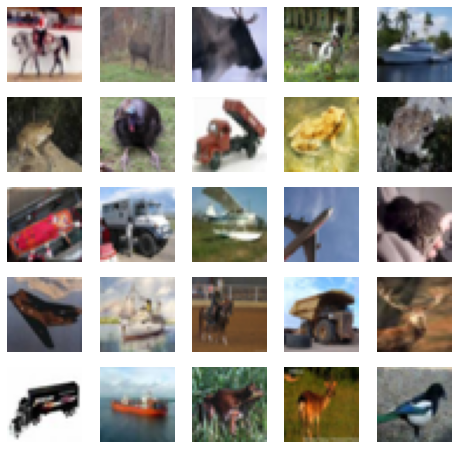

In [17]:
examples = ds_train.take(64)

fig, axs = plt.subplots(5, 5, figsize=(8,8))

for record, ax in zip(examples, axs.flat):
    image, _ = record
    ax.imshow(image)
    ax.axis('off')
plt.show()

# RAY Tune

In the previous notebooks, we manually tried different hyperparameters. Now, we are going to automate that process and use ray to find the best hyperparams. 

We need to define the following:

* objective to maximise
* hyperparam search space
* search algorithm to find best hyperparams


# Use Pretrained Models
Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. This allows us to reduce the training times and leverage on what base model has learned.

### Define Model

We will create our model that will accept hyperparams from the trainer. We are going to determine the best dropout rate, hidden units and activation to use in order to improve the model accuracy

In [30]:
class CIFAR10Model(Model):
    def __init__(self, base_model, num_classes, use_gap=False, drop_rate=0.1, hidden_units=128, hidden_activation='relu'):
        super(CIFAR10Model, self).__init__()
        self.base_model = base_model
        self.base_model.trainable = False
        self.use_gap = use_gap
        self.dropout = Dropout(drop_rate)
        self.fc1 = Dense(hidden_units, activation=hidden_activation)
        self.fc2 = Dense(num_classes)
        
    def call(self, x):
        x = self.base_model(x)
        if self.use_gap:
            x = GlobalAveragePooling2D()(x)
        else:
            x = Flatten()(x)
        x = self.fc1(x)
        x = self.dropout(x)
        return self.fc2(x)        

### Trainable

This is where you will setup the model initialisation and training. `tune.run` will run this class instance  with different hyperparams based on the config

In [31]:
# Reference: https://docs.ray.io/en/latest/tune/examples/tf_mnist_example.html
class CIFAR10Trainable(tune.Trainable):

    def load_data(self, batch_size):
        (ds_train, ds_test), metadata = tfds.load(
            'cifar10', split=['train', 'test'], shuffle_files=True, 
            with_info=True, as_supervised=True
        )        
        num_classes = metadata.features["label"].num_classes
        
        train_ds = ds_train \
            .cache() \
            .shuffle(num_train_examples).batch(batch_size, drop_remainder=True) \
            .prefetch(tf.data.experimental.AUTOTUNE)      
        
        test_ds = ds_test \
            .cache() \
            .batch(batch_size, drop_remainder=True) \
            .prefetch(tf.data.experimental.AUTOTUNE)         
        
        return train_ds, test_ds, num_classes
    
    def setup(self, config):
        import tensorflow as tf
        IMG_SIZE = 32
        BATCH_SIZE = 128
        # load data
        self.train_ds, self.test_ds, num_classes = self.load_data(BATCH_SIZE)
        # model
        base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
        self.model = CIFAR10Model(
            base_model,
            num_classes,
            config.get("use_gap", False),
            config.get("drop_rate", 0.1),
            config.get("hidden_units", 128),
            config.get("activation", "relu")
        )
        # set loss & optimizer
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam(config.get("lr", 1e-3))
        # set train and test metrics
        self.train_loss = tf.keras.metrics.Mean(name="train_loss")
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
        self.test_loss = tf.keras.metrics.Mean(name="test_loss")
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")
        
        @tf.function
        def train_step(images, labels):
            with tf.GradientTape() as tape:
                predictions = self.model(images)
                loss = self.loss_object(labels, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(
                zip(gradients, self.model.trainable_variables)
            )
            # record metric
            self.train_loss(loss)
            self.train_accuracy(labels, predictions)
        
        @tf.function
        def test_step(images, labels):
            predictions = self.model(images)
            test_loss = self.loss_object(labels, predictions)            
            # record metric
            self.test_loss(test_loss)
            self.test_accuracy(labels, predictions)
        
        self.tf_train_step = train_step
        self.tf_test_step = test_step
        
    def step(self):
        # reset state
        self.train_loss.reset_states()
        self.train_accuracy.reset_states()
        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        # train step
        for images, labels in self.train_ds:
            self.tf_train_step(images, labels)
        # test step
        for images, labels in self.test_ds:
            self.tf_test_step(images, labels)
            
        return {
            "epoch": self.iteration,
            "loss": self.train_loss.result().numpy(),
            "accuracy": self.train_accuracy.result().numpy()*100,
            "test_loss": self.test_loss.result().numpy(),
            "mean_accuracy": self.test_accuracy.result().numpy()*100,
        }        

### Setup Config

For config explanation, refer [docs](https://docs.ray.io/en/master/tune/api_docs/search_space.html#tune-sample-docs)

In [32]:
config = {
    "hidden_units": tune.grid_search([32, 64, 128, 256]),
#     "drop_rate": tune.quniform(0.0,0.8, 0.2), # says no attribute?
    "use_gap": tune.choice([True, False]), # Use Global Average Pooling
    "drop_rate": tune.uniform(0, 1),
    "activation": tune.choice(['elu', 'relu', 'selu']),
    "lr": tune.loguniform(1e-4, 1e-1)
}

# Terminate less promising trials using early stopping
scheduler = ASHAScheduler(metric="mean_accuracy", mode="max")

In [34]:
# I want to access dashboard from another machine
ray.shutdown()
ray.init(dashboard_host="0.0.0.0")

# run trials
analysis = tune.run(
    CIFAR10Trainable,
    config=config,
    num_samples=15,
    scheduler=scheduler,
    stop={"training_iteration": 50},
     resources_per_trial={"cpu": 6, "gpu": 1},
    ray_auto_init=False
)

2020-10-05 10:25:17,497	INFO resource_spec.py:231 -- Starting Ray with 77.29 GiB memory available for workers and up to 37.13 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-05 10:25:18,130	INFO services.py:1193 -- View the Ray dashboard at 192.168.86.61:8265


(pid=31267) 2020-10-05 10:25:19.414375: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31269) 2020-10-05 10:25:19.392242: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31267) 2020-10-05 10:25:20.759993: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31269) 2020-10-05 10:25:20.751518: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31267) 2020-10-05 10:25:20.893743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31267) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31267) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31267) 2020-10-05 10:25:20.893788: I tensorflow/str

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 13.631810247898102
  date: 2020-10-05_10-25-37
  done: false
  epoch: 0
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.7656311988830566
  mean_accuracy: 17.958733439445496
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 2.1400740146636963
  time_since_restore: 13.69922661781311
  time_this_iter_s: 13.69922661781311
  time_total_s: 13.69922661781311
  timestamp: 1601864737
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 19.364984333515167
  date: 2020-10-05_10-25-43
  done: false
  epoch: 1
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 2.0847980976104736
  mean_accuracy: 23.096954822540283
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 2.0162312984466553
  time_since_restore: 19.598351001739502
  time_this_iter_s: 5.899124383926392
  time_total_s: 19.598351001739502
  timestamp: 1601864743
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 24.92387890815735
  date: 2020-10-05_10-25-49
  done: false
  epoch: 2
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.960564136505127
  mean_accuracy: 24.138621985912323
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9663686752319336
  time_since_restore: 25.495309591293335
  time_this_iter_s: 5.896958589553833
  time_total_s: 25.495309591293335
  timestamp: 1601864749
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 26.16386115550995
  date: 2020-10-05_10-25-55
  done: false
  epoch: 3
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.8872226476669312
  mean_accuracy: 28.155046701431274
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8549728393554688
  time_since_restore: 31.421531200408936
  time_this_iter_s: 5.926221609115601
  time_total_s: 31.421531200408936
  timestamp: 1601864755
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00001
  


(pid=31269) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f460c5568c8> and will run it as-is.
(pid=31269) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31269) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f460c5568c8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31269) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31269) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 28.361377120018005
  date: 2020-10-05_10-26-01
  done: false
  epoch: 4
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 1.839826226234436
  mean_accuracy: 25.570914149284363
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9139705896377563
  time_since_restore: 37.36039161682129
  time_this_iter_s: 5.9388604164123535
  time_total_s: 37.36039161682129
  timestamp: 1601864761
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 17.409855127334595
  date: 2020-10-05_10-26-03
  done: false
  epoch: 0
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.472407341003418
  mean_accuracy: 26.081731915473938
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.896048903465271
  time_since_restore: 40.81207990646362
  time_this_iter_s: 40.81207990646362
  time_total_s: 40.81207990646362
  timestamp: 1601864763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 29.2227566242218
  date: 2020-10-05_10-26-06
  done: false
  epoch: 5
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 1.833

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 29.59134578704834
  date: 2020-10-05_10-26-13
  done: false
  epoch: 6
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  loss: 1.821116328239441
  mean_accuracy: 30.218347907066345
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9392175674438477
  time_since_restore: 49.33616328239441
  time_this_iter_s: 5.999964952468872
  time_total_s: 49.33616328239441
  timestamp: 1601864773
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.330529808998108
  date: 2020-10-05_10-26-18
  done: false
  epoch: 7
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 1.7985132932662964
  mean_accuracy: 29.767629504203796
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8451062440872192
  time_since_restore: 55.28501844406128
  time_this_iter_s: 5.94885516166687
  time_total_s: 55.28501844406128
  timestamp: 1601864778
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.121793389320374
  date: 2020-10-05_10-26-24
  done: false
  epoch: 8
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 1.782982587814331
  mean_accuracy: 27.47395932674408
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.888685941696167
  time_since_restore: 61.21843504905701
  time_this_iter_s: 5.9334166049957275
  time_total_s: 61.21843504905701
  timestamp: 1601864784
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.676682829856873
  date: 2020-10-05_10-26-30
  done: false
  epoch: 9
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 1.7669403553009033
  mean_accuracy: 29.106569290161133
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8025482892990112
  time_since_restore: 67.1404983997345
  time_this_iter_s: 5.92206335067749
  time_total_s: 67.1404983997345
  timestamp: 1601864790
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.973556637763977
  date: 2020-10-05_10-26-36
  done: false
  epoch: 10
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 1.7867004871368408
  mean_accuracy: 31.069710850715637
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8807318210601807
  time_since_restore: 73.06902623176575
  time_this_iter_s: 5.92852783203125
  time_total_s: 73.06902623176575
  timestamp: 1601864796
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 27.920672297477722
  date: 2020-10-05_10-26-39
  done: false
  epoch: 1
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.8727295398712158
  mean_accuracy: 28.23517620563507
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.9496560096740723
  time_since_restore: 76.5385754108429
  time_this_iter_s: 35.72649550437927
  time_total_s: 76.5385754108429
  timestamp: 1601864799
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.911457538604736
  date: 2020-10-05_10-26-42
  done: false
  epoch: 11
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 1.

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.203925609588623
  date: 2020-10-05_10-26-48
  done: false
  epoch: 12
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  loss: 1.7907044887542725
  mean_accuracy: 29.14663553237915
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8209497928619385
  time_since_restore: 84.97769069671631
  time_this_iter_s: 5.943514108657837
  time_total_s: 84.97769069671631
  timestamp: 1601864808
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.04366958141327
  date: 2020-10-05_10-26-54
  done: false
  epoch: 13
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 1.7853152751922607
  mean_accuracy: 31.730768084526062
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8835684061050415
  time_since_restore: 90.96638512611389
  time_this_iter_s: 5.988694429397583
  time_total_s: 90.96638512611389
  timestamp: 1601864814
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.412258744239807
  date: 2020-10-05_10-27-00
  done: false
  epoch: 14
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 1.7692787647247314
  mean_accuracy: 28.074920177459717
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.867922067642212
  time_since_restore: 96.92129492759705
  time_this_iter_s: 5.954909801483154
  time_total_s: 96.92129492759705
  timestamp: 1601864820
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.294071674346924
  date: 2020-10-05_10-27-06
  done: false
  epoch: 15
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 1.7707048654556274
  mean_accuracy: 31.440305709838867
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8204983472824097
  time_since_restore: 102.88695740699768
  time_this_iter_s: 5.965662479400635
  time_total_s: 102.88695740699768
  timestamp: 1601864826
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.474357843399048
  date: 2020-10-05_10-27-12
  done: false
  epoch: 16
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 17
  loss: 1.7596890926361084
  mean_accuracy: 31.570512056350708
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8793710470199585
  time_since_restore: 108.87184453010559
  time_this_iter_s: 5.98488712310791
  time_total_s: 108.87184453010559
  timestamp: 1601864832
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 29.691505432128906
  date: 2020-10-05_10-27-15
  done: false
  epoch: 2
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.8239567279815674
  mean_accuracy: 28.40544879436493
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.7894054651260376
  time_since_restore: 112.34164047241211
  time_this_iter_s: 35.803065061569214
  time_total_s: 112.34164047241211
  timestamp: 1601864835
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.22195601463318
  date: 2020-10-05_10-27-18
  done: false
  epoch: 17
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 18
  loss

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.179887056350708
  date: 2020-10-05_10-27-24
  done: false
  epoch: 18
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 19
  loss: 1.7711328268051147
  mean_accuracy: 27.21354067325592
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8663424253463745
  time_since_restore: 120.78960013389587
  time_this_iter_s: 5.953756809234619
  time_total_s: 120.78960013389587
  timestamp: 1601864844
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.51682710647583
  date: 2020-10-05_10-27-30
  done: false
  epoch: 19
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 20
  loss: 1.7819974422454834
  mean_accuracy: 27.524039149284363
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8975855112075806
  time_since_restore: 126.7867681980133
  time_this_iter_s: 5.997168064117432
  time_total_s: 126.7867681980133
  timestamp: 1601864850
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.27804398536682
  date: 2020-10-05_10-27-36
  done: false
  epoch: 20
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 21
  loss: 1.7572823762893677
  mean_accuracy: 31.99118673801422
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.774625301361084
  time_since_restore: 132.77819800376892
  time_this_iter_s: 5.991429805755615
  time_total_s: 132.77819800376892
  timestamp: 1601864856
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.837339162826538
  date: 2020-10-05_10-27-42
  done: false
  epoch: 21
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 22
  loss: 1.7765653133392334
  mean_accuracy: 30.168268084526062
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8500951528549194
  time_since_restore: 138.77770471572876
  time_this_iter_s: 5.999506711959839
  time_total_s: 138.77770471572876
  timestamp: 1601864862
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.282052397727966
  date: 2020-10-05_10-27-48
  done: false
  epoch: 22
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 23
  loss: 1.7553869485855103
  mean_accuracy: 28.896233439445496
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.969938039779663
  time_since_restore: 144.76519298553467
  time_this_iter_s: 5.987488269805908
  time_total_s: 144.76519298553467
  timestamp: 1601864868
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 29.911857843399048
  date: 2020-10-05_10-27-50
  done: false
  epoch: 3
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.8271137475967407
  mean_accuracy: 28.936296701431274
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8820712566375732
  time_since_restore: 148.03939175605774
  time_this_iter_s: 35.69775128364563
  time_total_s: 148.03939175605774
  timestamp: 1601864870
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.340143084526062
  date: 2020-10-05_10-27-54
  done: false
  epoch: 23
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 24
  los

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 32.035255432128906
  date: 2020-10-05_10-28-00
  done: false
  epoch: 24
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 25
  loss: 1.7393473386764526
  mean_accuracy: 26.923078298568726
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8653573989868164
  time_since_restore: 156.7624316215515
  time_this_iter_s: 5.991699934005737
  time_total_s: 156.7624316215515
  timestamp: 1601864880
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.31209909915924
  date: 2020-10-05_10-28-06
  done: false
  epoch: 25
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 26
  loss: 1.7645237445831299
  mean_accuracy: 30.238381028175354
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.820789098739624
  time_since_restore: 162.73645758628845
  time_this_iter_s: 5.9740259647369385
  time_total_s: 162.73645758628845
  timestamp: 1601864886
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.260016560554504
  date: 2020-10-05_10-28-12
  done: false
  epoch: 26
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 27
  loss: 1.754399061203003
  mean_accuracy: 30.108171701431274
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.873801827430725
  time_since_restore: 168.75464534759521
  time_this_iter_s: 6.018187761306763
  time_total_s: 168.75464534759521
  timestamp: 1601864892
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.210337042808533
  date: 2020-10-05_10-28-18
  done: false
  epoch: 27
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 28
  loss: 1.7878543138504028
  mean_accuracy: 29.356971383094788
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.879716157913208
  time_since_restore: 174.73604464530945
  time_this_iter_s: 5.981399297714233
  time_total_s: 174.73604464530945
  timestamp: 1601864898
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.47676384449005
  date: 2020-10-05_10-28-24
  done: false
  epoch: 28
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 29
  loss: 1.7857961654663086
  mean_accuracy: 27.634215354919434
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8911272287368774
  time_since_restore: 180.73040652275085
  time_this_iter_s: 5.994361877441406
  time_total_s: 180.73040652275085
  timestamp: 1601864904
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 30.96955120563507
  date: 2020-10-05_10-28-26
  done: false
  epoch: 4
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 5
  loss: 1.8133269548416138
  mean_accuracy: 28.92628312110901
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.7709085941314697
  time_since_restore: 183.7997751235962
  time_this_iter_s: 35.76038336753845
  time_total_s: 183.7997751235962
  timestamp: 1601864906
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.631008744239807
  date: 2020-10-05_10-28-30
  done: false
  epoch: 29
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 30
  loss: 1

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.827322602272034
  date: 2020-10-05_10-28-36
  done: false
  epoch: 30
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 31
  loss: 1.774334192276001
  mean_accuracy: 30.869391560554504
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8612209558486938
  time_since_restore: 192.73055601119995
  time_this_iter_s: 6.004278898239136
  time_total_s: 192.73055601119995
  timestamp: 1601864916
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.883413553237915
  date: 2020-10-05_10-28-42
  done: false
  epoch: 31
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 32
  loss: 1.766080379486084
  mean_accuracy: 26.832932233810425
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9150431156158447
  time_since_restore: 198.76211619377136
  time_this_iter_s: 6.031560182571411
  time_total_s: 198.76211619377136
  timestamp: 1601864922
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.89343011379242
  date: 2020-10-05_10-28-48
  done: false
  epoch: 32
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 33
  loss: 1.769888997077942
  mean_accuracy: 28.79607379436493
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.81451416015625
  time_since_restore: 204.79407477378845
  time_this_iter_s: 6.03195858001709
  time_total_s: 204.79407477378845
  timestamp: 1601864928
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.711138248443604
  date: 2020-10-05_10-28-54
  done: false
  epoch: 33
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 34
  loss: 1.776532769203186
  mean_accuracy: 26.652643084526062
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.873132586479187
  time_since_restore: 210.80066347122192
  time_this_iter_s: 6.006588697433472
  time_total_s: 210.80066347122192
  timestamp: 1601864934
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.97556233406067
  date: 2020-10-05_10-29-00
  done: false
  epoch: 34
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 35
  loss: 1.7687461376190186
  mean_accuracy: 26.592546701431274
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9059772491455078
  time_since_restore: 216.84169483184814
  time_this_iter_s: 6.041031360626221
  time_total_s: 216.84169483184814
  timestamp: 1601864940
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 31.758815050125122
  date: 2020-10-05_10-29-02
  done: false
  epoch: 5
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 6
  loss: 1.7869118452072144
  mean_accuracy: 24.799679219722748
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8656705617904663
  time_since_restore: 219.66957688331604
  time_this_iter_s: 35.86980175971985
  time_total_s: 219.66957688331604
  timestamp: 1601864942
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.28405511379242
  date: 2020-10-05_10-29-06
  done: false
  epoch: 35
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 36
  loss

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.779245495796204
  date: 2020-10-05_10-29-12
  done: false
  epoch: 36
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 37
  loss: 1.7652912139892578
  mean_accuracy: 28.846153616905212
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.817226529121399
  time_since_restore: 228.88096237182617
  time_this_iter_s: 6.022586107254028
  time_total_s: 228.88096237182617
  timestamp: 1601864952
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.78325390815735
  date: 2020-10-05_10-29-18
  done: false
  epoch: 37
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 38
  loss: 1.772926688194275
  mean_accuracy: 26.84294879436493
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8739120960235596
  time_since_restore: 234.8927252292633
  time_this_iter_s: 6.011762857437134
  time_total_s: 234.8927252292633
  timestamp: 1601864958
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.082130432128906
  date: 2020-10-05_10-29-24
  done: false
  epoch: 38
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 39
  loss: 1.7859658002853394
  mean_accuracy: 30.458733439445496
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8637114763259888
  time_since_restore: 240.9070281982422
  time_this_iter_s: 6.014302968978882
  time_total_s: 240.9070281982422
  timestamp: 1601864964
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.560898780822754
  date: 2020-10-05_10-29-30
  done: false
  epoch: 39
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 40
  loss: 1.7777678966522217
  mean_accuracy: 26.80288553237915
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9947552680969238
  time_since_restore: 246.9340844154358
  time_this_iter_s: 6.0270562171936035
  time_total_s: 246.9340844154358
  timestamp: 1601864970
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.069710850715637
  date: 2020-10-05_10-29-36
  done: false
  epoch: 40
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 41
  loss: 1.7652868032455444
  mean_accuracy: 26.352164149284363
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9972546100616455
  time_since_restore: 252.98893880844116
  time_this_iter_s: 6.054854393005371
  time_total_s: 252.98893880844116
  timestamp: 1601864976
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 31.266024708747864
  date: 2020-10-05_10-29-38
  done: false
  epoch: 6
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 7
  loss: 1.7983897924423218
  mean_accuracy: 33.363381028175354
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8104333877563477
  time_since_restore: 255.43745636940002
  time_this_iter_s: 35.767879486083984
  time_total_s: 255.43745636940002
  timestamp: 1601864978
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.929487943649292
  date: 2020-10-05_10-29-43
  done: false
  epoch: 41
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 42
  lo

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 31.00961446762085
  date: 2020-10-05_10-29-49
  done: false
  epoch: 42
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 43
  loss: 1.754428505897522
  mean_accuracy: 28.786057233810425
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.8537224531173706
  time_since_restore: 265.0291118621826
  time_this_iter_s: 6.009595155715942
  time_total_s: 265.0291118621826
  timestamp: 1601864989
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.04406988620758
  date: 2020-10-05_10-29-55
  done: false
  epoch: 43
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 44
  loss: 1.7937361001968384
  mean_accuracy: 28.856170177459717
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9189343452453613
  time_since_restore: 271.042364358902
  time_this_iter_s: 6.01325249671936
  time_total_s: 271.042364358902
  timestamp: 1601864995
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.663061141967773
  date: 2020-10-05_10-30-01
  done: false
  epoch: 44
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 45
  loss: 1.7788207530975342
  mean_accuracy: 29.897835850715637
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.844169020652771
  time_since_restore: 277.107054233551
  time_this_iter_s: 6.064689874649048
  time_total_s: 277.107054233551
  timestamp: 1601865001
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 29.96794879436493
  date: 2020-10-05_10-30-07
  done: false
  epoch: 45
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 46
  loss: 1.7936087846755981
  mean_accuracy: 30.278444290161133
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.889285922050476
  time_since_restore: 283.138587474823
  time_this_iter_s: 6.031533241271973
  time_total_s: 283.138587474823
  timestamp: 1601865007
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.18830120563507
  date: 2020-10-05_10-30-13
  done: false
  epoch: 46
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 47
  loss: 1.7804956436157227
  mean_accuracy: 27.19351053237915
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9124737977981567
  time_since_restore: 289.1836769580841
  time_this_iter_s: 6.045089483261108
  time_total_s: 289.1836769580841
  timestamp: 1601865013
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 32.41586685180664
  date: 2020-10-05_10-30-13
  done: false
  epoch: 7
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 8
  loss: 1.7813682556152344
  mean_accuracy: 35.37660241127014
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.7838635444641113
  time_since_restore: 291.0008623600006
  time_this_iter_s: 35.563405990600586
  time_total_s: 291.0008623600006
  timestamp: 1601865013
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.657050013542175
  date: 2020-10-05_10-30-19
  done: false
  epoch: 47
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 48
  loss: 

Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.526843667030334
  date: 2020-10-05_10-30-25
  done: false
  epoch: 48
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 49
  loss: 1.7763615846633911
  mean_accuracy: 29.27684187889099
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.902832269668579
  time_since_restore: 301.2481303215027
  time_this_iter_s: 6.044766902923584
  time_total_s: 301.2481303215027
  timestamp: 1601865025
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00001
  


Result for CIFAR10Trainable_02a36_00001:
  accuracy: 30.869391560554504
  date: 2020-10-05_10-30-31
  done: true
  epoch: 49
  experiment_id: bcad4ee67d894174bf5d8594bba39f14
  experiment_tag: 1_activation=relu,drop_rate=0.014704,hidden_units=64,lr=0.032551,use_gap=False
  hostname: ironman
  iterations_since_restore: 50
  loss: 1.763553261756897
  mean_accuracy: 25.831329822540283
  node_ip: 192.168.86.61
  pid: 31267
  test_loss: 1.9020168781280518
  time_since_restore: 307.2752733230591
  time_this_iter_s: 6.0271430015563965
  time_total_s: 307.2752733230591
  timestamp: 1601865031
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00001
  


(pid=31354) 2020-10-05 10:30:32.019047: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31354) 2020-10-05 10:30:34.452307: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31354) 2020-10-05 10:30:34.603328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31354) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31354) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31354) 2020-10-05 10:30:34.603389: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31354) 2020-10-05 10:30:34.605419: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31354) 2020-10-05 10:30:34.606949: I tensorflow/

Result for CIFAR10Trainable_02a36_00000:
  accuracy: 32.55809247493744
  date: 2020-10-05_10-30-49
  done: false
  epoch: 8
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 9
  loss: 1.7661162614822388
  mean_accuracy: 31.40023946762085
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8051397800445557
  time_since_restore: 326.91325521469116
  time_this_iter_s: 35.91239285469055
  time_total_s: 326.91325521469116
  timestamp: 1601865049
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00000
  


(pid=31354) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7ef79c3668c8> and will run it as-is.
(pid=31354) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31354) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7ef79c3668c8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31354) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31354) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 45.18229067325592
  date: 2020-10-05_10-30-54
  done: false
  epoch: 0
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.2284023761749268
  mean_accuracy: 50.74118375778198
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.3571546077728271
  time_since_restore: 15.707097291946411
  time_this_iter_s: 15.707097291946411
  time_total_s: 15.707097291946411
  timestamp: 1601865054
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00002
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 55.793267488479614
  date: 2020-10-05_10-31-00
  done: false
  epoch: 1
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 58.04487466812134
  date: 2020-10-05_10-31-06
  done: false
  epoch: 2
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.2265063524246216
  mean_accuracy: 57.05128312110901
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.2914001941680908
  time_since_restore: 27.79658007621765
  time_this_iter_s: 6.043389081954956
  time_total_s: 27.79658007621765
  timestamp: 1601865066
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 58.90825390815735
  date: 2020-10-05_10-31-12
  done: false
  epoch: 3
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.2162296772003174
  mean_accuracy: 55.78926205635071
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.3428815603256226
  time_since_restore: 33.84626245498657
  time_this_iter_s: 6.049682378768921
  time_total_s: 33.84626245498657
  timestamp: 1601865072
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 59.945911169052124
  date: 2020-10-05_10-31-18
  done: false
  epoch: 4
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 1.1840046644210815
  mean_accuracy: 56.149840354919434
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.4075641632080078
  time_since_restore: 39.889894247055054
  time_this_iter_s: 6.0436317920684814
  time_total_s: 39.889894247055054
  timestamp: 1601865078
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 60.65705418586731
  date: 2020-10-05_10-31-24
  done: false
  epoch: 5
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 1.1602283716201782
  mean_accuracy: 54.03645634651184
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.4610204696655273
  time_since_restore: 45.93968343734741
  time_this_iter_s: 6.049789190292358
  time_total_s: 45.93968343734741
  timestamp: 1601865084
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 32.44991898536682
  date: 2020-10-05_10-31-25
  done: false
  epoch: 9
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 10
  loss: 1.7864055633544922
  mean_accuracy: 33.55368673801422
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.7667919397354126
  time_since_restore: 362.6261074542999
  time_this_iter_s: 35.712852239608765
  time_total_s: 362.6261074542999
  timestamp: 1601865085
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 61.850959062576294
  date: 2020-10-05_10-31-30
  done: false
  epoch: 6
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  loss: 

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 61.75079941749573
  date: 2020-10-05_10-31-36
  done: false
  epoch: 7
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 1.1379789113998413
  mean_accuracy: 56.68069124221802
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.3918720483779907
  time_since_restore: 58.019036054611206
  time_this_iter_s: 6.047950506210327
  time_total_s: 58.019036054611206
  timestamp: 1601865096
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 61.530447006225586
  date: 2020-10-05_10-31-42
  done: false
  epoch: 8
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 1.1360185146331787
  mean_accuracy: 53.01482081413269
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.5034635066986084
  time_since_restore: 64.05493569374084
  time_this_iter_s: 6.035899639129639
  time_total_s: 64.05493569374084
  timestamp: 1601865102
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 62.626200914382935
  date: 2020-10-05_10-31-48
  done: false
  epoch: 9
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 1.116017460823059
  mean_accuracy: 54.60737347602844
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.4745080471038818
  time_since_restore: 70.10049891471863
  time_this_iter_s: 6.045563220977783
  time_total_s: 70.10049891471863
  timestamp: 1601865108
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 62.489986419677734
  date: 2020-10-05_10-31-54
  done: false
  epoch: 10
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 1.133628249168396
  mean_accuracy: 57.55208134651184
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.3433661460876465
  time_since_restore: 76.15104484558105
  time_this_iter_s: 6.050545930862427
  time_total_s: 76.15104484558105
  timestamp: 1601865114
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 62.846553325653076
  date: 2020-10-05_10-32-01
  done: false
  epoch: 11
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 1.1145238876342773
  mean_accuracy: 58.67387652397156
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.365206241607666
  time_since_restore: 82.19610977172852
  time_this_iter_s: 6.045064926147461
  time_total_s: 82.19610977172852
  timestamp: 1601865121
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 32.898637652397156
  date: 2020-10-05_10-32-01
  done: false
  epoch: 10
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 11
  loss: 1.7773677110671997
  mean_accuracy: 33.85416567325592
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8996515274047852
  time_since_restore: 398.2158987522125
  time_this_iter_s: 35.5897912979126
  time_total_s: 398.2158987522125
  timestamp: 1601865121
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 63.257211446762085
  date: 2020-10-05_10-32-07
  done: false
  epoch: 12
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  loss

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 63.661861419677734
  date: 2020-10-05_10-32-13
  done: false
  epoch: 13
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 1.0922067165374756
  mean_accuracy: 55.98958134651184
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.4499223232269287
  time_since_restore: 94.2755081653595
  time_this_iter_s: 6.02734899520874
  time_total_s: 94.2755081653595
  timestamp: 1601865133
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 63.41747045516968
  date: 2020-10-05_10-32-19
  done: false
  epoch: 14
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 1.1029356718063354
  mean_accuracy: 56.370192766189575
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.5006765127182007
  time_since_restore: 100.3306736946106
  time_this_iter_s: 6.055165529251099
  time_total_s: 100.3306736946106
  timestamp: 1601865139
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 63.92027139663696
  date: 2020-10-05_10-32-25
  done: false
  epoch: 15
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 1.0868101119995117
  mean_accuracy: 56.88101053237915
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.4391634464263916
  time_since_restore: 106.3568389415741
  time_this_iter_s: 6.026165246963501
  time_total_s: 106.3568389415741
  timestamp: 1601865145
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 64.56330418586731
  date: 2020-10-05_10-32-31
  done: false
  epoch: 16
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 17
  loss: 1.0631873607635498
  mean_accuracy: 57.47195482254028
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.4169756174087524
  time_since_restore: 112.39032363891602
  time_this_iter_s: 6.033484697341919
  time_total_s: 112.39032363891602
  timestamp: 1601865151
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 33.00480842590332
  date: 2020-10-05_10-32-36
  done: false
  epoch: 11
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 12
  loss: 1.7836445569992065
  mean_accuracy: 28.375402092933655
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8966203927993774
  time_since_restore: 433.94650173187256
  time_this_iter_s: 35.730602979660034
  time_total_s: 433.94650173187256
  timestamp: 1601865156
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00000
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 64.22876715660095
  date: 2020-10-05_10-32-37
  done: false
  epoch: 17
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 18
  loss: 1.0840401649475098
  mean_accuracy: 55.01803159713745
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.529812216758728
  time_since_restore: 118.4205207824707
  time_this_iter_s: 6.0301971435546875
  time_total_s: 118.4205207824707
  timestamp: 1601865157
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00002
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 64.89382982254028
  date: 2020-10-05_10-32-43
  done: false
  epoch: 18
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 19
  los

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 64.74158763885498
  date: 2020-10-05_10-32-49
  done: false
  epoch: 19
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 20
  loss: 1.0666272640228271
  mean_accuracy: 58.693909645080566
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.417023777961731
  time_since_restore: 130.4847068786621
  time_this_iter_s: 6.044235944747925
  time_total_s: 130.4847068786621
  timestamp: 1601865169
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 64.97195363044739
  date: 2020-10-05_10-32-55
  done: false
  epoch: 20
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 21
  loss: 1.0529899597167969
  mean_accuracy: 55.74919581413269
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.5793765783309937
  time_since_restore: 136.52964091300964
  time_this_iter_s: 6.044934034347534
  time_total_s: 136.52964091300964
  timestamp: 1601865175
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 65.52684307098389
  date: 2020-10-05_10-33-01
  done: false
  epoch: 21
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 22
  loss: 1.0369532108306885
  mean_accuracy: 57.522034645080566
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.5004016160964966
  time_since_restore: 142.59054017066956
  time_this_iter_s: 6.060899257659912
  time_total_s: 142.59054017066956
  timestamp: 1601865181
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 65.89743494987488
  date: 2020-10-05_10-33-07
  done: false
  epoch: 22
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 23
  loss: 1.0336955785751343
  mean_accuracy: 54.306888580322266
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.594020128250122
  time_since_restore: 148.64031839370728
  time_this_iter_s: 6.04977822303772
  time_total_s: 148.64031839370728
  timestamp: 1601865187
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 33.05288553237915
  date: 2020-10-05_10-33-12
  done: false
  epoch: 12
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 13
  loss: 1.7754946947097778
  mean_accuracy: 31.640625
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.7593914270401
  time_since_restore: 469.52960872650146
  time_this_iter_s: 35.583106994628906
  time_total_s: 469.52960872650146
  timestamp: 1601865192
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 65.19832015037537
  date: 2020-10-05_10-33-13
  done: false
  epoch: 23
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 24
  loss: 1.06056

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 65.51682949066162
  date: 2020-10-05_10-33-19
  done: false
  epoch: 24
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 25
  loss: 1.0567420721054077
  mean_accuracy: 54.507213830947876
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.74093759059906
  time_since_restore: 160.8103609085083
  time_this_iter_s: 6.087944030761719
  time_total_s: 160.8103609085083
  timestamp: 1601865199
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.24398827552795
  date: 2020-10-05_10-33-25
  done: false
  epoch: 25
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 26
  loss: 1.028134822845459
  mean_accuracy: 53.125
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.5908548831939697
  time_since_restore: 166.8867585659027
  time_this_iter_s: 6.076397657394409
  time_total_s: 166.8867585659027
  timestamp: 1601865205
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.06169939041138
  date: 2020-10-05_10-33-31
  done: false
  epoch: 26
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 27
  loss: 1.030312418937683
  mean_accuracy: 57.55208134651184
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.6077967882156372
  time_since_restore: 172.92856621742249
  time_this_iter_s: 6.041807651519775
  time_total_s: 172.92856621742249
  timestamp: 1601865211
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.4643406867981
  date: 2020-10-05_10-33-37
  done: false
  epoch: 27
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 28
  loss: 1.0017751455307007
  mean_accuracy: 56.70071840286255
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.6538608074188232
  time_since_restore: 178.98120760917664
  time_this_iter_s: 6.05264139175415
  time_total_s: 178.98120760917664
  timestamp: 1601865217
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.4102554321289
  date: 2020-10-05_10-33-44
  done: false
  epoch: 28
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 29
  loss: 1.0150797367095947
  mean_accuracy: 56.911057233810425
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.6694235801696777
  time_since_restore: 185.03814053535461
  time_this_iter_s: 6.0569329261779785
  time_total_s: 185.03814053535461
  timestamp: 1601865224
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 32.79847800731659
  date: 2020-10-05_10-33-48
  done: false
  epoch: 13
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 14
  loss: 1.7794582843780518
  mean_accuracy: 26.52243673801422
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.852931261062622
  time_since_restore: 505.11027932167053
  time_this_iter_s: 35.58067059516907
  time_total_s: 505.11027932167053
  timestamp: 1601865228
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.25000238418579
  date: 2020-10-05_10-33-50
  done: false
  epoch: 29
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 30
  loss

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.92708134651184
  date: 2020-10-05_10-33-56
  done: false
  epoch: 30
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 31
  loss: 1.0029023885726929
  mean_accuracy: 56.42027258872986
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.6501859426498413
  time_since_restore: 197.15526127815247
  time_this_iter_s: 6.053799390792847
  time_total_s: 197.15526127815247
  timestamp: 1601865236
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.8549656867981
  date: 2020-10-05_10-34-02
  done: false
  epoch: 31
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 32
  loss: 1.0030187368392944
  mean_accuracy: 54.44711446762085
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.7072933912277222
  time_since_restore: 203.20902585983276
  time_this_iter_s: 6.053764581680298
  time_total_s: 203.20902585983276
  timestamp: 1601865242
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.56851172447205
  date: 2020-10-05_10-34-08
  done: false
  epoch: 32
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 33
  loss: 1.0134929418563843
  mean_accuracy: 55.81930875778198
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.854201316833496
  time_since_restore: 209.26256346702576
  time_this_iter_s: 6.053537607192993
  time_total_s: 209.26256346702576
  timestamp: 1601865248
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.66666865348816
  date: 2020-10-05_10-34-14
  done: false
  epoch: 33
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 34
  loss: 1.0078738927841187
  mean_accuracy: 56.48036599159241
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.769513487815857
  time_since_restore: 215.32765698432922
  time_this_iter_s: 6.065093517303467
  time_total_s: 215.32765698432922
  timestamp: 1601865254
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 66.82291626930237
  date: 2020-10-05_10-34-20
  done: false
  epoch: 34
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 35
  loss: 1.0051079988479614
  mean_accuracy: 54.23678159713745
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.829481840133667
  time_since_restore: 221.37296891212463
  time_this_iter_s: 6.04531192779541
  time_total_s: 221.37296891212463
  timestamp: 1601865260
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 32.918670773506165
  date: 2020-10-05_10-34-23
  done: false
  epoch: 14
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 15
  loss: 1.781080961227417
  mean_accuracy: 33.96434187889099
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.8495256900787354
  time_since_restore: 540.6700439453125
  time_this_iter_s: 35.55976462364197
  time_total_s: 540.6700439453125
  timestamp: 1601865263
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00000
  
Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.10336804389954
  date: 2020-10-05_10-34-26
  done: false
  epoch: 35
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 36
  loss:

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.1013593673706
  date: 2020-10-05_10-34-32
  done: false
  epoch: 36
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.9996004700660706
  mean_accuracy: 56.75080418586731
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.694044828414917
  time_since_restore: 233.4846749305725
  time_this_iter_s: 6.049746990203857
  time_total_s: 233.4846749305725
  timestamp: 1601865272
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.55408644676208
  date: 2020-10-05_10-34-38
  done: false
  epoch: 37
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.9779545068740845
  mean_accuracy: 56.01963400840759
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.7149252891540527
  time_since_restore: 239.52812552452087
  time_this_iter_s: 6.043450593948364
  time_total_s: 239.52812552452087
  timestamp: 1601865278
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.36778616905212
  date: 2020-10-05_10-34-44
  done: false
  epoch: 38
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.9830244183540344
  mean_accuracy: 54.63742017745972
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.8109917640686035
  time_since_restore: 245.57427430152893
  time_this_iter_s: 6.046148777008057
  time_total_s: 245.57427430152893
  timestamp: 1601865284
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.47996807098389
  date: 2020-10-05_10-34-50
  done: false
  epoch: 39
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 40
  loss: 0.9865175485610962
  mean_accuracy: 56.18990659713745
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.8007745742797852
  time_since_restore: 251.61168694496155
  time_this_iter_s: 6.037412643432617
  time_total_s: 251.61168694496155
  timestamp: 1601865290
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.51201748847961
  date: 2020-10-05_10-34-56
  done: false
  epoch: 40
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 41
  loss: 0.9802817106246948
  mean_accuracy: 53.6057710647583
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.8235639333724976
  time_since_restore: 257.67928671836853
  time_this_iter_s: 6.067599773406982
  time_total_s: 257.67928671836853
  timestamp: 1601865296
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00000:
  accuracy: 33.25320482254028
  date: 2020-10-05_10-34-59
  done: true
  epoch: 15
  experiment_id: c2005e6434704a648b2d3318410c04e5
  experiment_tag: 0_activation=selu,drop_rate=0.25301,hidden_units=32,lr=0.028265,use_gap=True
  hostname: ironman
  iterations_since_restore: 16
  loss: 1.7624508142471313
  mean_accuracy: 31.77083432674408
  node_ip: 192.168.86.61
  pid: 31269
  test_loss: 1.9197900295257568
  time_since_restore: 576.3642084598541
  time_this_iter_s: 35.694164514541626
  time_total_s: 576.3642084598541
  timestamp: 1601865299
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00000
  


(pid=31262) 2020-10-05 10:34:59.786905: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31262) 2020-10-05 10:35:01.145096: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31262) 2020-10-05 10:35:01.283106: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=31262) 2020-10-05 10:35:01.283200: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=31262) 2020-10-05 10:35:01.283219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=31262) 2020-10-05 10:35:01.283358: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=31262) 2020-10-05 10:35:01.283419: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.70632863044739
  date: 2020-10-05_10-35-02
  done: false
  epoch: 41
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 42
  loss: 0.9852197766304016
  mean_accuracy: 52.874600887298584
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.9599533081054688
  time_since_restore: 263.685507774353
  time_this_iter_s: 6.006221055984497
  time_total_s: 263.685507774353
  timestamp: 1601865302
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 02a36_00002
  


(pid=31262) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fbb446da7b8> and will run it as-is.
(pid=31262) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31262) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fbb446da7b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31262) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31262) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.43990182876587
  date: 2020-10-05_10-35-08
  done: false
  epoch: 42
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.9922677874565125
  mean_accuracy: 56.29006624221802
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.7047152519226074
  time_since_restore: 269.70447969436646
  time_this_iter_s: 6.018971920013428
  time_total_s: 269.70447969436646
  timestamp: 1601865308
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 68.04086565971375
  date: 2020-10-05_10-35-14
  done: false
  epoch: 43
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.9699944853782654
  mean_accuracy: 55.39863705635071
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.78561532497406
  time_since_restore: 275.77480697631836
  time_this_iter_s: 6.070327281951904
  time_total_s: 275.77480697631836
  timestamp: 1601865314
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.90664792060852
  date: 2020-10-05_10-35-20
  done: false
  epoch: 44
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 45
  loss: 0.9651204943656921
  mean_accuracy: 53.9963960647583
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.790535569190979
  time_since_restore: 281.8450164794922
  time_this_iter_s: 6.070209503173828
  time_total_s: 281.8450164794922
  timestamp: 1601865320
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.36578345298767
  date: 2020-10-05_10-35-27
  done: false
  epoch: 45
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 46
  loss: 0.9911131262779236
  mean_accuracy: 56.66065812110901
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.8722076416015625
  time_since_restore: 287.88041496276855
  time_this_iter_s: 6.035398483276367
  time_total_s: 287.88041496276855
  timestamp: 1601865327
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 68.17507743835449
  date: 2020-10-05_10-35-33
  done: false
  epoch: 46
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 47
  loss: 0.9650988578796387
  mean_accuracy: 55.15825152397156
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.8221139907836914
  time_since_restore: 293.927747964859
  time_this_iter_s: 6.047333002090454
  time_total_s: 293.927747964859
  timestamp: 1601865333
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00002
  


(pid=31262) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fbb446da840> and will run it as-is.
(pid=31262) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31262) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fbb446da840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31262) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31262) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 68.38942170143127
  date: 2020-10-05_10-35-39
  done: false
  epoch: 47
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 48
  loss: 0.9514110684394836
  mean_accuracy: 54.87780570983887
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 2.0420379638671875
  time_since_restore: 299.9594690799713
  time_this_iter_s: 6.031721115112305
  time_total_s: 299.9594690799713
  timestamp: 1601865339
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 02a36_00002
  


Result for CIFAR10Trainable_02a36_00003:
  accuracy: 11.78685873746872
  date: 2020-10-05_10-35-43
  done: true
  epoch: 0
  experiment_id: 0aac0cce13434dd6bba220e6567962dc
  experiment_tag: 3_activation=elu,drop_rate=0.52172,hidden_units=256,lr=0.06915,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 10.002252578735352
  mean_accuracy: 10.69711521267891
  node_ip: 192.168.86.61
  pid: 31262
  test_loss: 2.710080146789551
  time_since_restore: 40.12865614891052
  time_this_iter_s: 40.12865614891052
  time_total_s: 40.12865614891052
  timestamp: 1601865343
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00003
  


(pid=31263) 2020-10-05 10:35:43.634769: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00002:
  accuracy: 68.18910241127014
  date: 2020-10-05_10-35-45
  done: false
  epoch: 48
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 49
  loss: 0.9625244140625
  mean_accuracy: 54.437100887298584
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.9212487936019897
  time_since_restore: 305.99904704093933
  time_this_iter_s: 6.039577960968018
  time_total_s: 305.99904704093933
  timestamp: 1601865345
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00002
  


(pid=31263) 2020-10-05 10:35:44.999361: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31263) 2020-10-05 10:35:45.134903: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=31263) 2020-10-05 10:35:45.134946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=31263) 2020-10-05 10:35:45.134953: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=31263) 2020-10-05 10:35:45.135037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=31263) 2020-10-05 10:35:45.135062: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.51.6
(pid=31263) 2020-10-05 10:35:45.135068: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to matc

(pid=31263) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fd4602db7b8> and will run it as-is.
(pid=31263) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31263) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fd4602db7b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31263) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31263) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00002:
  accuracy: 67.92467832565308
  date: 2020-10-05_10-35-51
  done: true
  epoch: 49
  experiment_id: 8321b377f9f54bdab594ee1012d368a8
  experiment_tag: 2_activation=selu,drop_rate=0.90218,hidden_units=128,lr=0.012099,use_gap=False
  hostname: ironman
  iterations_since_restore: 50
  loss: 0.985154390335083
  mean_accuracy: 54.70753312110901
  node_ip: 192.168.86.61
  pid: 31354
  test_loss: 1.9668704271316528
  time_since_restore: 312.0011887550354
  time_this_iter_s: 6.002141714096069
  time_total_s: 312.0011887550354
  timestamp: 1601865351
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00002
  


(pid=31268) 2020-10-05 10:35:51.871392: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31268) 2020-10-05 10:35:54.385660: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31268) 2020-10-05 10:35:54.526391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31268) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31268) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31268) 2020-10-05 10:35:54.526463: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31268) 2020-10-05 10:35:54.527873: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31268) 2020-10-05 10:35:54.529237: I tensorflow/

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 52.28164792060852
  date: 2020-10-05_10-36-13
  done: false
  epoch: 0
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.384851098060608
  mean_accuracy: 57.952725887298584
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.1954665184020996
  time_since_restore: 15.103625535964966
  time_this_iter_s: 15.103625535964966
  time_total_s: 15.103625535964966
  timestamp: 1601865373
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 62.05328702926636
  date: 2020-10-05_10-36-19
  done: false
  epoch: 1
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.0844515562057495
  mean_accuracy: 60.556888580322266
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.1283305883407593
  time_since_restore: 21.137268543243408
  time_this_iter_s: 6.033643007278442
  time_total_s: 21.137268543243408
  timestamp: 1601865379
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00005
  


(pid=31263) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fd4602db840> and will run it as-is.
(pid=31263) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31263) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fd4602db840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31263) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31263) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 65.04807472229004
  date: 2020-10-05_10-36-25
  done: false
  epoch: 2
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9908186197280884
  mean_accuracy: 60.04607081413269
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.1446905136108398
  time_since_restore: 27.153849124908447
  time_this_iter_s: 6.016580581665039
  time_total_s: 27.153849124908447
  timestamp: 1601865385
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00004:
  accuracy: 17.760416865348816
  date: 2020-10-05_10-36-26
  done: true
  epoch: 0
  experiment_id: d80a278b78684e339e09d28c6af96717
  experiment_tag: 4_activation=relu,drop_rate=0.75516,hidden_units=32,lr=0.028632,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.397749423980713
  mean_accuracy: 19.090545177459717
  node_ip: 192.168.86.61
  pid: 31263
  test_loss: 2.0788121223449707
  time_since_restore: 39.563279151916504
  time_this_iter_s: 39.563279151916504
  time_total_s: 39.563279151916504
  timestamp: 1601865386
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00004
  


(pid=31261) 2020-10-05 10:36:26.879208: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31261) 2020-10-05 10:36:28.256123: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31261) 2020-10-05 10:36:28.391967: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=31261) 2020-10-05 10:36:28.392012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=31261) 2020-10-05 10:36:28.392020: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=31261) 2020-10-05 10:36:28.392119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=31261) 2020-10-05 10:36:28.392144: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 83.60576629638672
  date: 2020-10-05_10-37-44
  done: false
  epoch: 15
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.47279053926467896
  mean_accuracy: 60.016024112701416
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.5166897773742676
  time_since_restore: 105.80529856681824
  time_this_iter_s: 6.0577051639556885
  time_total_s: 105.80529856681824
  timestamp: 1601865464
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 56.650638580322266
  date: 2020-10-05_10-37-45
  done: false
  epoch: 1
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.2504850625991821
  mean_accuracy: 57.26161599159241
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2463103532791138
  time_since_restore: 75.63905239105225
  time_this_iter_s: 35.50845265388489
  time_total_s: 75.63905239105225
  timestamp: 1601865465
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00005:
  accuracy: 84.50120091438293
  date: 2020-10-05_10-37-50
  done: false
  epoch: 16
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 17
  loss:

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 85.41266322135925
  date: 2020-10-05_10-37-56
  done: false
  epoch: 17
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 18
  loss: 0.4250321090221405
  mean_accuracy: 59.29487347602844
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.6416088342666626
  time_since_restore: 117.89633107185364
  time_this_iter_s: 6.041081666946411
  time_total_s: 117.89633107185364
  timestamp: 1601865476
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 86.4062488079071
  date: 2020-10-05_10-38-02
  done: false
  epoch: 18
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 19
  loss: 0.3982970416545868
  mean_accuracy: 59.15464758872986
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.683756709098816
  time_since_restore: 123.95048928260803
  time_this_iter_s: 6.0541582107543945
  time_total_s: 123.95048928260803
  timestamp: 1601865482
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 87.00120449066162
  date: 2020-10-05_10-38-08
  done: false
  epoch: 19
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 20
  loss: 0.3776703178882599
  mean_accuracy: 59.09455418586731
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.723402738571167
  time_since_restore: 130.00976753234863
  time_this_iter_s: 6.059278249740601
  time_total_s: 130.00976753234863
  timestamp: 1601865488
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 87.67628073692322
  date: 2020-10-05_10-38-14
  done: false
  epoch: 20
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 21
  loss: 0.3596295416355133
  mean_accuracy: 58.96434187889099
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.7884814739227295
  time_since_restore: 136.0727698802948
  time_this_iter_s: 6.063002347946167
  time_total_s: 136.0727698802948
  timestamp: 1601865494
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 88.4334921836853
  date: 2020-10-05_10-38-21
  done: false
  epoch: 21
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 22
  loss: 0.33884313702583313
  mean_accuracy: 58.81410241127014
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.8890972137451172
  time_since_restore: 142.1515417098999
  time_this_iter_s: 6.0787718296051025
  time_total_s: 142.1515417098999
  timestamp: 1601865501
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 60.811299085617065
  date: 2020-10-05_10-38-21
  done: false
  epoch: 2
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.124772310256958
  mean_accuracy: 59.475159645080566
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.194088339805603
  time_since_restore: 111.32581281661987
  time_this_iter_s: 35.68676042556763
  time_total_s: 111.32581281661987
  timestamp: 1601865501
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00005:
  accuracy: 88.9763593673706
  date: 2020-10-05_10-38-27
  done: false
  epoch: 22
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 23
  loss:

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 89.88181352615356
  date: 2020-10-05_10-38-33
  done: false
  epoch: 23
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 24
  loss: 0.3020804822444916
  mean_accuracy: 58.40344429016113
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 1.9953473806381226
  time_since_restore: 154.31172251701355
  time_this_iter_s: 6.0671937465667725
  time_total_s: 154.31172251701355
  timestamp: 1601865513
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 90.59094786643982
  date: 2020-10-05_10-38-39
  done: false
  epoch: 24
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 25
  loss: 0.2828119695186615
  mean_accuracy: 58.27323794364929
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.0733909606933594
  time_since_restore: 160.36276483535767
  time_this_iter_s: 6.051042318344116
  time_total_s: 160.36276483535767
  timestamp: 1601865519
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 90.76122045516968
  date: 2020-10-05_10-38-45
  done: false
  epoch: 25
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 26
  loss: 0.27565649151802063
  mean_accuracy: 58.03285241127014
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.1199471950531006
  time_since_restore: 166.4246015548706
  time_this_iter_s: 6.0618367195129395
  time_total_s: 166.4246015548706
  timestamp: 1601865525
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 91.15585088729858
  date: 2020-10-05_10-38-51
  done: false
  epoch: 26
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 27
  loss: 0.2621507942676544
  mean_accuracy: 58.173078298568726
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.180166721343994
  time_since_restore: 172.48338890075684
  time_this_iter_s: 6.0587873458862305
  time_total_s: 172.48338890075684
  timestamp: 1601865531
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 63.98037075996399
  date: 2020-10-05_10-38-57
  done: false
  epoch: 3
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.0410367250442505
  mean_accuracy: 60.32652258872986
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1581485271453857
  time_since_restore: 147.0604441165924
  time_this_iter_s: 35.734631299972534
  time_total_s: 147.0604441165924
  timestamp: 1601865537
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 91.8008804321289
  date: 2020-10-05_10-38-57
  done: false
  epoch: 27
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 28
  loss: 0.24636977910995483
  mean_accuracy: 58.18309187889099
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.240769147872925
  time_since_restore: 178.55548763275146
  time_this_iter_s: 6.072098731994629
  time_total_s: 178.55548763275146
  timestamp: 1601865537
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00005
  
Result for CIFAR10Trainable_02a36_00005:
  accuracy: 92.21754670143127
  date: 2020-10-05_10-39-03
  done: false
  epoch: 28
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 29
  loss

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 92.68429279327393
  date: 2020-10-05_10-39-09
  done: false
  epoch: 29
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 30
  loss: 0.22376100718975067
  mean_accuracy: 57.75240659713745
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.435326337814331
  time_since_restore: 190.64439225196838
  time_this_iter_s: 6.045746088027954
  time_total_s: 190.64439225196838
  timestamp: 1601865549
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 93.18309426307678
  date: 2020-10-05_10-39-15
  done: false
  epoch: 30
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 31
  loss: 0.20898686349391937
  mean_accuracy: 57.46194124221802
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.4767866134643555
  time_since_restore: 196.71431875228882
  time_this_iter_s: 6.069926500320435
  time_total_s: 196.71431875228882
  timestamp: 1601865555
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 93.39342713356018
  date: 2020-10-05_10-39-21
  done: false
  epoch: 31
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 32
  loss: 0.20211508870124817
  mean_accuracy: 57.241588830947876
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.5550289154052734
  time_since_restore: 202.79109477996826
  time_this_iter_s: 6.076776027679443
  time_total_s: 202.79109477996826
  timestamp: 1601865561
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 93.66787075996399
  date: 2020-10-05_10-39-27
  done: false
  epoch: 32
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 33
  loss: 0.19335073232650757
  mean_accuracy: 57.22155570983887
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.583564281463623
  time_since_restore: 208.86173725128174
  time_this_iter_s: 6.070642471313477
  time_total_s: 208.86173725128174
  timestamp: 1601865567
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 66.1097764968872
  date: 2020-10-05_10-39-33
  done: false
  epoch: 4
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.976229727268219
  mean_accuracy: 61.428284645080566
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1360325813293457
  time_since_restore: 183.05140161514282
  time_this_iter_s: 35.990957498550415
  time_total_s: 183.05140161514282
  timestamp: 1601865573
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 94.0544843673706
  date: 2020-10-05_10-39-33
  done: false
  epoch: 33
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 34
  loss: 0.18158899247646332
  mean_accuracy: 57.411861419677734
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.6666529178619385
  time_since_restore: 214.94694781303406
  time_this_iter_s: 6.085210561752319
  time_total_s: 214.94694781303406
  timestamp: 1601865573
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00005
  
Result for CIFAR10Trainable_02a36_00005:
  accuracy: 94.00240182876587
  date: 2020-10-05_10-39-39
  done: false
  epoch: 34
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 35
  lo

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 95.19430994987488
  date: 2020-10-05_10-39-46
  done: false
  epoch: 35
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 36
  loss: 0.1558547019958496
  mean_accuracy: 56.891024112701416
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.810147523880005
  time_since_restore: 227.05526089668274
  time_this_iter_s: 6.044893503189087
  time_total_s: 227.05526089668274
  timestamp: 1601865586
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 95.23037075996399
  date: 2020-10-05_10-39-52
  done: false
  epoch: 36
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.15045635402202606
  mean_accuracy: 57.241588830947876
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.872641086578369
  time_since_restore: 233.10169887542725
  time_this_iter_s: 6.046437978744507
  time_total_s: 233.10169887542725
  timestamp: 1601865592
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 95.21434307098389
  date: 2020-10-05_10-39-58
  done: false
  epoch: 37
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.14832144975662231
  mean_accuracy: 56.891024112701416
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 2.9519083499908447
  time_since_restore: 239.18582820892334
  time_this_iter_s: 6.084129333496094
  time_total_s: 239.18582820892334
  timestamp: 1601865598
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 95.31850814819336
  date: 2020-10-05_10-40-04
  done: false
  epoch: 38
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.14537934958934784
  mean_accuracy: 56.72075152397156
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.047642469406128
  time_since_restore: 245.2289423942566
  time_this_iter_s: 6.043114185333252
  time_total_s: 245.2289423942566
  timestamp: 1601865604
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 67.90264248847961
  date: 2020-10-05_10-40-09
  done: false
  epoch: 5
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.9223746061325073
  mean_accuracy: 61.27804517745972
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.129530906677246
  time_since_restore: 218.76992797851562
  time_this_iter_s: 35.7185263633728
  time_total_s: 218.76992797851562
  timestamp: 1601865609
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00005:
  accuracy: 95.26642560958862
  date: 2020-10-05_10-40-10
  done: false
  epoch: 39
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 40
  loss: 

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 95.6290066242218
  date: 2020-10-05_10-40-16
  done: false
  epoch: 40
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 41
  loss: 0.1343587189912796
  mean_accuracy: 56.33012652397156
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.1725502014160156
  time_since_restore: 257.31906175613403
  time_this_iter_s: 6.04700493812561
  time_total_s: 257.31906175613403
  timestamp: 1601865616
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.22395634651184
  date: 2020-10-05_10-40-22
  done: false
  epoch: 41
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 42
  loss: 0.12184268236160278
  mean_accuracy: 56.95112347602844
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.2378604412078857
  time_since_restore: 263.3731520175934
  time_this_iter_s: 6.054090261459351
  time_total_s: 263.3731520175934
  timestamp: 1601865622
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.28005027770996
  date: 2020-10-05_10-40-28
  done: false
  epoch: 42
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.1189073994755745
  mean_accuracy: 56.891024112701416
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.30745792388916
  time_since_restore: 269.4400510787964
  time_this_iter_s: 6.066899061203003
  time_total_s: 269.4400510787964
  timestamp: 1601865628
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.16586565971375
  date: 2020-10-05_10-40-34
  done: false
  epoch: 43
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.11794161051511765
  mean_accuracy: 55.608975887298584
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.409423351287842
  time_since_restore: 275.5145790576935
  time_this_iter_s: 6.074527978897095
  time_total_s: 275.5145790576935
  timestamp: 1601865634
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.1838960647583
  date: 2020-10-05_10-40-40
  done: false
  epoch: 44
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 45
  loss: 0.11852803081274033
  mean_accuracy: 56.390225887298584
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.4145472049713135
  time_since_restore: 281.5851194858551
  time_this_iter_s: 6.070540428161621
  time_total_s: 281.5851194858551
  timestamp: 1601865640
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 69.61337924003601
  date: 2020-10-05_10-40-44
  done: false
  epoch: 6
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.8761407136917114
  mean_accuracy: 61.60857081413269
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1252189874649048
  time_since_restore: 254.31636810302734
  time_this_iter_s: 35.54644012451172
  time_total_s: 254.31636810302734
  timestamp: 1601865644
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.45432829856873
  date: 2020-10-05_10-40-46
  done: false
  epoch: 45
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 46
  loss

Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.91706895828247
  date: 2020-10-05_10-40-52
  done: false
  epoch: 46
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 47
  loss: 0.09993738681077957
  mean_accuracy: 56.62059187889099
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.625619649887085
  time_since_restore: 293.6931517124176
  time_this_iter_s: 6.0653440952301025
  time_total_s: 293.6931517124176
  timestamp: 1601865652
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 97.06330299377441
  date: 2020-10-05_10-40-58
  done: false
  epoch: 47
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 48
  loss: 0.09457306563854218
  mean_accuracy: 56.9411039352417
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.6630589962005615
  time_since_restore: 299.78995847702026
  time_this_iter_s: 6.096806764602661
  time_total_s: 299.78995847702026
  timestamp: 1601865658
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.5004026889801
  date: 2020-10-05_10-41-04
  done: false
  epoch: 48
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 49
  loss: 0.10738921165466309
  mean_accuracy: 55.9495210647583
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.6749913692474365
  time_since_restore: 305.84826827049255
  time_this_iter_s: 6.05830979347229
  time_total_s: 305.84826827049255
  timestamp: 1601865664
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00005
  


Result for CIFAR10Trainable_02a36_00005:
  accuracy: 96.08774185180664
  date: 2020-10-05_10-41-11
  done: true
  epoch: 49
  experiment_id: 3df596c254a04541b8e0bae6171a8d24
  experiment_tag: 5_activation=relu,drop_rate=0.40979,hidden_units=64,lr=0.0007688,use_gap=True
  hostname: ironman
  iterations_since_restore: 50
  loss: 0.11741819232702255
  mean_accuracy: 56.62059187889099
  node_ip: 192.168.86.61
  pid: 31268
  test_loss: 3.840000629425049
  time_since_restore: 311.88959431648254
  time_this_iter_s: 6.04132604598999
  time_total_s: 311.88959431648254
  timestamp: 1601865671
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00005
  


(pid=31274) 2020-10-05 10:41:11.674021: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31274) 2020-10-05 10:41:14.141889: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31274) 2020-10-05 10:41:14.281478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31274) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31274) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31274) 2020-10-05 10:41:14.281538: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31274) 2020-10-05 10:41:14.283565: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31274) 2020-10-05 10:41:14.285180: I tensorflow/

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 71.3161051273346
  date: 2020-10-05_10-41-20
  done: false
  epoch: 7
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.8348947167396545
  mean_accuracy: 62.009215354919434
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.122620940208435
  time_since_restore: 289.86145997047424
  time_this_iter_s: 35.5450918674469
  time_total_s: 289.86145997047424
  timestamp: 1601865680
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00006
  


(pid=31274) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fe82c046840> and will run it as-is.
(pid=31274) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31274) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fe82c046840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31274) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31274) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00007:
  accuracy: 10.386618226766586
  date: 2020-10-05_10-41-33
  done: true
  epoch: 0
  experiment_id: 55a878e9c774404db7afe0bc1576a861
  experiment_tag: 7_activation=relu,drop_rate=0.65214,hidden_units=256,lr=0.052467,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 4.739344596862793
  mean_accuracy: 10.126201808452606
  node_ip: 192.168.86.61
  pid: 31274
  test_loss: 2.3043324947357178
  time_since_restore: 15.62460970878601
  time_this_iter_s: 15.62460970878601
  time_total_s: 15.62460970878601
  timestamp: 1601865693
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00007
  


(pid=31265) 2020-10-05 10:41:34.714728: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31265) 2020-10-05 10:41:37.209467: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31265) 2020-10-05 10:41:37.349491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31265) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31265) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31265) 2020-10-05 10:41:37.349562: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31265) 2020-10-05 10:41:37.351542: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31265) 2020-10-05 10:41:37.352943: I tensorflow/

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 72.54206538200378
  date: 2020-10-05_10-41-55
  done: false
  epoch: 8
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.7973132729530334
  mean_accuracy: 62.770432233810425
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1155539751052856
  time_since_restore: 325.36208748817444
  time_this_iter_s: 35.500627517700195
  time_total_s: 325.36208748817444
  timestamp: 1601865715
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00008:
  accuracy: 10.280448943376541
  date: 2020-10-05_10-41-56
  done: true
  epoch: 0
  experiment_id: 02ade6dd99854073862edae4bd95cb4b
  experiment_tag: 8_activation=selu,drop_rate=0.93812,hidden_units=32,lr=0.094454,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 3.108819007873535
  mean_accuracy: 10.00600978732109
  node_ip: 192.168.86.61
  pid: 31265
  test_loss: 2.3910984992980957
  time_since_restore: 15.455863952636719
  time_this_iter_s: 15.455863952636719
  time_total_s: 15.455863952636719
  timestamp: 1601865716
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00008
  


(pid=31264) 2020-10-05 10:41:57.502425: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31264) 2020-10-05 10:42:00.012319: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31264) 2020-10-05 10:42:00.286273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31264) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31264) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31264) 2020-10-05 10:42:00.286350: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31264) 2020-10-05 10:42:00.288393: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31264) 2020-10-05 10:42:00.289926: I tensorflow/

Result for CIFAR10Trainable_02a36_00009:
  accuracy: 32.143428921699524
  date: 2020-10-05_10-42-20
  done: true
  epoch: 0
  experiment_id: 1e299faf372241f398357849c6a0a6e0
  experiment_tag: 9_activation=relu,drop_rate=0.0041715,hidden_units=64,lr=0.020772,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.364227056503296
  mean_accuracy: 45.35256326198578
  node_ip: 192.168.86.61
  pid: 31264
  test_loss: 1.4742796421051025
  time_since_restore: 15.663239240646362
  time_this_iter_s: 15.663239240646362
  time_total_s: 15.663239240646362
  timestamp: 1601865740
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00009
  


(pid=31271) 2020-10-05 10:42:20.845147: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31271) 2020-10-05 10:42:23.285525: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31271) 2020-10-05 10:42:23.428388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31271) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31271) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31271) 2020-10-05 10:42:23.428474: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31271) 2020-10-05 10:42:23.430651: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31271) 2020-10-05 10:42:23.432094: I tensorflow/

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 74.06049966812134
  date: 2020-10-05_10-42-31
  done: false
  epoch: 9
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.7618793845176697
  mean_accuracy: 62.42988705635071
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1170743703842163
  time_since_restore: 361.43009424209595
  time_this_iter_s: 36.06800675392151
  time_total_s: 361.43009424209595
  timestamp: 1601865751
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00006
  


(pid=31271) 2020-10-05 10:42:34.167198: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31271) 2020-10-05 10:42:34.353705: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
(pid=31271) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f2670252840> and will run it as-is.
(pid=31271) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31271) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f2670252840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible

Result for CIFAR10Trainable_02a36_00010:
  accuracy: 10.210336744785309
  date: 2020-10-05_10-42-43
  done: true
  epoch: 0
  experiment_id: 560a369493ac48d2ac7fd93d4f69a0c7
  experiment_tag: 10_activation=relu,drop_rate=0.080757,hidden_units=128,lr=0.097176,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 4.844618320465088
  mean_accuracy: 9.995993226766586
  node_ip: 192.168.86.61
  pid: 31271
  test_loss: 2.306932210922241
  time_since_restore: 15.572954654693604
  time_this_iter_s: 15.572954654693604
  time_total_s: 15.572954654693604
  timestamp: 1601865763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00010
  


(pid=31270) 2020-10-05 10:42:43.763913: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31270) 2020-10-05 10:42:46.277090: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31270) 2020-10-05 10:42:46.418870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31270) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31270) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31270) 2020-10-05 10:42:46.418950: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31270) 2020-10-05 10:42:46.420901: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31270) 2020-10-05 10:42:46.422317: I tensorflow/

Result for CIFAR10Trainable_02a36_00011:
  accuracy: 46.91105782985687
  date: 2020-10-05_10-43-06
  done: false
  epoch: 0
  experiment_id: 61cdf406332c4833864d4553c3ee2af1
  experiment_tag: 11_activation=elu,drop_rate=0.065671,hidden_units=256,lr=0.013832,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.199550151824951
  mean_accuracy: 54.2067289352417
  node_ip: 192.168.86.61
  pid: 31270
  test_loss: 1.346211314201355
  time_since_restore: 15.730011463165283
  time_this_iter_s: 15.730011463165283
  time_total_s: 15.730011463165283
  timestamp: 1601865786
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00011
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 75.51482319831848
  date: 2020-10-05_10-43-06
  done: false
  epoch: 10
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.7291104793548584
  mean_accuracy: 62.42988705635071
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1243916749954224
  time_since_restore: 396.5435845851898
  time_this_iter_s: 35.11349034309387
  time_total_s: 396.5435845851898
  timestamp: 1601865786
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00011:
  accuracy: 56.01762533187866
  date: 2020-10-05_10-43-12
  done: false
  epoch: 1
  experiment_id: 61cdf406332c4833864d4553c3ee2af1
  experiment_tag: 11_activation=elu,drop_rate=0.065671,hidden_units=256,lr=0.013832,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  los

Result for CIFAR10Trainable_02a36_00011:
  accuracy: 58.22516083717346
  date: 2020-10-05_10-43-18
  done: false
  epoch: 2
  experiment_id: 61cdf406332c4833864d4553c3ee2af1
  experiment_tag: 11_activation=elu,drop_rate=0.065671,hidden_units=256,lr=0.013832,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.2504981756210327
  mean_accuracy: 54.09655570983887
  node_ip: 192.168.86.61
  pid: 31270
  test_loss: 1.5331450700759888
  time_since_restore: 27.85883855819702
  time_this_iter_s: 6.061620473861694
  time_total_s: 27.85883855819702
  timestamp: 1601865798
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00011
  


Result for CIFAR10Trainable_02a36_00011:
  accuracy: 59.08052921295166
  date: 2020-10-05_10-43-24
  done: true
  epoch: 3
  experiment_id: 61cdf406332c4833864d4553c3ee2af1
  experiment_tag: 11_activation=elu,drop_rate=0.065671,hidden_units=256,lr=0.013832,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.2466278076171875
  mean_accuracy: 53.20512652397156
  node_ip: 192.168.86.61
  pid: 31270
  test_loss: 1.4840636253356934
  time_since_restore: 33.93287944793701
  time_this_iter_s: 6.07404088973999
  time_total_s: 33.93287944793701
  timestamp: 1601865804
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00011
  


(pid=31273) 2020-10-05 10:43:25.169346: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31273) 2020-10-05 10:43:27.660408: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=31273) 2020-10-05 10:43:27.803148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=31273) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=31273) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=31273) 2020-10-05 10:43:27.803212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=31273) 2020-10-05 10:43:27.805017: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=31273) 2020-10-05 10:43:27.806370: I tensorflow/

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 76.59454941749573
  date: 2020-10-05_10-43-42
  done: false
  epoch: 11
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.6981225609779358
  mean_accuracy: 62.08934187889099
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1287659406661987
  time_since_restore: 431.7646861076355
  time_this_iter_s: 35.22110152244568
  time_total_s: 431.7646861076355
  timestamp: 1601865822
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00006
  


(pid=31273) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f210013e840> and will run it as-is.
(pid=31273) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=31273) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f210013e840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=31273) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=31273) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 45.62099277973175
  date: 2020-10-05_10-43-46
  done: false
  epoch: 0
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.577978491783142
  mean_accuracy: 55.478763580322266
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.2646615505218506
  time_since_restore: 15.009734392166138
  time_this_iter_s: 15.009734392166138
  time_total_s: 15.009734392166138
  timestamp: 1601865826
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00012
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 59.212738275527954
  date: 2020-10-05_10-43-52
  done: false
  epoch: 1
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  lo

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 62.538063526153564
  date: 2020-10-05_10-43-58
  done: false
  epoch: 2
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0678832530975342
  mean_accuracy: 60.296475887298584
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1620246171951294
  time_since_restore: 27.068470239639282
  time_this_iter_s: 6.01889181137085
  time_total_s: 27.068470239639282
  timestamp: 1601865838
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 64.46313858032227
  date: 2020-10-05_10-44-04
  done: false
  epoch: 3
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.0107574462890625
  mean_accuracy: 60.86738705635071
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.149181842803955
  time_since_restore: 33.08647537231445
  time_this_iter_s: 6.018005132675171
  time_total_s: 33.08647537231445
  timestamp: 1601865844
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 65.82531929016113
  date: 2020-10-05_10-44-11
  done: false
  epoch: 4
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.9760174751281738
  mean_accuracy: 61.52844429016113
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1215441226959229
  time_since_restore: 39.113083600997925
  time_this_iter_s: 6.026608228683472
  time_total_s: 39.113083600997925
  timestamp: 1601865851
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 66.90705418586731
  date: 2020-10-05_10-44-17
  done: false
  epoch: 5
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.9442806243896484
  mean_accuracy: 61.00761294364929
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1476941108703613
  time_since_restore: 45.147003412246704
  time_this_iter_s: 6.033919811248779
  time_total_s: 45.147003412246704
  timestamp: 1601865857
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 77.64222621917725
  date: 2020-10-05_10-44-17
  done: false
  epoch: 12
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 13
  loss: 0.6698414087295532
  mean_accuracy: 62.5
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1386165618896484
  time_since_restore: 467.2692246437073
  time_this_iter_s: 35.50453853607178
  time_total_s: 467.2692246437073
  timestamp: 1601865857
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 67.53004789352417
  date: 2020-10-05_10-44-23
  done: false
  epoch: 6
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.92329734

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 68.40344667434692
  date: 2020-10-05_10-44-29
  done: false
  epoch: 7
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.8972622752189636
  mean_accuracy: 61.21794581413269
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1379319429397583
  time_since_restore: 57.193227767944336
  time_this_iter_s: 6.027592420578003
  time_total_s: 57.193227767944336
  timestamp: 1601865869
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 68.95432472229004
  date: 2020-10-05_10-44-35
  done: false
  epoch: 8
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.8799359202384949
  mean_accuracy: 61.508411169052124
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1504658460617065
  time_since_restore: 63.20930290222168
  time_this_iter_s: 6.016075134277344
  time_total_s: 63.20930290222168
  timestamp: 1601865875
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 69.73156929016113
  date: 2020-10-05_10-44-41
  done: false
  epoch: 9
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.8609449863433838
  mean_accuracy: 61.298078298568726
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1554300785064697
  time_since_restore: 69.21246480941772
  time_this_iter_s: 6.003161907196045
  time_total_s: 69.21246480941772
  timestamp: 1601865881
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 70.28045058250427
  date: 2020-10-05_10-44-47
  done: false
  epoch: 10
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.8419617414474487
  mean_accuracy: 60.947513580322266
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.177163004875183
  time_since_restore: 75.25954413414001
  time_this_iter_s: 6.04707932472229
  time_total_s: 75.25954413414001
  timestamp: 1601865887
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 78.69591116905212
  date: 2020-10-05_10-44-53
  done: false
  epoch: 13
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.6426730155944824
  mean_accuracy: 62.47996687889099
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.142626404762268
  time_since_restore: 502.7960364818573
  time_this_iter_s: 35.526811838150024
  time_total_s: 502.7960364818573
  timestamp: 1601865893
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 71.02764248847961
  date: 2020-10-05_10-44-53
  done: false
  epoch: 11
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.8235070705413818
  mean_accuracy: 61.19791865348816
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.1831166744232178
  time_since_restore: 81.30252504348755
  time_this_iter_s: 6.042980909347534
  time_total_s: 81.30252504348755
  timestamp: 1601865893
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00012
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 71.47436141967773
  date: 2020-10-05_10-44-59
  done: false
  epoch: 12
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 13
  l

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 71.75680994987488
  date: 2020-10-05_10-45-05
  done: false
  epoch: 13
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.792858898639679
  mean_accuracy: 60.576921701431274
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.2223747968673706
  time_since_restore: 93.35317349433899
  time_this_iter_s: 6.021773338317871
  time_total_s: 93.35317349433899
  timestamp: 1601865905
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 72.57412075996399
  date: 2020-10-05_10-45-11
  done: false
  epoch: 14
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.776528537273407
  mean_accuracy: 61.057692766189575
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.2244830131530762
  time_since_restore: 99.37249660491943
  time_this_iter_s: 6.019323110580444
  time_total_s: 99.37249660491943
  timestamp: 1601865911
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 72.92868494987488
  date: 2020-10-05_10-45-17
  done: false
  epoch: 15
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.7652811408042908
  mean_accuracy: 60.69711446762085
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.2627956867218018
  time_since_restore: 105.41257095336914
  time_this_iter_s: 6.040074348449707
  time_total_s: 105.41257095336914
  timestamp: 1601865917
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 73.39142560958862
  date: 2020-10-05_10-45-23
  done: false
  epoch: 16
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 17
  loss: 0.7524397373199463
  mean_accuracy: 60.31650900840759
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.261551856994629
  time_since_restore: 111.45309734344482
  time_this_iter_s: 6.040526390075684
  time_total_s: 111.45309734344482
  timestamp: 1601865923
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 79.66546416282654
  date: 2020-10-05_10-45-28
  done: false
  epoch: 14
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.6165055632591248
  mean_accuracy: 62.640225887298584
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.139779806137085
  time_since_restore: 538.305677652359
  time_this_iter_s: 35.50964117050171
  time_total_s: 538.305677652359
  timestamp: 1601865928
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 74.00640845298767
  date: 2020-10-05_10-45-29
  done: false
  epoch: 17
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 18
  loss: 0.7379510998725891
  mean_accuracy: 60.17628312110901
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.2842787504196167
  time_since_restore: 117.47279167175293
  time_this_iter_s: 6.0196943283081055
  time_total_s: 117.47279167175293
  timestamp: 1601865929
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00012
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 74.28686022758484
  date: 2020-10-05_10-45-35
  done: false
  epoch: 18
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 19


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 74.84375238418579
  date: 2020-10-05_10-45-41
  done: false
  epoch: 19
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 20
  loss: 0.7152565717697144
  mean_accuracy: 59.645432233810425
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.3464381694793701
  time_since_restore: 129.5781238079071
  time_this_iter_s: 6.043956995010376
  time_total_s: 129.5781238079071
  timestamp: 1601865941
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 75.10616779327393
  date: 2020-10-05_10-45-47
  done: false
  epoch: 20
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 21
  loss: 0.7047237157821655
  mean_accuracy: 59.975963830947876
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.3795044422149658
  time_since_restore: 135.62579536437988
  time_this_iter_s: 6.047671556472778
  time_total_s: 135.62579536437988
  timestamp: 1601865947
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 75.26442408561707
  date: 2020-10-05_10-45-53
  done: false
  epoch: 21
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 22
  loss: 0.6950931549072266
  mean_accuracy: 59.56530570983887
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.3604148626327515
  time_since_restore: 141.6445984840393
  time_this_iter_s: 6.018803119659424
  time_total_s: 141.6445984840393
  timestamp: 1601865953
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 75.90344548225403
  date: 2020-10-05_10-45-59
  done: false
  epoch: 22
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 23
  loss: 0.6836550831794739
  mean_accuracy: 59.13461446762085
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.406121850013733
  time_since_restore: 147.67076659202576
  time_this_iter_s: 6.02616810798645
  time_total_s: 147.67076659202576
  timestamp: 1601865959
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 80.89743852615356
  date: 2020-10-05_10-46-04
  done: false
  epoch: 15
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.5909190773963928
  mean_accuracy: 62.1995210647583
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1589261293411255
  time_since_restore: 573.8834035396576
  time_this_iter_s: 35.577725887298584
  time_total_s: 573.8834035396576
  timestamp: 1601865964
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 76.17387771606445
  date: 2020-10-05_10-46-05
  done: false
  epoch: 23
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 24
  l

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 76.5625
  date: 2020-10-05_10-46-11
  done: false
  epoch: 24
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 25
  loss: 0.6641295552253723
  mean_accuracy: 59.45512652397156
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.428265929222107
  time_since_restore: 159.73090195655823
  time_this_iter_s: 6.024966716766357
  time_total_s: 159.73090195655823
  timestamp: 1601865971
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 76.8950343132019
  date: 2020-10-05_10-46-17
  done: false
  epoch: 25
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 26
  loss: 0.6554402112960815
  mean_accuracy: 58.413463830947876
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.4744797945022583
  time_since_restore: 165.7679169178009
  time_this_iter_s: 6.037014961242676
  time_total_s: 165.7679169178009
  timestamp: 1601865977
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 77.27764248847961
  date: 2020-10-05_10-46-23
  done: false
  epoch: 26
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 27
  loss: 0.6469047665596008
  mean_accuracy: 59.24479365348816
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.5127824544906616
  time_since_restore: 171.80741357803345
  time_this_iter_s: 6.039496660232544
  time_total_s: 171.80741357803345
  timestamp: 1601865983
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 77.4018406867981
  date: 2020-10-05_10-46-29
  done: false
  epoch: 27
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 28
  loss: 0.6410160660743713
  mean_accuracy: 59.164661169052124
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.4732303619384766
  time_since_restore: 177.85529685020447
  time_this_iter_s: 6.0478832721710205
  time_total_s: 177.85529685020447
  timestamp: 1601865989
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 77.81049609184265
  date: 2020-10-05_10-46-36
  done: false
  epoch: 28
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 29
  loss: 0.6299367547035217
  mean_accuracy: 58.92428159713745
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.5396673679351807
  time_since_restore: 183.90287518501282
  time_this_iter_s: 6.04757833480835
  time_total_s: 183.90287518501282
  timestamp: 1601865996
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 81.78685903549194
  date: 2020-10-05_10-46-39
  done: false
  epoch: 16
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 17
  loss: 0.5654881596565247
  mean_accuracy: 62.209534645080566
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.164713978767395
  time_since_restore: 609.4426810741425
  time_this_iter_s: 35.55927753448486
  time_total_s: 609.4426810741425
  timestamp: 1601865999
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 77.94471383094788
  date: 2020-10-05_10-46-42
  done: false
  epoch: 29
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 30
  l

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 78.32531929016113
  date: 2020-10-05_10-46-48
  done: false
  epoch: 30
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 31
  loss: 0.6141430735588074
  mean_accuracy: 58.51362347602844
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.5897880792617798
  time_since_restore: 195.985004901886
  time_this_iter_s: 6.054293394088745
  time_total_s: 195.985004901886
  timestamp: 1601866008
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 78.62379550933838
  date: 2020-10-05_10-46-54
  done: false
  epoch: 31
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 32
  loss: 0.6067864298820496
  mean_accuracy: 58.82411599159241
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.5807439088821411
  time_since_restore: 202.02827143669128
  time_this_iter_s: 6.043266534805298
  time_total_s: 202.02827143669128
  timestamp: 1601866014
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 78.7740409374237
  date: 2020-10-05_10-47-00
  done: false
  epoch: 32
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 33
  loss: 0.603079617023468
  mean_accuracy: 57.97275900840759
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.6492425203323364
  time_since_restore: 208.06367015838623
  time_this_iter_s: 6.035398721694946
  time_total_s: 208.06367015838623
  timestamp: 1601866020
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 78.93028855323792
  date: 2020-10-05_10-47-06
  done: false
  epoch: 33
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 34
  loss: 0.5940060019493103
  mean_accuracy: 58.40344429016113
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.659507393836975
  time_since_restore: 214.10256004333496
  time_this_iter_s: 6.0388898849487305
  time_total_s: 214.10256004333496
  timestamp: 1601866026
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 79.17467951774597
  date: 2020-10-05_10-47-12
  done: false
  epoch: 34
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 35
  loss: 0.5895140767097473
  mean_accuracy: 58.52363705635071
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.6678580045700073
  time_since_restore: 220.13686561584473
  time_this_iter_s: 6.034305572509766
  time_total_s: 220.13686561584473
  timestamp: 1601866032
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 82.63021111488342
  date: 2020-10-05_10-47-15
  done: false
  epoch: 17
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 18
  loss: 0.5423635840415955
  mean_accuracy: 62.36979365348816
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1802560091018677
  time_since_restore: 645.0660972595215
  time_this_iter_s: 35.62341618537903
  time_total_s: 645.0660972595215
  timestamp: 1601866035
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 79.50320243835449
  date: 2020-10-05_10-47-18
  done: false
  epoch: 35
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 36
  l

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 79.7816514968872
  date: 2020-10-05_10-47-24
  done: false
  epoch: 36
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.5764458775520325
  mean_accuracy: 58.46354365348816
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.7458521127700806
  time_since_restore: 232.23386406898499
  time_this_iter_s: 6.060190916061401
  time_total_s: 232.23386406898499
  timestamp: 1601866044
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 79.78565692901611
  date: 2020-10-05_10-47-30
  done: false
  epoch: 37
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.5722590684890747
  mean_accuracy: 58.31330418586731
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.7633981704711914
  time_since_restore: 238.2548713684082
  time_this_iter_s: 6.021007299423218
  time_total_s: 238.2548713684082
  timestamp: 1601866050
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.02203702926636
  date: 2020-10-05_10-47-36
  done: false
  epoch: 38
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.5680272579193115
  mean_accuracy: 58.52363705635071
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.703320860862732
  time_since_restore: 244.32805275917053
  time_this_iter_s: 6.073181390762329
  time_total_s: 244.32805275917053
  timestamp: 1601866056
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.25240302085876
  date: 2020-10-05_10-47-42
  done: false
  epoch: 39
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 40
  loss: 0.560445249080658
  mean_accuracy: 57.98277258872986
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.7851239442825317
  time_since_restore: 250.37982630729675
  time_this_iter_s: 6.051773548126221
  time_total_s: 250.37982630729675
  timestamp: 1601866062
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.53886294364929
  date: 2020-10-05_10-47-48
  done: false
  epoch: 40
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 41
  loss: 0.5530640482902527
  mean_accuracy: 58.66386294364929
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.8266777992248535
  time_since_restore: 256.4321084022522
  time_this_iter_s: 6.052282094955444
  time_total_s: 256.4321084022522
  timestamp: 1601866068
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 83.71594548225403
  date: 2020-10-05_10-47-51
  done: false
  epoch: 18
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 19
  loss: 0.5197702646255493
  mean_accuracy: 61.94911599159241
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.1877803802490234
  time_since_restore: 680.9180362224579
  time_this_iter_s: 35.8519389629364
  time_total_s: 680.9180362224579
  timestamp: 1601866071
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.75120449066162
  date: 2020-10-05_10-47-54
  done: false
  epoch: 41
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 42
  lo

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.88341355323792
  date: 2020-10-05_10-48-00
  done: false
  epoch: 42
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.546248733997345
  mean_accuracy: 58.062899112701416
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.824265718460083
  time_since_restore: 268.5215599536896
  time_this_iter_s: 6.025481462478638
  time_total_s: 268.5215599536896
  timestamp: 1601866080
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.7732343673706
  date: 2020-10-05_10-48-06
  done: false
  epoch: 43
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.5414069890975952
  mean_accuracy: 57.842546701431274
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.8504501581192017
  time_since_restore: 274.5516996383667
  time_this_iter_s: 6.030139684677124
  time_total_s: 274.5516996383667
  timestamp: 1601866086
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 80.9334933757782
  date: 2020-10-05_10-48-12
  done: false
  epoch: 44
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 45
  loss: 0.5399398803710938
  mean_accuracy: 58.05288553237915
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.9034616947174072
  time_since_restore: 280.6126711368561
  time_this_iter_s: 6.06097149848938
  time_total_s: 280.6126711368561
  timestamp: 1601866092
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 81.5084159374237
  date: 2020-10-05_10-48-18
  done: false
  epoch: 45
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 46
  loss: 0.5299871563911438
  mean_accuracy: 57.8125
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.9571481943130493
  time_since_restore: 286.6670460700989
  time_this_iter_s: 6.054374933242798
  time_total_s: 286.6670460700989
  timestamp: 1601866098
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 81.60457015037537
  date: 2020-10-05_10-48-25
  done: false
  epoch: 46
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 47
  loss: 0.5271871089935303
  mean_accuracy: 57.602161169052124
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.9551312923431396
  time_since_restore: 292.6960127353668
  time_this_iter_s: 6.028966665267944
  time_total_s: 292.6960127353668
  timestamp: 1601866105
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 84.44511294364929
  date: 2020-10-05_10-48-27
  done: false
  epoch: 19
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 20
  loss: 0.49762672185897827
  mean_accuracy: 61.78886294364929
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2036917209625244
  time_since_restore: 716.6939342021942
  time_this_iter_s: 35.77589797973633
  time_total_s: 716.6939342021942
  timestamp: 1601866107
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00012:
  accuracy: 81.60256147384644
  date: 2020-10-05_10-48-31
  done: false
  epoch: 47
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 48
  

Result for CIFAR10Trainable_02a36_00012:
  accuracy: 81.67267441749573
  date: 2020-10-05_10-48-37
  done: false
  epoch: 48
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 49
  loss: 0.5181028842926025
  mean_accuracy: 57.01121687889099
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 1.9879482984542847
  time_since_restore: 304.7999322414398
  time_this_iter_s: 6.071852445602417
  time_total_s: 304.7999322414398
  timestamp: 1601866117
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00012
  


Result for CIFAR10Trainable_02a36_00012:
  accuracy: 81.74479007720947
  date: 2020-10-05_10-48-43
  done: true
  epoch: 49
  experiment_id: 30841ac2360a4c71b9c8af51f3394fe4
  experiment_tag: 12_activation=relu,drop_rate=0.69746,hidden_units=32,lr=0.00094184,use_gap=True
  hostname: ironman
  iterations_since_restore: 50
  loss: 0.5177452564239502
  mean_accuracy: 57.34174847602844
  node_ip: 192.168.86.61
  pid: 31273
  test_loss: 2.049727201461792
  time_since_restore: 310.8176670074463
  time_this_iter_s: 6.01773476600647
  time_total_s: 310.8176670074463
  timestamp: 1601866123
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00012
  


(pid=4736) 2020-10-05 10:48:44.626268: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=4736) 2020-10-05 10:48:47.091851: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=4736) 2020-10-05 10:48:47.230460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=4736) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=4736) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=4736) 2020-10-05 10:48:47.230519: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=4736) 2020-10-05 10:48:47.232479: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=4736) 2020-10-05 10:48:47.233888: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 85.35056114196777
  date: 2020-10-05_10-49-02
  done: false
  epoch: 20
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 21
  loss: 0.47762632369995117
  mean_accuracy: 62.08934187889099
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2198879718780518
  time_since_restore: 752.2401423454285
  time_this_iter_s: 35.54620814323425
  time_total_s: 752.2401423454285
  timestamp: 1601866142
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00006
  


(pid=4736) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f7bb02e78c8> and will run it as-is.
(pid=4736) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=4736) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f7bb02e78c8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=4736) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=4736) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at

Result for CIFAR10Trainable_02a36_00013:
  accuracy: 53.423476219177246
  date: 2020-10-05_10-49-07
  done: false
  epoch: 0
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.3993841409683228
  mean_accuracy: 58.75400900840759
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.1812297105789185
  time_since_restore: 15.705928087234497
  time_this_iter_s: 15.705928087234497
  time_total_s: 15.705928087234497
  timestamp: 1601866147
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00013
  
Result for CIFAR10Trainable_02a36_00013:
  accuracy: 62.193506956100464
  date: 2020-10-05_10-49-13
  done: false
  epoch: 1
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  lo

Result for CIFAR10Trainable_02a36_00013:
  accuracy: 65.07211327552795
  date: 2020-10-05_10-49-19
  done: false
  epoch: 2
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9889383316040039
  mean_accuracy: 61.6286039352417
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.1186258792877197
  time_since_restore: 27.78627371788025
  time_this_iter_s: 6.049447774887085
  time_total_s: 27.78627371788025
  timestamp: 1601866159
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 67.01722741127014
  date: 2020-10-05_10-49-25
  done: false
  epoch: 3
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9355390667915344
  mean_accuracy: 61.54847741127014
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.1178374290466309
  time_since_restore: 33.82633018493652
  time_this_iter_s: 6.040056467056274
  time_total_s: 33.82633018493652
  timestamp: 1601866165
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 68.75
  date: 2020-10-05_10-49-31
  done: false
  epoch: 4
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.8808053731918335
  mean_accuracy: 61.4182710647583
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.139752984046936
  time_since_restore: 39.873077392578125
  time_this_iter_s: 6.046747207641602
  time_total_s: 39.873077392578125
  timestamp: 1601866171
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 70.17427682876587
  date: 2020-10-05_10-49-37
  done: false
  epoch: 5
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.8408090472221375
  mean_accuracy: 60.82732081413269
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.1798958778381348
  time_since_restore: 45.938711166381836
  time_this_iter_s: 6.065633773803711
  time_total_s: 45.938711166381836
  timestamp: 1601866177
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 86.00360751152039
  date: 2020-10-05_10-49-38
  done: false
  epoch: 21
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 22
  loss: 0.45722663402557373
  mean_accuracy: 62.009215354919434
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2253620624542236
  time_since_restore: 787.7029776573181
  time_this_iter_s: 35.46283531188965
  time_total_s: 787.7029776573181
  timestamp: 1601866178
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00013:
  accuracy: 71.72476053237915
  date: 2020-10-05_10-49-43
  done: false
  epoch: 6
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  l

Result for CIFAR10Trainable_02a36_00013:
  accuracy: 73.08493852615356
  date: 2020-10-05_10-49-49
  done: false
  epoch: 7
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.7582830190658569
  mean_accuracy: 61.428284645080566
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.2216212749481201
  time_since_restore: 58.0139262676239
  time_this_iter_s: 6.037235498428345
  time_total_s: 58.0139262676239
  timestamp: 1601866189
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 74.3048906326294
  date: 2020-10-05_10-49-55
  done: false
  epoch: 8
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.7214882969856262
  mean_accuracy: 60.38661599159241
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.2765672206878662
  time_since_restore: 64.06667590141296
  time_this_iter_s: 6.0527496337890625
  time_total_s: 64.06667590141296
  timestamp: 1601866195
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 75.65905451774597
  date: 2020-10-05_10-50-01
  done: false
  epoch: 9
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.6859048008918762
  mean_accuracy: 60.47676205635071
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.2497678995132446
  time_since_restore: 70.11243271827698
  time_this_iter_s: 6.045756816864014
  time_total_s: 70.11243271827698
  timestamp: 1601866201
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 77.06730961799622
  date: 2020-10-05_10-50-07
  done: false
  epoch: 10
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.6502216458320618
  mean_accuracy: 60.23637652397156
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.3233516216278076
  time_since_restore: 76.18209385871887
  time_this_iter_s: 6.0696611404418945
  time_total_s: 76.18209385871887
  timestamp: 1601866207
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 86.86298131942749
  date: 2020-10-05_10-50-13
  done: false
  epoch: 22
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 23
  loss: 0.43667489290237427
  mean_accuracy: 61.64863705635071
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2452404499053955
  time_since_restore: 823.290777683258
  time_this_iter_s: 35.58780002593994
  time_total_s: 823.290777683258
  timestamp: 1601866213
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 78.06289792060852
  date: 2020-10-05_10-50-13
  done: false
  epoch: 11
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.6193253993988037
  mean_accuracy: 60.056090354919434
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.371882677078247
  time_since_restore: 82.22527432441711
  time_this_iter_s: 6.043180465698242
  time_total_s: 82.22527432441711
  timestamp: 1601866213
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00013
  
Result for CIFAR10Trainable_02a36_00013:
  accuracy: 78.94831895828247
  date: 2020-10-05_10-50-19
  done: false
  epoch: 12
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  lo

Result for CIFAR10Trainable_02a36_00013:
  accuracy: 80.10016083717346
  date: 2020-10-05_10-50-25
  done: false
  epoch: 13
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.5587438941001892
  mean_accuracy: 59.8557710647583
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.4390770196914673
  time_since_restore: 94.32420206069946
  time_this_iter_s: 6.047739028930664
  time_total_s: 94.32420206069946
  timestamp: 1601866225
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 81.28204941749573
  date: 2020-10-05_10-50-31
  done: false
  epoch: 14
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.5285650491714478
  mean_accuracy: 59.02444124221802
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.4854412078857422
  time_since_restore: 100.37263345718384
  time_this_iter_s: 6.048431396484375
  time_total_s: 100.37263345718384
  timestamp: 1601866231
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00013
  


Result for CIFAR10Trainable_02a36_00013:
  accuracy: 82.24158883094788
  date: 2020-10-05_10-50-37
  done: true
  epoch: 15
  experiment_id: 2b64648edd0b4394a8d68563c9f07b03
  experiment_tag: 13_activation=selu,drop_rate=0.54937,hidden_units=64,lr=0.0013961,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.5013046860694885
  mean_accuracy: 59.405046701431274
  node_ip: 192.168.86.61
  pid: 4736
  test_loss: 1.5863670110702515
  time_since_restore: 106.47342014312744
  time_this_iter_s: 6.1007866859436035
  time_total_s: 106.47342014312744
  timestamp: 1601866237
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00013
  


(pid=5193) 2020-10-05 10:50:39.407839: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=5193) 2020-10-05 10:50:41.876373: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=5193) 2020-10-05 10:50:42.018150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=5193) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=5193) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=5193) 2020-10-05 10:50:42.018205: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=5193) 2020-10-05 10:50:42.020539: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=5193) 2020-10-05 10:50:42.022063: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 87.53004670143127
  date: 2020-10-05_10-50-49
  done: false
  epoch: 23
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 24
  loss: 0.4175065755844116
  mean_accuracy: 61.6286039352417
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2547014951705933
  time_since_restore: 858.9551875591278
  time_this_iter_s: 35.66440987586975
  time_total_s: 858.9551875591278
  timestamp: 1601866249
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 02a36_00006
  


(pid=5193) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fe9f832a840> and will run it as-is.
(pid=5193) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=5193) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fe9f832a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=5193) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=5193) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step

(pid=5193) 2020-10-05 10:50:52.774644: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=5193) 2020-10-05 10:50:52.961689: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
(pid=5193) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fe9f832a8c8> and will run it as-is.
(pid=5193) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=5193) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fe9f832a8c8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wra

Result for CIFAR10Trainable_02a36_00014:
  accuracy: 39.82171416282654
  date: 2020-10-05_10-51-01
  done: true
  epoch: 0
  experiment_id: e79e5f7f127d43108bf84f30f346a8fb
  experiment_tag: 14_activation=selu,drop_rate=0.50623,hidden_units=128,lr=0.018133,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.1990137100219727
  mean_accuracy: 44.31089758872986
  node_ip: 192.168.86.61
  pid: 5193
  test_loss: 1.4932658672332764
  time_since_restore: 15.561158180236816
  time_this_iter_s: 15.561158180236816
  time_total_s: 15.561158180236816
  timestamp: 1601866261
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00014
  


(pid=5462) 2020-10-05 10:51:03.107172: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=5462) 2020-10-05 10:51:05.644502: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=5462) 2020-10-05 10:51:05.785746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=5462) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=5462) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=5462) 2020-10-05 10:51:05.785815: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=5462) 2020-10-05 10:51:05.788174: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=5462) 2020-10-05 10:51:05.789671: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 88.11898827552795
  date: 2020-10-05_10-51-24
  done: false
  epoch: 24
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 25
  loss: 0.40037819743156433
  mean_accuracy: 61.207932233810425
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2787370681762695
  time_since_restore: 894.0980987548828
  time_this_iter_s: 35.142911195755005
  time_total_s: 894.0980987548828
  timestamp: 1601866284
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 50.4066526889801
  date: 2020-10-05_10-51-25
  done: false
  epoch: 0
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5931320190429688
  mean_accuracy: 56.911057233810425
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.2640279531478882
  time_since_restore: 15.620803117752075
  time_this_iter_s: 15.620803117752075
  time_total_s: 15.620803117752075
  timestamp: 1601866285
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00015
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 61.366188526153564
  date: 2020-10-05_10-51-31
  done: false
  epoch: 1
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 2

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 65.35456776618958
  date: 2020-10-05_10-51-37
  done: false
  epoch: 2
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9927537441253662
  mean_accuracy: 60.797274112701416
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1563665866851807
  time_since_restore: 27.78040099143982
  time_this_iter_s: 6.078743934631348
  time_total_s: 27.78040099143982
  timestamp: 1601866297
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 68.45552921295166
  date: 2020-10-05_10-51-43
  done: false
  epoch: 3
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.908025324344635
  mean_accuracy: 61.82892918586731
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1378556489944458
  time_since_restore: 33.83921694755554
  time_this_iter_s: 6.058815956115723
  time_total_s: 33.83921694755554
  timestamp: 1601866303
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 70.90544700622559
  date: 2020-10-05_10-51-49
  done: false
  epoch: 4
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.8358151316642761
  mean_accuracy: 61.47836446762085
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1393553018569946
  time_since_restore: 39.89926028251648
  time_this_iter_s: 6.0600433349609375
  time_total_s: 39.89926028251648
  timestamp: 1601866309
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 73.02684187889099
  date: 2020-10-05_10-51-55
  done: false
  epoch: 5
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.779091477394104
  mean_accuracy: 62.27964758872986
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1311813592910767
  time_since_restore: 45.976887226104736
  time_this_iter_s: 6.077626943588257
  time_total_s: 45.976887226104736
  timestamp: 1601866315
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 88.97435665130615
  date: 2020-10-05_10-52-00
  done: false
  epoch: 25
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 26
  loss: 0.3819643557071686
  mean_accuracy: 61.64863705635071
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.2831227779388428
  time_since_restore: 929.6384048461914
  time_this_iter_s: 35.540306091308594
  time_total_s: 929.6384048461914
  timestamp: 1601866320
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 74.96995329856873
  date: 2020-10-05_10-52-01
  done: false
  epoch: 6
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
 

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 76.61057710647583
  date: 2020-10-05_10-52-08
  done: false
  epoch: 7
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.6789357662200928
  mean_accuracy: 62.84054517745972
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1388570070266724
  time_since_restore: 58.18792772293091
  time_this_iter_s: 6.113129615783691
  time_total_s: 58.18792772293091
  timestamp: 1601866328
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 78.2732367515564
  date: 2020-10-05_10-52-14
  done: false
  epoch: 8
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.6391742825508118
  mean_accuracy: 62.63020634651184
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1498279571533203
  time_since_restore: 64.28491854667664
  time_this_iter_s: 6.0969908237457275
  time_total_s: 64.28491854667664
  timestamp: 1601866334
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 80.02604246139526
  date: 2020-10-05_10-52-20
  done: false
  epoch: 9
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.5993039011955261
  mean_accuracy: 62.17948794364929
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1694834232330322
  time_since_restore: 70.4035804271698
  time_this_iter_s: 6.118661880493164
  time_total_s: 70.4035804271698
  timestamp: 1601866340
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 81.21795058250427
  date: 2020-10-05_10-52-26
  done: false
  epoch: 10
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.5646771192550659
  mean_accuracy: 62.33974099159241
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.173594355583191
  time_since_restore: 76.49979972839355
  time_this_iter_s: 6.096219301223755
  time_total_s: 76.49979972839355
  timestamp: 1601866346
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 82.72836804389954
  date: 2020-10-05_10-52-32
  done: false
  epoch: 11
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.5281788110733032
  mean_accuracy: 61.838942766189575
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.1839392185211182
  time_since_restore: 82.56908917427063
  time_this_iter_s: 6.069289445877075
  time_total_s: 82.56908917427063
  timestamp: 1601866352
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 89.6213948726654
  date: 2020-10-05_10-52-35
  done: false
  epoch: 26
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 27
  loss: 0.36512520909309387
  mean_accuracy: 61.27804517745972
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.3101602792739868
  time_since_restore: 964.8920390605927
  time_this_iter_s: 35.253634214401245
  time_total_s: 964.8920390605927
  timestamp: 1601866355
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 84.22476053237915
  date: 2020-10-05_10-52-38
  done: false
  epoch: 12
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 13

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 85.35857200622559
  date: 2020-10-05_10-52-44
  done: false
  epoch: 13
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.46084660291671753
  mean_accuracy: 62.05929517745972
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.2216687202453613
  time_since_restore: 94.73412108421326
  time_this_iter_s: 6.0807414054870605
  time_total_s: 94.73412108421326
  timestamp: 1601866364
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 86.50040030479431
  date: 2020-10-05_10-52-50
  done: false
  epoch: 14
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.43152403831481934
  mean_accuracy: 62.229567766189575
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.2387146949768066
  time_since_restore: 100.7964277267456
  time_this_iter_s: 6.062306642532349
  time_total_s: 100.7964277267456
  timestamp: 1601866370
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 87.78645992279053
  date: 2020-10-05_10-52-56
  done: false
  epoch: 15
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.4022456705570221
  mean_accuracy: 61.929088830947876
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.248126745223999
  time_since_restore: 106.89623808860779
  time_this_iter_s: 6.099810361862183
  time_total_s: 106.89623808860779
  timestamp: 1601866376
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 88.7299656867981
  date: 2020-10-05_10-53-03
  done: false
  epoch: 16
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 17
  loss: 0.3747243881225586
  mean_accuracy: 62.65023946762085
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.269972324371338
  time_since_restore: 113.00795483589172
  time_this_iter_s: 6.1117167472839355
  time_total_s: 113.00795483589172
  timestamp: 1601866383
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 89.9178683757782
  date: 2020-10-05_10-53-09
  done: false
  epoch: 17
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 18
  loss: 0.3469475507736206
  mean_accuracy: 61.86898946762085
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.2937215566635132
  time_since_restore: 119.1122100353241
  time_this_iter_s: 6.104255199432373
  time_total_s: 119.1122100353241
  timestamp: 1601866389
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 90.26642441749573
  date: 2020-10-05_10-53-10
  done: false
  epoch: 27
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 28
  loss: 0.3480628728866577
  mean_accuracy: 61.08773946762085
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.325767159461975
  time_since_restore: 1000.2980782985687
  time_this_iter_s: 35.406039237976074
  time_total_s: 1000.2980782985687
  timestamp: 1601866390
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 90.66907167434692
  date: 2020-10-05_10-53-15
  done: false
  epoch: 18
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 1

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 91.50841236114502
  date: 2020-10-05_10-53-21
  done: false
  epoch: 19
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 20
  loss: 0.3019508421421051
  mean_accuracy: 61.94911599159241
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.355386734008789
  time_since_restore: 131.274973154068
  time_this_iter_s: 6.079091548919678
  time_total_s: 131.274973154068
  timestamp: 1601866401
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 92.40584969520569
  date: 2020-10-05_10-53-27
  done: false
  epoch: 20
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 21
  loss: 0.2788054645061493
  mean_accuracy: 61.75881624221802
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.376827597618103
  time_since_restore: 137.36566829681396
  time_this_iter_s: 6.090695142745972
  time_total_s: 137.36566829681396
  timestamp: 1601866407
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 93.21914911270142
  date: 2020-10-05_10-53-33
  done: false
  epoch: 21
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 22
  loss: 0.2563515603542328
  mean_accuracy: 61.60857081413269
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.398792028427124
  time_since_restore: 143.46377325057983
  time_this_iter_s: 6.098104953765869
  time_total_s: 143.46377325057983
  timestamp: 1601866413
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 94.01642680168152
  date: 2020-10-05_10-53-39
  done: false
  epoch: 22
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 23
  loss: 0.23822633922100067
  mean_accuracy: 61.30809187889099
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.4500081539154053
  time_since_restore: 149.52379703521729
  time_this_iter_s: 6.060023784637451
  time_total_s: 149.52379703521729
  timestamp: 1601866419
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 94.6834921836853
  date: 2020-10-05_10-53-45
  done: false
  epoch: 23
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 24
  loss: 0.21817173063755035
  mean_accuracy: 61.87900900840759
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.4513636827468872
  time_since_restore: 155.6029829978943
  time_this_iter_s: 6.079185962677002
  time_total_s: 155.6029829978943
  timestamp: 1601866425
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 90.78726172447205
  date: 2020-10-05_10-53-45
  done: false
  epoch: 28
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 29
  loss: 0.332973837852478
  mean_accuracy: 61.2379789352417
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.3370325565338135
  time_since_restore: 1035.5757999420166
  time_this_iter_s: 35.277721643447876
  time_total_s: 1035.5757999420166
  timestamp: 1601866425
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 95.36858797073364
  date: 2020-10-05_10-53-51
  done: false
  epoch: 24
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 25

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 95.89343070983887
  date: 2020-10-05_10-53-57
  done: false
  epoch: 25
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 26
  loss: 0.18215037882328033
  mean_accuracy: 61.48838400840759
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.506912112236023
  time_since_restore: 167.7447476387024
  time_this_iter_s: 6.071788549423218
  time_total_s: 167.7447476387024
  timestamp: 1601866437
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 96.27804756164551
  date: 2020-10-05_10-54-03
  done: false
  epoch: 26
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 27
  loss: 0.16961006820201874
  mean_accuracy: 61.38821840286255
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.5583560466766357
  time_since_restore: 173.8365032672882
  time_this_iter_s: 6.091755628585815
  time_total_s: 173.8365032672882
  timestamp: 1601866443
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 96.86899185180664
  date: 2020-10-05_10-54-10
  done: false
  epoch: 27
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 28
  loss: 0.15313635766506195
  mean_accuracy: 61.75881624221802
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.57864248752594
  time_since_restore: 179.93647813796997
  time_this_iter_s: 6.099974870681763
  time_total_s: 179.93647813796997
  timestamp: 1601866450
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 97.19551205635071
  date: 2020-10-05_10-54-16
  done: false
  epoch: 28
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 29
  loss: 0.14058248698711395
  mean_accuracy: 61.4182710647583
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.605425238609314
  time_since_restore: 186.02111268043518
  time_this_iter_s: 6.08463454246521
  time_total_s: 186.02111268043518
  timestamp: 1601866456
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 91.4643406867981
  date: 2020-10-05_10-54-21
  done: false
  epoch: 29
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 30
  loss: 0.3164239525794983
  mean_accuracy: 61.187899112701416
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.359348177909851
  time_since_restore: 1070.9700314998627
  time_this_iter_s: 35.39423155784607
  time_total_s: 1070.9700314998627
  timestamp: 1601866461
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 97.4879801273346
  date: 2020-10-05_10-54-22
  done: false
  epoch: 29
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 30
  loss: 0.12786808609962463
  mean_accuracy: 60.817307233810425
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.6366901397705078
  time_since_restore: 192.09921669960022
  time_this_iter_s: 6.078104019165039
  time_total_s: 192.09921669960022
  timestamp: 1601866462
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 02a36_00015
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 98.00680875778198
  date: 2020-10-05_10-54-28
  done: false
  epoch: 30
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 98.27924966812134
  date: 2020-10-05_10-54-34
  done: false
  epoch: 31
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 32
  loss: 0.10612064599990845
  mean_accuracy: 61.10777258872986
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.7026351690292358
  time_since_restore: 204.2750039100647
  time_this_iter_s: 6.0749804973602295
  time_total_s: 204.2750039100647
  timestamp: 1601866474
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 98.68189096450806
  date: 2020-10-05_10-54-40
  done: false
  epoch: 32
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 33
  loss: 0.0928308367729187
  mean_accuracy: 61.077725887298584
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.7238519191741943
  time_since_restore: 210.3895387649536
  time_this_iter_s: 6.114534854888916
  time_total_s: 210.3895387649536
  timestamp: 1601866480
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 98.78004789352417
  date: 2020-10-05_10-54-46
  done: false
  epoch: 33
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 34
  loss: 0.08513428270816803
  mean_accuracy: 60.59695482254028
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.7654681205749512
  time_since_restore: 216.45511889457703
  time_this_iter_s: 6.065580129623413
  time_total_s: 216.45511889457703
  timestamp: 1601866486
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.01442527770996
  date: 2020-10-05_10-54-52
  done: false
  epoch: 34
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 35
  loss: 0.07804326713085175
  mean_accuracy: 60.82732081413269
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.8106014728546143
  time_since_restore: 222.54836916923523
  time_this_iter_s: 6.093250274658203
  time_total_s: 222.54836916923523
  timestamp: 1601866492
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 91.95913672447205
  date: 2020-10-05_10-54-56
  done: false
  epoch: 30
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 31
  loss: 0.30244889855384827
  mean_accuracy: 61.09775900840759
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.3721277713775635
  time_since_restore: 1106.3978831768036
  time_this_iter_s: 35.42785167694092
  time_total_s: 1106.3978831768036
  timestamp: 1601866496
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.21073913574219
  date: 2020-10-05_10-54-58
  done: false
  epoch: 35
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.34695363044739
  date: 2020-10-05_10-55-04
  done: false
  epoch: 36
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.062300801277160645
  mean_accuracy: 60.6370210647583
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.911917805671692
  time_since_restore: 234.7008285522461
  time_this_iter_s: 6.071835517883301
  time_total_s: 234.7008285522461
  timestamp: 1601866504
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.49919581413269
  date: 2020-10-05_10-55-10
  done: false
  epoch: 37
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.05604592338204384
  mean_accuracy: 60.89743375778198
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.9241653680801392
  time_since_restore: 240.7798833847046
  time_this_iter_s: 6.079054832458496
  time_total_s: 240.7798833847046
  timestamp: 1601866510
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.64142441749573
  date: 2020-10-05_10-55-17
  done: false
  epoch: 38
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.04823228716850281
  mean_accuracy: 61.01762652397156
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 1.9593695402145386
  time_since_restore: 246.8884961605072
  time_this_iter_s: 6.108612775802612
  time_total_s: 246.8884961605072
  timestamp: 1601866517
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.70753192901611
  date: 2020-10-05_10-55-23
  done: false
  epoch: 39
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 40
  loss: 0.043437518179416656
  mean_accuracy: 61.27804517745972
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.0094006061553955
  time_since_restore: 252.9693479537964
  time_this_iter_s: 6.080851793289185
  time_total_s: 252.9693479537964
  timestamp: 1601866523
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.58733916282654
  date: 2020-10-05_10-55-29
  done: false
  epoch: 40
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 41
  loss: 0.046270813792943954
  mean_accuracy: 61.147838830947876
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.0705947875976562
  time_since_restore: 259.0581922531128
  time_this_iter_s: 6.088844299316406
  time_total_s: 259.0581922531128
  timestamp: 1601866529
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 92.55208373069763
  date: 2020-10-05_10-55-32
  done: false
  epoch: 31
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 32
  loss: 0.28706029057502747
  mean_accuracy: 60.98757982254028
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.3983689546585083
  time_since_restore: 1141.6485941410065
  time_this_iter_s: 35.25071096420288
  time_total_s: 1141.6485941410065
  timestamp: 1601866532
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.75160360336304
  date: 2020-10-05_10-55-35
  done: false
  epoch: 41
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.84174966812134
  date: 2020-10-05_10-55-41
  done: false
  epoch: 42
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.03203413262963295
  mean_accuracy: 60.70713400840759
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.117159843444824
  time_since_restore: 271.2697937488556
  time_this_iter_s: 6.112445592880249
  time_total_s: 271.2697937488556
  timestamp: 1601866541
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.9058485031128
  date: 2020-10-05_10-55-47
  done: false
  epoch: 43
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.027331359684467316
  mean_accuracy: 61.00761294364929
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.135702610015869
  time_since_restore: 277.3482813835144
  time_this_iter_s: 6.0784876346588135
  time_total_s: 277.3482813835144
  timestamp: 1601866547
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.93589520454407
  date: 2020-10-05_10-55-53
  done: false
  epoch: 44
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 45
  loss: 0.023899806663393974
  mean_accuracy: 60.757213830947876
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.1804158687591553
  time_since_restore: 283.41383481025696
  time_this_iter_s: 6.065553426742554
  time_total_s: 283.41383481025696
  timestamp: 1601866553
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.96995329856873
  date: 2020-10-05_10-55-59
  done: false
  epoch: 45
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 46
  loss: 0.02172618731856346
  mean_accuracy: 60.76722741127014
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.204817295074463
  time_since_restore: 289.49589705467224
  time_this_iter_s: 6.082062244415283
  time_total_s: 289.49589705467224
  timestamp: 1601866559
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.6834933757782
  date: 2020-10-05_10-56-05
  done: false
  epoch: 46
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 47
  loss: 0.027574623003602028
  mean_accuracy: 59.54527258872986
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.4109604358673096
  time_since_restore: 295.6109027862549
  time_this_iter_s: 6.115005731582642
  time_total_s: 295.6109027862549
  timestamp: 1601866565
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 93.03886294364929
  date: 2020-10-05_10-56-07
  done: false
  epoch: 32
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 33
  loss: 0.2732984721660614
  mean_accuracy: 60.71714758872986
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.4209009408950806
  time_since_restore: 1177.1952378749847
  time_this_iter_s: 35.54664373397827
  time_total_s: 1177.1952378749847
  timestamp: 1601866567
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00015:
  accuracy: 98.7339735031128
  date: 2020-10-05_10-56-12
  done: false
  epoch: 47
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 48

Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.91987347602844
  date: 2020-10-05_10-56-18
  done: false
  epoch: 48
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 49
  loss: 0.02000437118113041
  mean_accuracy: 60.46674847602844
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.312284469604492
  time_since_restore: 307.75310373306274
  time_this_iter_s: 6.061445474624634
  time_total_s: 307.75310373306274
  timestamp: 1601866578
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00015
  


Result for CIFAR10Trainable_02a36_00015:
  accuracy: 99.99799728393555
  date: 2020-10-05_10-56-24
  done: true
  epoch: 49
  experiment_id: d242bf2f1eaf4b6aa848614c3b0759a9
  experiment_tag: 15_activation=selu,drop_rate=0.024237,hidden_units=256,lr=0.00017116,use_gap=False
  hostname: ironman
  iterations_since_restore: 50
  loss: 0.013035036623477936
  mean_accuracy: 60.67708134651184
  node_ip: 192.168.86.61
  pid: 5462
  test_loss: 2.324622631072998
  time_since_restore: 313.85572624206543
  time_this_iter_s: 6.1026225090026855
  time_total_s: 313.85572624206543
  timestamp: 1601866584
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00015
  


(pid=6474) 2020-10-05 10:56:25.549410: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=6474) 2020-10-05 10:56:28.007352: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=6474) 2020-10-05 10:56:28.147425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=6474) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=6474) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=6474) 2020-10-05 10:56:28.147491: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=6474) 2020-10-05 10:56:28.149384: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=6474) 2020-10-05 10:56:28.150718: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00017:
  accuracy: 72.12139368057251
  date: 2020-10-05_10-57-47
  done: false
  epoch: 6
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.7919339537620544
  mean_accuracy: 61.79887652397156
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.12906813621521
  time_since_restore: 51.94352388381958
  time_this_iter_s: 6.061938762664795
  time_total_s: 51.94352388381958
  timestamp: 1601866667
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00017
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 94.43509578704834
  date: 2020-10-05_10-57-53
  done: false
  epoch: 35
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 36
  loss: 0.2350647896528244
  mean_accuracy: 60.65705418586731
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.4911350011825562
  time_since_restore: 1283.4392275810242
  time_this_iter_s: 35.35678315162659
  time_total_s: 1283.4392275810242
  timestamp: 1601866673
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00017:
  accuracy: 73.42748641967773
  date: 2020-10-05_10-57-53
  done: false
  epoch: 7
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.7483388781547546
  mean_accuracy: 61.87900900840759
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.1678187847137451
  time_since_restore: 58.00761032104492
  time_this_iter_s: 6.064086437225342
  time_total_s: 58.00761032104492
  timestamp: 1601866673
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00017
  
Result for CIFAR10Trainable_02a36_00017:
  accuracy: 74.97596144676208
  date: 2020-10-05_10-58-00
  done: false
  epoch: 8
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss:

Result for CIFAR10Trainable_02a36_00017:
  accuracy: 76.4302909374237
  date: 2020-10-05_10-58-06
  done: false
  epoch: 9
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.6712170839309692
  mean_accuracy: 61.63862347602844
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.197421908378601
  time_since_restore: 70.11092472076416
  time_this_iter_s: 6.048365354537964
  time_total_s: 70.11092472076416
  timestamp: 1601866686
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00017
  


Result for CIFAR10Trainable_02a36_00017:
  accuracy: 77.67227292060852
  date: 2020-10-05_10-58-12
  done: false
  epoch: 10
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.6358176469802856
  mean_accuracy: 61.40825152397156
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.241503357887268
  time_since_restore: 76.17311573028564
  time_this_iter_s: 6.062191009521484
  time_total_s: 76.17311573028564
  timestamp: 1601866692
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00017
  


Result for CIFAR10Trainable_02a36_00017:
  accuracy: 78.93229126930237
  date: 2020-10-05_10-58-18
  done: false
  epoch: 11
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.6020844578742981
  mean_accuracy: 61.298078298568726
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.287283182144165
  time_since_restore: 82.27510666847229
  time_this_iter_s: 6.1019909381866455
  time_total_s: 82.27510666847229
  timestamp: 1601866698
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00017
  


Result for CIFAR10Trainable_02a36_00017:
  accuracy: 79.94791865348816
  date: 2020-10-05_10-58-24
  done: false
  epoch: 12
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  loss: 0.5715145468711853
  mean_accuracy: 60.296475887298584
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.3379954099655151
  time_since_restore: 88.36213898658752
  time_this_iter_s: 6.087032318115234
  time_total_s: 88.36213898658752
  timestamp: 1601866704
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00017
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 94.8437511920929
  date: 2020-10-05_10-58-29
  done: false
  epoch: 36
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.22391192615032196
  mean_accuracy: 60.4567289352417
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.503098487854004
  time_since_restore: 1318.6940078735352
  time_this_iter_s: 35.254780292510986
  time_total_s: 1318.6940078735352
  timestamp: 1601866709
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00017:
  accuracy: 81.02964758872986
  date: 2020-10-05_10-58-30
  done: false
  epoch: 13
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
 

Result for CIFAR10Trainable_02a36_00017:
  accuracy: 82.29567408561707
  date: 2020-10-05_10-58-36
  done: false
  epoch: 14
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.5118065476417542
  mean_accuracy: 60.6370210647583
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.4071882963180542
  time_since_restore: 100.48558926582336
  time_this_iter_s: 6.0565714836120605
  time_total_s: 100.48558926582336
  timestamp: 1601866716
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00017
  


Result for CIFAR10Trainable_02a36_00017:
  accuracy: 83.25320482254028
  date: 2020-10-05_10-58-42
  done: true
  epoch: 15
  experiment_id: edf58a4f187b456bbb52eabbce743705
  experiment_tag: 17_activation=relu,drop_rate=0.87119,hidden_units=64,lr=0.00071654,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.48040130734443665
  mean_accuracy: 59.63541865348816
  node_ip: 192.168.86.61
  pid: 6723
  test_loss: 1.4687213897705078
  time_since_restore: 106.5582332611084
  time_this_iter_s: 6.072643995285034
  time_total_s: 106.5582332611084
  timestamp: 1601866722
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00017
  


(pid=7147) 2020-10-05 10:58:43.925202: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7147) 2020-10-05 10:58:46.389998: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=7147) 2020-10-05 10:58:46.532819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=7147) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=7147) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=7147) 2020-10-05 10:58:46.532878: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7147) 2020-10-05 10:58:46.534831: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=7147) 2020-10-05 10:58:46.536315: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 95.28245329856873
  date: 2020-10-05_10-59-04
  done: false
  epoch: 37
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.2120165377855301
  mean_accuracy: 60.4567289352417
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.5389330387115479
  time_since_restore: 1353.7695124149323
  time_this_iter_s: 35.075504541397095
  time_total_s: 1353.7695124149323
  timestamp: 1601866744
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00006
  


(pid=7147) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f66686a98c8> and will run it as-is.
(pid=7147) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=7147) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f66686a98c8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=7147) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=7147) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at

Result for CIFAR10Trainable_02a36_00018:
  accuracy: 12.215545028448105
  date: 2020-10-05_10-59-06
  done: true
  epoch: 0
  experiment_id: 2ca0c44b0f8b4bc5a2787160ae1f239e
  experiment_tag: 18_activation=selu,drop_rate=0.50297,hidden_units=128,lr=0.069166,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 8.845266342163086
  mean_accuracy: 13.010817766189575
  node_ip: 192.168.86.61
  pid: 7147
  test_loss: 2.459524631500244
  time_since_restore: 15.840221166610718
  time_this_iter_s: 15.840221166610718
  time_total_s: 15.840221166610718
  timestamp: 1601866746
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00018
  


(pid=7372) 2020-10-05 10:59:07.859457: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7372) 2020-10-05 10:59:10.337524: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=7372) 2020-10-05 10:59:10.481297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=7372) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=7372) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=7372) 2020-10-05 10:59:10.481354: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7372) 2020-10-05 10:59:10.483254: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=7372) 2020-10-05 10:59:10.484803: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00019:
  accuracy: 49.91786777973175
  date: 2020-10-05_10-59-29
  done: true
  epoch: 0
  experiment_id: d31fbf222a854b0790c933aeb064283a
  experiment_tag: 19_activation=selu,drop_rate=0.76613,hidden_units=256,lr=0.0089136,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.953475832939148
  mean_accuracy: 52.92468070983887
  node_ip: 192.168.86.61
  pid: 7372
  test_loss: 1.3832166194915771
  time_since_restore: 15.084269762039185
  time_this_iter_s: 15.084269762039185
  time_total_s: 15.084269762039185
  timestamp: 1601866769
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00019
  


(pid=7614) 2020-10-05 10:59:31.221667: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7614) 2020-10-05 10:59:33.665654: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=7614) 2020-10-05 10:59:33.804819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=7614) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=7614) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=7614) 2020-10-05 10:59:33.804888: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7614) 2020-10-05 10:59:33.807187: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=7614) 2020-10-05 10:59:33.808747: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 95.59294581413269
  date: 2020-10-05_10-59-39
  done: false
  epoch: 38
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.20037110149860382
  mean_accuracy: 60.056090354919434
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.5478482246398926
  time_since_restore: 1389.2419414520264
  time_this_iter_s: 35.472429037094116
  time_total_s: 1389.2419414520264
  timestamp: 1601866779
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00006
  


(pid=7614) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f74901f07b8> and will run it as-is.
(pid=7614) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=7614) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f74901f07b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=7614) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=7614) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step

Result for CIFAR10Trainable_02a36_00020:
  accuracy: 44.85577046871185
  date: 2020-10-05_10-59-53
  done: true
  epoch: 0
  experiment_id: ab9199c2765349b3b0230f8592a13c4c
  experiment_tag: 20_activation=selu,drop_rate=0.94298,hidden_units=32,lr=0.0090802,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.613599419593811
  mean_accuracy: 52.38381624221802
  node_ip: 192.168.86.61
  pid: 7614
  test_loss: 1.3352468013763428
  time_since_restore: 15.482550859451294
  time_this_iter_s: 15.482550859451294
  time_total_s: 15.482550859451294
  timestamp: 1601866793
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00020
  


(pid=7864) 2020-10-05 10:59:54.829568: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7864) 2020-10-05 10:59:57.312870: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=7864) 2020-10-05 10:59:57.452607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=7864) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=7864) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=7864) 2020-10-05 10:59:57.452678: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=7864) 2020-10-05 10:59:57.454738: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=7864) 2020-10-05 10:59:57.455910: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 95.90544700622559
  date: 2020-10-05_11-00-15
  done: false
  epoch: 39
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 40
  loss: 0.19047196209430695
  mean_accuracy: 59.95593070983887
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.5736286640167236
  time_since_restore: 1424.6147725582123
  time_this_iter_s: 35.37283110618591
  time_total_s: 1424.6147725582123
  timestamp: 1601866815
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00021:
  accuracy: 28.95432710647583
  date: 2020-10-05_11-00-17
  done: true
  epoch: 0
  experiment_id: c649410a80d6499c845e835123b08c9c
  experiment_tag: 21_activation=elu,drop_rate=0.89807,hidden_units=64,lr=0.025527,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.064696788787842
  mean_accuracy: 37.06931173801422
  node_ip: 192.168.86.61
  pid: 7864
  test_loss: 1.6289455890655518
  time_since_restore: 15.516153573989868
  time_this_iter_s: 15.516153573989868
  time_total_s: 15.516153573989868
  timestamp: 1601866817
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00021
  


(pid=8105) 2020-10-05 11:00:18.365277: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=8105) 2020-10-05 11:00:20.852361: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=8105) 2020-10-05 11:00:20.995202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=8105) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=8105) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=8105) 2020-10-05 11:00:20.995250: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=8105) 2020-10-05 11:00:20.996678: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=8105) 2020-10-05 11:00:20.998073: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00022:
  accuracy: 10.04006415605545
  date: 2020-10-05_11-00-40
  done: true
  epoch: 0
  experiment_id: 720ee043454b4f7a99f7c0511faa34b0
  experiment_tag: 22_activation=relu,drop_rate=0.45134,hidden_units=128,lr=0.0975,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 6.006049156188965
  mean_accuracy: 10.00600978732109
  node_ip: 192.168.86.61
  pid: 8105
  test_loss: 2.3099067211151123
  time_since_restore: 15.566054582595825
  time_this_iter_s: 15.566054582595825
  time_total_s: 15.566054582595825
  timestamp: 1601866840
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00022
  


(pid=8342) 2020-10-05 11:00:42.115135: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=8342) 2020-10-05 11:00:44.578647: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=8342) 2020-10-05 11:00:44.717667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=8342) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=8342) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=8342) 2020-10-05 11:00:44.717728: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=8342) 2020-10-05 11:00:44.719230: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=8342) 2020-10-05 11:00:44.720367: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 96.30007743835449
  date: 2020-10-05_11-00-50
  done: false
  epoch: 40
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 41
  loss: 0.18010260164737701
  mean_accuracy: 60.00601053237915
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.603930115699768
  time_since_restore: 1460.2008590698242
  time_this_iter_s: 35.58608651161194
  time_total_s: 1460.2008590698242
  timestamp: 1601866850
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00006
  


(pid=8342) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f2a082337b8> and will run it as-is.
(pid=8342) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=8342) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f2a082337b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=8342) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=8342) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step

Result for CIFAR10Trainable_02a36_00023:
  accuracy: 47.29166626930237
  date: 2020-10-05_11-01-04
  done: false
  epoch: 0
  experiment_id: aa1293d536104a8b8c11d003a025f3d6
  experiment_tag: 23_activation=selu,drop_rate=0.16819,hidden_units=256,lr=0.00011451,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.68460214138031
  mean_accuracy: 54.807692766189575
  node_ip: 192.168.86.61
  pid: 8342
  test_loss: 1.3658716678619385
  time_since_restore: 15.756441116333008
  time_this_iter_s: 15.756441116333008
  time_total_s: 15.756441116333008
  timestamp: 1601866864
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00023
  


Result for CIFAR10Trainable_02a36_00023:
  accuracy: 59.02444124221802
  date: 2020-10-05_11-01-10
  done: false
  epoch: 1
  experiment_id: aa1293d536104a8b8c11d003a025f3d6
  experiment_tag: 23_activation=selu,drop_rate=0.16819,hidden_units=256,lr=0.00011451,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.189530372619629
  mean_accuracy: 58.04286599159241
  node_ip: 192.168.86.61
  pid: 8342
  test_loss: 1.2315161228179932
  time_since_restore: 21.815859079360962
  time_this_iter_s: 6.059417963027954
  time_total_s: 21.815859079360962
  timestamp: 1601866870
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00023
  


Result for CIFAR10Trainable_02a36_00023:
  accuracy: 63.1169855594635
  date: 2020-10-05_11-01-16
  done: false
  epoch: 2
  experiment_id: aa1293d536104a8b8c11d003a025f3d6
  experiment_tag: 23_activation=selu,drop_rate=0.16819,hidden_units=256,lr=0.00011451,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.052526831626892
  mean_accuracy: 59.21474099159241
  node_ip: 192.168.86.61
  pid: 8342
  test_loss: 1.2062082290649414
  time_since_restore: 27.866589784622192
  time_this_iter_s: 6.0507307052612305
  time_total_s: 27.866589784622192
  timestamp: 1601866876
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00023
  


Result for CIFAR10Trainable_02a36_00023:
  accuracy: 66.3161039352417
  date: 2020-10-05_11-01-22
  done: true
  epoch: 3
  experiment_id: aa1293d536104a8b8c11d003a025f3d6
  experiment_tag: 23_activation=selu,drop_rate=0.16819,hidden_units=256,lr=0.00011451,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9646952152252197
  mean_accuracy: 60.727161169052124
  node_ip: 192.168.86.61
  pid: 8342
  test_loss: 1.1583919525146484
  time_since_restore: 33.953643798828125
  time_this_iter_s: 6.087054014205933
  time_total_s: 33.953643798828125
  timestamp: 1601866882
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00023
  


(pid=8628) 2020-10-05 11:01:24.171022: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 96.61858677864075
  date: 2020-10-05_11-01-26
  done: false
  epoch: 41
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 42
  loss: 0.17000658810138702
  mean_accuracy: 60.056090354919434
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.6307016611099243
  time_since_restore: 1495.681177854538
  time_this_iter_s: 35.480318784713745
  time_total_s: 1495.681177854538
  timestamp: 1601866886
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 02a36_00006
  


(pid=8628) 2020-10-05 11:01:26.615400: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=8628) 2020-10-05 11:01:26.754139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=8628) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=8628) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=8628) 2020-10-05 11:01:26.754216: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=8628) 2020-10-05 11:01:26.756483: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=8628) 2020-10-05 11:01:26.757971: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
(pid=8628) 2020-10-05 11:01:26.758339: I tensorflow/stream_exec

Result for CIFAR10Trainable_02a36_00024:
  accuracy: 50.66305994987488
  date: 2020-10-05_11-01-46
  done: false
  epoch: 0
  experiment_id: 65da2b610307457492c380b765849c6f
  experiment_tag: 24_activation=selu,drop_rate=0.6881,hidden_units=32,lr=0.00068291,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.4591014385223389
  mean_accuracy: 57.88261294364929
  node_ip: 192.168.86.61
  pid: 8628
  test_loss: 1.2242872714996338
  time_since_restore: 15.698188066482544
  time_this_iter_s: 15.698188066482544
  time_total_s: 15.698188066482544
  timestamp: 1601866906
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00024
  


Result for CIFAR10Trainable_02a36_00024:
  accuracy: 60.37459969520569
  date: 2020-10-05_11-01-52
  done: false
  epoch: 1
  experiment_id: 65da2b610307457492c380b765849c6f
  experiment_tag: 24_activation=selu,drop_rate=0.6881,hidden_units=32,lr=0.00068291,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.1283835172653198
  mean_accuracy: 59.6754789352417
  node_ip: 192.168.86.61
  pid: 8628
  test_loss: 1.1525954008102417
  time_since_restore: 21.72951364517212
  time_this_iter_s: 6.031325578689575
  time_total_s: 21.72951364517212
  timestamp: 1601866912
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00024
  


Result for CIFAR10Trainable_02a36_00024:
  accuracy: 63.48156929016113
  date: 2020-10-05_11-01-58
  done: false
  epoch: 2
  experiment_id: 65da2b610307457492c380b765849c6f
  experiment_tag: 24_activation=selu,drop_rate=0.6881,hidden_units=32,lr=0.00068291,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0312775373458862
  mean_accuracy: 61.057692766189575
  node_ip: 192.168.86.61
  pid: 8628
  test_loss: 1.1244182586669922
  time_since_restore: 27.753928899765015
  time_this_iter_s: 6.0244152545928955
  time_total_s: 27.753928899765015
  timestamp: 1601866918
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00024
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 96.84094786643982
  date: 2020-10-05_11-02-01
  done: false
  epoch: 42
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.16113150119781494
  mean_accuracy: 59.975963830947876
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.6529875993728638
  time_since_restore: 1531.4704809188843
  time_this_iter_s: 35.78930306434631
  time_total_s: 1531.4704809188843
  timestamp: 1601866921
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00024:
  accuracy: 65.63701629638672
  date: 2020-10-05_11-02-04
  done: true
  epoch: 3
  experiment_id: 65da2b610307457492c380b765849c6f
  experiment_tag: 24_activation=selu,drop_rate=0.6881,hidden_units=32,lr=0.00068291,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  

2020-10-05 11:02:05,071	WARNING worker.py:1134 -- The actor or task with ID ffffffffffffffff73b10bc90100 is pending and cannot currently be scheduled. It requires {CPU: 6.000000}, {GPU: 1.000000} for execution and {CPU: 6.000000}, {GPU: 1.000000} for placement, but this node only has remaining {GPU: 1.000000}, {CPU: 6.000000}, {node:192.168.86.61: 1.000000}, {memory: 77.294922 GiB}, {GPUType:GTX: 1.000000}, {object_store_memory: 25.585938 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2020-10-05 11:02:05,375	INFO (unknown file):0 -- gc.collect() freed 7590 refs in 0.19880981499954942 seconds
(pid=8912) 2020-10-05 11:02:05.987243: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully op

Result for CIFAR10Trainable_02a36_00025:
  accuracy: 19.34495121240616
  date: 2020-10-05_11-02-28
  done: true
  epoch: 0
  experiment_id: 6e6ee4285a834d1aaea08a2f5ed88b91
  experiment_tag: 25_activation=elu,drop_rate=0.33554,hidden_units=64,lr=0.030746,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 3.2923262119293213
  mean_accuracy: 26.482370495796204
  node_ip: 192.168.86.61
  pid: 8912
  test_loss: 1.9478362798690796
  time_since_restore: 15.387341260910034
  time_this_iter_s: 15.387341260910034
  time_total_s: 15.387341260910034
  timestamp: 1601866948
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00025
  


(pid=9138) 2020-10-05 11:02:29.605714: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=9138) 2020-10-05 11:02:32.049863: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=9138) 2020-10-05 11:02:32.191836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=9138) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=9138) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=9138) 2020-10-05 11:02:32.191902: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=9138) 2020-10-05 11:02:32.194471: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=9138) 2020-10-05 11:02:32.196028: I tensorflow/stream_e

Result for CIFAR10Trainable_02a36_00006:
  accuracy: 97.1714735031128
  date: 2020-10-05_11-02-37
  done: false
  epoch: 43
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.1509910225868225
  mean_accuracy: 60.00601053237915
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.6717650890350342
  time_since_restore: 1566.8045954704285
  time_this_iter_s: 35.33411455154419
  time_total_s: 1566.8045954704285
  timestamp: 1601866957
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00006
  


(pid=9138) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f21f47d27b8> and will run it as-is.
(pid=9138) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=9138) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f21f47d27b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=9138) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=9138) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step

Result for CIFAR10Trainable_02a36_00026:
  accuracy: 49.59735572338104
  date: 2020-10-05_11-02-51
  done: false
  epoch: 0
  experiment_id: 52fc26b5b9504f8995d00899dc983445
  experiment_tag: 26_activation=elu,drop_rate=0.43169,hidden_units=128,lr=0.00021959,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5497537851333618
  mean_accuracy: 56.95112347602844
  node_ip: 192.168.86.61
  pid: 9138
  test_loss: 1.2507433891296387
  time_since_restore: 14.876362562179565
  time_this_iter_s: 14.876362562179565
  time_total_s: 14.876362562179565
  timestamp: 1601866971
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00026
  


Result for CIFAR10Trainable_02a36_00026:
  accuracy: 60.647034645080566
  date: 2020-10-05_11-02-57
  done: false
  epoch: 1
  experiment_id: 52fc26b5b9504f8995d00899dc983445
  experiment_tag: 26_activation=elu,drop_rate=0.43169,hidden_units=128,lr=0.00021959,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.13304603099823
  mean_accuracy: 59.92588400840759
  node_ip: 192.168.86.61
  pid: 9138
  test_loss: 1.1649128198623657
  time_since_restore: 20.926485776901245
  time_this_iter_s: 6.05012321472168
  time_total_s: 20.926485776901245
  timestamp: 1601866977
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00026
  


Result for CIFAR10Trainable_02a36_00026:
  accuracy: 64.6213948726654
  date: 2020-10-05_11-03-03
  done: false
  epoch: 2
  experiment_id: 52fc26b5b9504f8995d00899dc983445
  experiment_tag: 26_activation=elu,drop_rate=0.43169,hidden_units=128,lr=0.00021959,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0124750137329102
  mean_accuracy: 60.87740659713745
  node_ip: 192.168.86.61
  pid: 9138
  test_loss: 1.1249632835388184
  time_since_restore: 26.95862889289856
  time_this_iter_s: 6.0321431159973145
  time_total_s: 26.95862889289856
  timestamp: 1601866983
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00026
  


Result for CIFAR10Trainable_02a36_00026:
  accuracy: 67.45392680168152
  date: 2020-10-05_11-03-09
  done: true
  epoch: 3
  experiment_id: 52fc26b5b9504f8995d00899dc983445
  experiment_tag: 26_activation=elu,drop_rate=0.43169,hidden_units=128,lr=0.00021959,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9332025051116943
  mean_accuracy: 60.89743375778198
  node_ip: 192.168.86.61
  pid: 9138
  test_loss: 1.1363953351974487
  time_since_restore: 33.029780626297
  time_this_iter_s: 6.0711517333984375
  time_total_s: 33.029780626297
  timestamp: 1601866989
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00026
  


(pid=9423) 2020-10-05 11:03:10.819713: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 97.38181233406067
  date: 2020-10-05_11-03-12
  done: false
  epoch: 44
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 45
  loss: 0.14336426556110382
  mean_accuracy: 59.84575152397156
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.7068573236465454
  time_since_restore: 1602.4523577690125
  time_this_iter_s: 35.647762298583984
  time_total_s: 1602.4523577690125
  timestamp: 1601866992
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00006
  


(pid=9423) 2020-10-05 11:03:13.228466: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=9423) 2020-10-05 11:03:13.370188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=9423) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=9423) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=9423) 2020-10-05 11:03:13.370253: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=9423) 2020-10-05 11:03:13.371881: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=9423) 2020-10-05 11:03:13.372843: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
(pid=9423) 2020-10-05 11:03:13.373138: I tensorflow/stream_exec

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 52.860575914382935
  date: 2020-10-05_11-03-33
  done: false
  epoch: 0
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.4133449792861938
  mean_accuracy: 58.984375
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.1827483177185059
  time_since_restore: 15.655972719192505
  time_this_iter_s: 15.655972719192505
  time_total_s: 15.655972719192505
  timestamp: 1601867013
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 63.41747045516968
  date: 2020-10-05_11-03-39
  done: false
  epoch: 1
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.0498253107070923
  mean_accuracy: 60.296475887298584
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.1272661685943604
  time_since_restore: 21.73432159423828
  time_this_iter_s: 6.078348875045776
  time_total_s: 21.73432159423828
  timestamp: 1601867019
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 67.8205132484436
  date: 2020-10-05_11-03-45
  done: false
  epoch: 2
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9173651337623596
  mean_accuracy: 61.328125
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.129067301750183
  time_since_restore: 27.848207235336304
  time_this_iter_s: 6.1138856410980225
  time_total_s: 27.848207235336304
  timestamp: 1601867025
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 97.76041507720947
  date: 2020-10-05_11-03-48
  done: false
  epoch: 45
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 46
  loss: 0.1341935396194458
  mean_accuracy: 59.585338830947876
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.7354488372802734
  time_since_restore: 1638.0530035495758
  time_this_iter_s: 35.600645780563354
  time_total_s: 1638.0530035495758
  timestamp: 1601867028
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00027:
  accuracy: 71.30208611488342
  date: 2020-10-05_11-03-51
  done: false
  epoch: 3
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 4

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 74.36097860336304
  date: 2020-10-05_11-03-57
  done: false
  epoch: 4
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.7358881831169128
  mean_accuracy: 62.15945482254028
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.1197319030761719
  time_since_restore: 39.983720779418945
  time_this_iter_s: 6.069775819778442
  time_total_s: 39.983720779418945
  timestamp: 1601867037
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 77.36378312110901
  date: 2020-10-05_11-04-03
  done: false
  epoch: 5
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.6539522409439087
  mean_accuracy: 62.03926205635071
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.165120005607605
  time_since_restore: 46.08074688911438
  time_this_iter_s: 6.097026109695435
  time_total_s: 46.08074688911438
  timestamp: 1601867043
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 80.13221025466919
  date: 2020-10-05_11-04-09
  done: false
  epoch: 6
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.5824407339096069
  mean_accuracy: 62.03926205635071
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.1742147207260132
  time_since_restore: 52.1786572933197
  time_this_iter_s: 6.097910404205322
  time_total_s: 52.1786572933197
  timestamp: 1601867049
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 82.84855484962463
  date: 2020-10-05_11-04-15
  done: false
  epoch: 7
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.5116406679153442
  mean_accuracy: 62.289661169052124
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.2035883665084839
  time_since_restore: 58.2849497795105
  time_this_iter_s: 6.106292486190796
  time_total_s: 58.2849497795105
  timestamp: 1601867055
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 85.36057472229004
  date: 2020-10-05_11-04-21
  done: false
  epoch: 8
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.44653937220573425
  mean_accuracy: 61.969149112701416
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.2606885433197021
  time_since_restore: 64.41359519958496
  time_this_iter_s: 6.128645420074463
  time_total_s: 64.41359519958496
  timestamp: 1601867061
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 97.8946328163147
  date: 2020-10-05_11-04-24
  done: false
  epoch: 46
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 47
  loss: 0.12699618935585022
  mean_accuracy: 59.99599099159241
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.7599610090255737
  time_since_restore: 1673.639220237732
  time_this_iter_s: 35.58621668815613
  time_total_s: 1673.639220237732
  timestamp: 1601867064
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00027:
  accuracy: 87.60416507720947
  date: 2020-10-05_11-04-28
  done: false
  epoch: 9
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 89.77964520454407
  date: 2020-10-05_11-04-34
  done: false
  epoch: 10
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.33533698320388794
  mean_accuracy: 61.26803159713745
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.3517913818359375
  time_since_restore: 76.60776710510254
  time_this_iter_s: 6.086252927780151
  time_total_s: 76.60776710510254
  timestamp: 1601867074
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 91.47235751152039
  date: 2020-10-05_11-04-40
  done: false
  epoch: 11
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.28727060556411743
  mean_accuracy: 61.93910241127014
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.4209234714508057
  time_since_restore: 82.7038881778717
  time_this_iter_s: 6.096121072769165
  time_total_s: 82.7038881778717
  timestamp: 1601867080
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 92.94270873069763
  date: 2020-10-05_11-04-46
  done: false
  epoch: 12
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  loss: 0.24801045656204224
  mean_accuracy: 61.598557233810425
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.4642659425735474
  time_since_restore: 88.80768585205078
  time_this_iter_s: 6.103797674179077
  time_total_s: 88.80768585205078
  timestamp: 1601867086
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 94.19471025466919
  date: 2020-10-05_11-04-52
  done: false
  epoch: 13
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.21075846254825592
  mean_accuracy: 61.468350887298584
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.5123227834701538
  time_since_restore: 94.91934967041016
  time_this_iter_s: 6.111663818359375
  time_total_s: 94.91934967041016
  timestamp: 1601867092
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 95.31450271606445
  date: 2020-10-05_11-04-58
  done: false
  epoch: 14
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.17767433822155
  mean_accuracy: 61.227965354919434
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.6053476333618164
  time_since_restore: 101.03002858161926
  time_this_iter_s: 6.1106789112091064
  time_total_s: 101.03002858161926
  timestamp: 1601867098
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 98.13501834869385
  date: 2020-10-05_11-04-59
  done: false
  epoch: 47
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 48
  loss: 0.11928234249353409
  mean_accuracy: 59.45512652397156
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.7877691984176636
  time_since_restore: 1708.9696576595306
  time_this_iter_s: 35.330437421798706
  time_total_s: 1708.9696576595306
  timestamp: 1601867099
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 02a36_00006
  
Result for CIFAR10Trainable_02a36_00027:
  accuracy: 96.40024304389954
  date: 2020-10-05_11-05-04
  done: false
  epoch: 15
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 97.2616195678711
  date: 2020-10-05_11-05-10
  done: false
  epoch: 16
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 17
  loss: 0.1233569011092186
  mean_accuracy: 61.428284645080566
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.71570885181427
  time_since_restore: 113.25057625770569
  time_this_iter_s: 6.124960422515869
  time_total_s: 113.25057625770569
  timestamp: 1601867110
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 97.9146659374237
  date: 2020-10-05_11-05-16
  done: false
  epoch: 17
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 18
  loss: 0.10407831519842148
  mean_accuracy: 61.187899112701416
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.771211862564087
  time_since_restore: 119.33661580085754
  time_this_iter_s: 6.0860395431518555
  time_total_s: 119.33661580085754
  timestamp: 1601867116
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 98.25521111488342
  date: 2020-10-05_11-05-23
  done: false
  epoch: 18
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 19
  loss: 0.08985071629285812
  mean_accuracy: 61.56851053237915
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.8476754426956177
  time_since_restore: 125.47212815284729
  time_this_iter_s: 6.135512351989746
  time_total_s: 125.47212815284729
  timestamp: 1601867123
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 98.48157167434692
  date: 2020-10-05_11-05-29
  done: false
  epoch: 19
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 20
  loss: 0.07888352125883102
  mean_accuracy: 61.34815812110901
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.9466118812561035
  time_since_restore: 131.61120462417603
  time_this_iter_s: 6.139076471328735
  time_total_s: 131.61120462417603
  timestamp: 1601867129
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 98.31330180168152
  date: 2020-10-05_11-05-35
  done: false
  epoch: 48
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 49
  loss: 0.11198941618204117
  mean_accuracy: 59.56530570983887
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.8129761219024658
  time_since_restore: 1744.5401079654694
  time_this_iter_s: 35.57045030593872
  time_total_s: 1744.5401079654694
  timestamp: 1601867135
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00006
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 98.99839758872986
  date: 2020-10-05_11-05-35
  done: false
  epoch: 20
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 21
  loss: 0.06378158181905746
  mean_accuracy: 61.0276460647583
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 1.9774466753005981
  time_since_restore: 137.71397399902344
  time_this_iter_s: 6.102769374847412
  time_total_s: 137.71397399902344
  timestamp: 1601867135
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 02a36_00027
  
Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.33293461799622
  date: 2020-10-05_11-05-41
  done: false
  epoch: 21
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 2

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.64542984962463
  date: 2020-10-05_11-05-47
  done: false
  epoch: 22
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 23
  loss: 0.037665512412786484
  mean_accuracy: 61.38821840286255
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.1100847721099854
  time_since_restore: 149.91420149803162
  time_this_iter_s: 6.1064839363098145
  time_total_s: 149.91420149803162
  timestamp: 1601867147
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.77964758872986
  date: 2020-10-05_11-05-53
  done: false
  epoch: 23
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 24
  loss: 0.03116343356668949
  mean_accuracy: 61.25801205635071
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.1545121669769287
  time_since_restore: 156.006600856781
  time_this_iter_s: 6.09239935874939
  time_total_s: 156.006600856781
  timestamp: 1601867153
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 97.62620329856873
  date: 2020-10-05_11-05-59
  done: false
  epoch: 24
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 25
  loss: 0.08670509606599808
  mean_accuracy: 59.084534645080566
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.4357059001922607
  time_since_restore: 162.09497737884521
  time_this_iter_s: 6.088376522064209
  time_total_s: 162.09497737884521
  timestamp: 1601867159
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 96.20793461799622
  date: 2020-10-05_11-06-05
  done: false
  epoch: 25
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 26
  loss: 0.12141941487789154
  mean_accuracy: 60.667067766189575
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.3285417556762695
  time_since_restore: 168.18873381614685
  time_this_iter_s: 6.093756437301636
  time_total_s: 168.18873381614685
  timestamp: 1601867165
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00006:
  accuracy: 98.43149185180664
  date: 2020-10-05_11-06-10
  done: true
  epoch: 49
  experiment_id: 946483d0cae745b389ba06b96e220d4e
  experiment_tag: 6_activation=relu,drop_rate=0.54297,hidden_units=128,lr=0.00012487,use_gap=True
  hostname: ironman
  iterations_since_restore: 50
  loss: 0.10590915381908417
  mean_accuracy: 59.57531929016113
  node_ip: 192.168.86.61
  pid: 31261
  test_loss: 1.843761920928955
  time_since_restore: 1780.1702239513397
  time_this_iter_s: 35.63011598587036
  time_total_s: 1780.1702239513397
  timestamp: 1601867170
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00006
  


(pid=9967) 2020-10-05 11:06:11.519785: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.35296177864075
  date: 2020-10-05_11-06-11
  done: false
  epoch: 26
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 27
  loss: 0.03836418315768242
  mean_accuracy: 60.73718070983887
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.298659086227417
  time_since_restore: 174.27158498764038
  time_this_iter_s: 6.08285117149353
  time_total_s: 174.27158498764038
  timestamp: 1601867171
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00027
  


(pid=9967) 2020-10-05 11:06:12.874272: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=9967) 2020-10-05 11:06:13.011515: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=9967) 2020-10-05 11:06:13.011561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=9967) 2020-10-05 11:06:13.011569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=9967) 2020-10-05 11:06:13.011660: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=9967) 2020-10-05 11:06:13.011685: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.51.6
(pid=9967) 2020-10-05 11:06:13.011691: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.91185665130615
  date: 2020-10-05_11-06-17
  done: false
  epoch: 27
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 28
  loss: 0.017821459099650383
  mean_accuracy: 61.227965354919434
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.3115499019622803
  time_since_restore: 180.29755663871765
  time_this_iter_s: 6.0259716510772705
  time_total_s: 180.29755663871765
  timestamp: 1601867177
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.98998641967773
  date: 2020-10-05_11-06-24
  done: false
  epoch: 28
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 29
  loss: 0.01069539412856102
  mean_accuracy: 61.77884340286255
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.3549818992614746
  time_since_restore: 186.4244101047516
  time_this_iter_s: 6.1268534660339355
  time_total_s: 186.4244101047516
  timestamp: 1601867184
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.98998641967773
  date: 2020-10-05_11-06-30
  done: false
  epoch: 29
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 30
  loss: 0.008464188314974308
  mean_accuracy: 61.87900900840759
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.392069101333618
  time_since_restore: 192.54868459701538
  time_this_iter_s: 6.124274492263794
  time_total_s: 192.54868459701538
  timestamp: 1601867190
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.99799728393555
  date: 2020-10-05_11-06-36
  done: false
  epoch: 30
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 31
  loss: 0.007138682529330254
  mean_accuracy: 61.55849099159241
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.4257495403289795
  time_since_restore: 198.6438376903534
  time_this_iter_s: 6.095153093338013
  time_total_s: 198.6438376903534
  timestamp: 1601867196
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-06-42
  done: false
  epoch: 31
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 32
  loss: 0.006271890364587307
  mean_accuracy: 61.64863705635071
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.469589948654175
  time_since_restore: 204.73323249816895
  time_this_iter_s: 6.089394807815552
  time_total_s: 204.73323249816895
  timestamp: 1601867202
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00027
  


(pid=9967) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fee203da840> and will run it as-is.
(pid=9967) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=9967) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fee203da840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=9967) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=9967) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-06-48
  done: false
  epoch: 32
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 33
  loss: 0.005587324500083923
  mean_accuracy: 61.52844429016113
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.502624273300171
  time_since_restore: 210.8128252029419
  time_this_iter_s: 6.079592704772949
  time_total_s: 210.8128252029419
  timestamp: 1601867208
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00028:
  accuracy: 46.22996747493744
  date: 2020-10-05_11-06-54
  done: true
  epoch: 0
  experiment_id: 4a18b92466dd4c0a8c7fec501946f0c7
  experiment_tag: 28_activation=elu,drop_rate=0.36674,hidden_units=32,lr=0.0095092,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.55951988697052
  mean_accuracy: 53.4254789352417
  node_ip: 192.168.86.61
  pid: 9967
  test_loss: 1.3175199031829834
  time_since_restore: 39.419821977615356
  time_this_iter_s: 39.419821977615356
  time_total_s: 39.419821977615356
  timestamp: 1601867214
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00028
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-06-54
  done: false
  epoch: 33
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 34
  loss: 0.004802657291293144
  mean_accuracy: 61.28805875778198
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.5405635833740234
  time_since_restore: 216.9022490978241
  time_this_iter_s: 6.089423894882202
  time_total_s: 216.9022490978241
  timestamp: 1601867214
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00027
  


(pid=10223) 2020-10-05 11:06:55.073580: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=10223) 2020-10-05 11:06:56.391472: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=10223) 2020-10-05 11:06:56.528912: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=10223) 2020-10-05 11:06:56.528955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=10223) 2020-10-05 11:06:56.528962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=10223) 2020-10-05 11:06:56.529059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=10223) 2020-10-05 11:06:56.529085: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.95793104171753
  date: 2020-10-05_11-07-00
  done: false
  epoch: 34
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 35
  loss: 0.005920055788010359
  mean_accuracy: 60.166263580322266
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.725233316421509
  time_since_restore: 222.93835067749023
  time_this_iter_s: 6.036101579666138
  time_total_s: 222.93835067749023
  timestamp: 1601867220
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 91.17187261581421
  date: 2020-10-05_11-07-06
  done: false
  epoch: 35
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 36
  loss: 0.2704499065876007
  mean_accuracy: 59.495192766189575
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.7181107997894287
  time_since_restore: 229.0142467021942
  time_this_iter_s: 6.0758960247039795
  time_total_s: 229.0142467021942
  timestamp: 1601867226
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 98.9763617515564
  date: 2020-10-05_11-07-12
  done: false
  epoch: 36
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.04011775925755501
  mean_accuracy: 60.58694124221802
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.7209203243255615
  time_since_restore: 235.12792468070984
  time_this_iter_s: 6.113677978515625
  time_total_s: 235.12792468070984
  timestamp: 1601867232
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.88781809806824
  date: 2020-10-05_11-07-18
  done: false
  epoch: 37
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.012588574551045895
  mean_accuracy: 61.40825152397156
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.690814971923828
  time_since_restore: 241.23868894577026
  time_this_iter_s: 6.110764265060425
  time_total_s: 241.23868894577026
  timestamp: 1601867238
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 99.98998641967773
  date: 2020-10-05_11-07-25
  done: false
  epoch: 38
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.005944402888417244
  mean_accuracy: 61.75881624221802
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.7060818672180176
  time_since_restore: 247.33782291412354
  time_this_iter_s: 6.0991339683532715
  time_total_s: 247.33782291412354
  timestamp: 1601867245
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-07-31
  done: false
  epoch: 39
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 40
  loss: 0.004166703205555677
  mean_accuracy: 61.71875
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.7280218601226807
  time_since_restore: 253.42391347885132
  time_this_iter_s: 6.086090564727783
  time_total_s: 253.42391347885132
  timestamp: 1601867251
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00027
  


(pid=10223) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f1e7005a840> and will run it as-is.
(pid=10223) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=10223) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f1e7005a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=10223) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=10223) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-07-37
  done: false
  epoch: 40
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 41
  loss: 0.0034834069665521383
  mean_accuracy: 61.6286039352417
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.7461750507354736
  time_since_restore: 259.50075578689575
  time_this_iter_s: 6.076842308044434
  time_total_s: 259.50075578689575
  timestamp: 1601867257
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00029:
  accuracy: 51.694709062576294
  date: 2020-10-05_11-07-37
  done: false
  epoch: 0
  experiment_id: fd3141f74d56453e8319a0bea3e22e27
  experiment_tag: 29_activation=selu,drop_rate=0.68534,hidden_units=64,lr=0.0052109,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.440723180770874
  mean_accuracy: 58.67387652397156
  node_ip: 192.168.86.61
  pid: 10223
  test_loss: 1.1871296167373657
  time_since_restore: 39.523075103759766
  time_this_iter_s: 39.523075103759766
  time_total_s: 39.523075103759766
  timestamp: 1601867257
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00029
  
Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-07-43
  done: false
  epoch: 41
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 42
  loss: 0.0030

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-07-49
  done: false
  epoch: 42
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.0027150739915668964
  mean_accuracy: 61.58854365348816
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.7900547981262207
  time_since_restore: 271.6910638809204
  time_this_iter_s: 6.0996253490448
  time_total_s: 271.6910638809204
  timestamp: 1601867269
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-07-55
  done: false
  epoch: 43
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.0024068872444331646
  mean_accuracy: 61.56851053237915
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.809419870376587
  time_since_restore: 277.79266810417175
  time_this_iter_s: 6.101604223251343
  time_total_s: 277.79266810417175
  timestamp: 1601867275
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-08-01
  done: false
  epoch: 44
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 45
  loss: 0.0021706055849790573
  mean_accuracy: 61.67868375778198
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.8353865146636963
  time_since_restore: 283.9092526435852
  time_this_iter_s: 6.116584539413452
  time_total_s: 283.9092526435852
  timestamp: 1601867281
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-08-07
  done: false
  epoch: 45
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 46
  loss: 0.0019418953452259302
  mean_accuracy: 61.51843070983887
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.858508825302124
  time_since_restore: 290.0301992893219
  time_this_iter_s: 6.120946645736694
  time_total_s: 290.0301992893219
  timestamp: 1601867287
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00029:
  accuracy: 60.21835207939148
  date: 2020-10-05_11-08-13
  done: false
  epoch: 1
  experiment_id: fd3141f74d56453e8319a0bea3e22e27
  experiment_tag: 29_activation=selu,drop_rate=0.68534,hidden_units=64,lr=0.0052109,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.1373785734176636
  mean_accuracy: 59.81570482254028
  node_ip: 192.168.86.61
  pid: 10223
  test_loss: 1.181826114654541
  time_since_restore: 74.94098734855652
  time_this_iter_s: 35.41791224479675
  time_total_s: 74.94098734855652
  timestamp: 1601867293
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00029
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-08-13
  done: false
  epoch: 46
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 47
  loss: 0.0017583034932613373
  mean_accuracy: 61.688703298568726
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.9006636142730713
  time_since_restore: 296.16015124320984
  time_this_iter_s: 6.1299519538879395
  time_total_s: 296.16015124320984
  timestamp: 1601867293
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 02a36_00027
  
Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-08-20
  done: false
  epoch: 47
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 48
  loss: 0.0015888

Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-08-26
  done: false
  epoch: 48
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 49
  loss: 0.0014013306936249137
  mean_accuracy: 61.6286039352417
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.9683914184570312
  time_since_restore: 308.40196657180786
  time_this_iter_s: 6.105615139007568
  time_total_s: 308.40196657180786
  timestamp: 1601867306
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 02a36_00027
  


Result for CIFAR10Trainable_02a36_00027:
  accuracy: 100.0
  date: 2020-10-05_11-08-32
  done: true
  epoch: 49
  experiment_id: 1227db67ff1549849ea6ae75d6766381
  experiment_tag: 27_activation=relu,drop_rate=0.33668,hidden_units=256,lr=0.00037205,use_gap=False
  hostname: ironman
  iterations_since_restore: 50
  loss: 0.00124424381647259
  mean_accuracy: 61.708736419677734
  node_ip: 192.168.86.61
  pid: 9423
  test_loss: 2.9989943504333496
  time_since_restore: 314.5084619522095
  time_this_iter_s: 6.106495380401611
  time_total_s: 314.5084619522095
  timestamp: 1601867312
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 02a36_00027
  


(pid=10615) 2020-10-05 11:08:33.724739: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=10615) 2020-10-05 11:08:36.167435: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=10615) 2020-10-05 11:08:36.307562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=10615) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=10615) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=10615) 2020-10-05 11:08:36.307616: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=10615) 2020-10-05 11:08:36.309689: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=10615) 2020-10-05 11:08:36.311147: I tensorflow/

Result for CIFAR10Trainable_02a36_00029:
  accuracy: 62.241584062576294
  date: 2020-10-05_11-08-48
  done: false
  epoch: 2
  experiment_id: fd3141f74d56453e8319a0bea3e22e27
  experiment_tag: 29_activation=selu,drop_rate=0.68534,hidden_units=64,lr=0.0052109,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.076906681060791
  mean_accuracy: 59.61538553237915
  node_ip: 192.168.86.61
  pid: 10223
  test_loss: 1.1813690662384033
  time_since_restore: 110.39814257621765
  time_this_iter_s: 35.45715522766113
  time_total_s: 110.39814257621765
  timestamp: 1601867328
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00029
  


(pid=10615) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fc10c492840> and will run it as-is.
(pid=10615) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=10615) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fc10c492840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=10615) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=10615) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00030:
  accuracy: 10.244391113519669
  date: 2020-10-05_11-08-55
  done: true
  epoch: 0
  experiment_id: d508231d6ac74cb48e9258d951427a95
  experiment_tag: 30_activation=elu,drop_rate=0.92933,hidden_units=128,lr=0.097627,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 11.404252052307129
  mean_accuracy: 10.016025602817535
  node_ip: 192.168.86.61
  pid: 10615
  test_loss: 2.440213441848755
  time_since_restore: 15.551374673843384
  time_this_iter_s: 15.551374673843384
  time_total_s: 15.551374673843384
  timestamp: 1601867335
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00030
  


2020-10-05 11:08:56,339	WARNING worker.py:1134 -- The actor or task with ID fffffffffffffffffebb0d5f0100 is pending and cannot currently be scheduled. It requires {GPU: 1.000000}, {CPU: 6.000000} for execution and {GPU: 1.000000}, {CPU: 6.000000} for placement, but this node only has remaining {GPU: 1.000000}, {CPU: 6.000000}, {node:192.168.86.61: 1.000000}, {memory: 77.294922 GiB}, {GPUType:GTX: 1.000000}, {object_store_memory: 25.585938 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2020-10-05 11:08:56,580	INFO (unknown file):0 -- gc.collect() freed 6 refs in 0.14848341799915943 seconds
(pid=10864) 2020-10-05 11:08:57.203550: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully open

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 50.833332538604736
  date: 2020-10-05_11-09-19
  done: false
  epoch: 0
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5241252183914185
  mean_accuracy: 57.66226053237915
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.2322748899459839
  time_since_restore: 15.720880270004272
  time_this_iter_s: 15.720880270004272
  time_total_s: 15.720880270004272
  timestamp: 1601867359
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00029:
  accuracy: 63.88621926307678
  date: 2020-10-05_11-09-24
  done: true
  epoch: 3
  experiment_id: fd3141f74d56453e8319a0bea3e22e27
  experiment_tag: 29_activation=selu,drop_rate=0.68534,hidden_units=64,lr=0.0052109,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.0338352918624878
  mean_accuracy: 60.97756624221802
  node_ip: 192.168.86.61
  pid: 10223
  test_loss: 1.1647530794143677
  time_since_restore: 146.2032470703125
  time_this_iter_s: 35.80510449409485
  time_total_s: 146.2032470703125
  timestamp: 1601867364
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00029
  


(pid=11097) 2020-10-05 11:09:25.287816: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 61.50040030479431
  date: 2020-10-05_11-09-25
  done: false
  epoch: 1
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.1127568483352661
  mean_accuracy: 60.41666865348816
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1582576036453247
  time_since_restore: 21.792254209518433
  time_this_iter_s: 6.07137393951416
  time_total_s: 21.792254209518433
  timestamp: 1601867365
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00031
  


(pid=11097) 2020-10-05 11:09:26.633125: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=11097) 2020-10-05 11:09:26.770558: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=11097) 2020-10-05 11:09:26.770634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=11097) 2020-10-05 11:09:26.770650: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=11097) 2020-10-05 11:09:26.770791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=11097) 2020-10-05 11:09:26.770843: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.51.6
(pid=11097) 2020-10-05 11:09:26.770856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to matc

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 65.48076868057251
  date: 2020-10-05_11-09-31
  done: false
  epoch: 2
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9866182804107666
  mean_accuracy: 61.328125
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1240297555923462
  time_since_restore: 27.80713176727295
  time_this_iter_s: 6.014877557754517
  time_total_s: 27.80713176727295
  timestamp: 1601867371
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 68.46153736114502
  date: 2020-10-05_11-09-37
  done: false
  epoch: 3
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9035598635673523
  mean_accuracy: 61.45833134651184
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1288881301879883
  time_since_restore: 33.90655827522278
  time_this_iter_s: 6.099426507949829
  time_total_s: 33.90655827522278
  timestamp: 1601867377
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 70.92748284339905
  date: 2020-10-05_11-09-43
  done: false
  epoch: 4
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.8352918028831482
  mean_accuracy: 61.95913553237915
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1113628149032593
  time_since_restore: 40.01135969161987
  time_this_iter_s: 6.104801416397095
  time_total_s: 40.01135969161987
  timestamp: 1601867383
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 73.1049656867981
  date: 2020-10-05_11-09-50
  done: false
  epoch: 5
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.7758122086524963
  mean_accuracy: 61.06770634651184
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1511480808258057
  time_since_restore: 46.09829258918762
  time_this_iter_s: 6.086932897567749
  time_total_s: 46.09829258918762
  timestamp: 1601867390
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 74.90384578704834
  date: 2020-10-05_11-09-56
  done: false
  epoch: 6
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.7260687947273254
  mean_accuracy: 62.63020634651184
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.121010661125183
  time_since_restore: 52.20328092575073
  time_this_iter_s: 6.10498833656311
  time_total_s: 52.20328092575073
  timestamp: 1601867396
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00031
  


(pid=11097) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fa08825a840> and will run it as-is.
(pid=11097) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=11097) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fa08825a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=11097) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=11097) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 76.88100934028625
  date: 2020-10-05_11-10-02
  done: false
  epoch: 7
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.6788528561592102
  mean_accuracy: 62.17948794364929
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.131273865699768
  time_since_restore: 58.32299566268921
  time_this_iter_s: 6.119714736938477
  time_total_s: 58.32299566268921
  timestamp: 1601867402
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00032:
  accuracy: 53.09695601463318
  date: 2020-10-05_11-10-08
  done: false
  epoch: 0
  experiment_id: f67f645c2777461f94219c6b982e2471
  experiment_tag: 32_activation=selu,drop_rate=0.92581,hidden_units=32,lr=0.0018308,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.3873666524887085
  mean_accuracy: 58.994388580322266
  node_ip: 192.168.86.61
  pid: 11097
  test_loss: 1.1907155513763428
  time_since_restore: 39.518250703811646
  time_this_iter_s: 39.518250703811646
  time_total_s: 39.518250703811646
  timestamp: 1601867408
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00032
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 78.34535241127014
  date: 2020-10-05_11-10-08
  done: false
  epoch: 8
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.6359906196594238
  mean_accuracy: 62.5
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1436628103256226
  time_since_restore: 64.41831946372986
  time_this_iter_s: 6.095323801040649
  time_total_s: 64.41831946372986
  timestamp: 1601867408
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00031
  
Result for CIFAR10Trainable_02a36_00031:
  accuracy: 79.99399304389954
  date: 2020-10-05_11-10-14
  done: false
  epoch: 9
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.596258878707

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 81.37620091438293
  date: 2020-10-05_11-10-20
  done: false
  epoch: 10
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.5597847700119019
  mean_accuracy: 62.54006624221802
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1523914337158203
  time_since_restore: 76.6216037273407
  time_this_iter_s: 6.095273971557617
  time_total_s: 76.6216037273407
  timestamp: 1601867420
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 82.77443647384644
  date: 2020-10-05_11-10-26
  done: false
  epoch: 11
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.5214243531227112
  mean_accuracy: 63.070911169052124
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1536624431610107
  time_since_restore: 82.74194288253784
  time_this_iter_s: 6.1203391551971436
  time_total_s: 82.74194288253784
  timestamp: 1601867426
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 84.10657048225403
  date: 2020-10-05_11-10-32
  done: false
  epoch: 12
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 13
  loss: 0.4897284507751465
  mean_accuracy: 62.84054517745972
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1721628904342651
  time_since_restore: 88.83891749382019
  time_this_iter_s: 6.096974611282349
  time_total_s: 88.83891749382019
  timestamp: 1601867432
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 85.56891083717346
  date: 2020-10-05_11-10-38
  done: false
  epoch: 13
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.4533151388168335
  mean_accuracy: 63.13101053237915
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.1831307411193848
  time_since_restore: 94.94509744644165
  time_this_iter_s: 6.10617995262146
  time_total_s: 94.94509744644165
  timestamp: 1601867438
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00032:
  accuracy: 61.76682710647583
  date: 2020-10-05_11-10-43
  done: false
  epoch: 1
  experiment_id: f67f645c2777461f94219c6b982e2471
  experiment_tag: 32_activation=selu,drop_rate=0.92581,hidden_units=32,lr=0.0018308,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.0925474166870117
  mean_accuracy: 60.65705418586731
  node_ip: 192.168.86.61
  pid: 11097
  test_loss: 1.1361325979232788
  time_since_restore: 75.12938666343689
  time_this_iter_s: 35.611135959625244
  time_total_s: 75.12938666343689
  timestamp: 1601867443
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00032
  
Result for CIFAR10Trainable_02a36_00031:
  accuracy: 86.71875
  date: 2020-10-05_11-10-45
  done: false
  epoch: 14
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.424315

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 88.12700510025024
  date: 2020-10-05_11-10-51
  done: false
  epoch: 15
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.39001867175102234
  mean_accuracy: 62.65023946762085
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.232614517211914
  time_since_restore: 107.19307851791382
  time_this_iter_s: 6.142633438110352
  time_total_s: 107.19307851791382
  timestamp: 1601867451
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 89.08053040504456
  date: 2020-10-05_11-10-57
  done: false
  epoch: 16
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 17
  loss: 0.36457690596580505
  mean_accuracy: 62.12940812110901
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.2671300172805786
  time_since_restore: 113.30781126022339
  time_this_iter_s: 6.11473274230957
  time_total_s: 113.30781126022339
  timestamp: 1601867457
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 90.12419581413269
  date: 2020-10-05_11-11-03
  done: false
  epoch: 17
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 18
  loss: 0.3368510603904724
  mean_accuracy: 62.14944124221802
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.2864497900009155
  time_since_restore: 119.41644597053528
  time_this_iter_s: 6.10863471031189
  time_total_s: 119.41644597053528
  timestamp: 1601867463
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 91.19992256164551
  date: 2020-10-05_11-11-09
  done: false
  epoch: 18
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 19
  loss: 0.31034737825393677
  mean_accuracy: 62.41987347602844
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.3093279600143433
  time_since_restore: 125.55450224876404
  time_this_iter_s: 6.13805627822876
  time_total_s: 125.55450224876404
  timestamp: 1601867469
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 91.91506505012512
  date: 2020-10-05_11-11-15
  done: false
  epoch: 19
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 20
  loss: 0.28923675417900085
  mean_accuracy: 62.249600887298584
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.3277379274368286
  time_since_restore: 131.64727807044983
  time_this_iter_s: 6.092775821685791
  time_total_s: 131.64727807044983
  timestamp: 1601867475
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00032:
  accuracy: 64.0044093132019
  date: 2020-10-05_11-11-19
  done: false
  epoch: 2
  experiment_id: f67f645c2777461f94219c6b982e2471
  experiment_tag: 32_activation=selu,drop_rate=0.92581,hidden_units=32,lr=0.0018308,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0218240022659302
  mean_accuracy: 61.708736419677734
  node_ip: 192.168.86.61
  pid: 11097
  test_loss: 1.1130702495574951
  time_since_restore: 110.63775730133057
  time_this_iter_s: 35.50837063789368
  time_total_s: 110.63775730133057
  timestamp: 1601867479
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00032
  
Result for CIFAR10Trainable_02a36_00031:
  accuracy: 92.86658763885498
  date: 2020-10-05_11-11-21
  done: false
  epoch: 20
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 21
  loss

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 93.57371926307678
  date: 2020-10-05_11-11-27
  done: false
  epoch: 21
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 22
  loss: 0.2435511201620102
  mean_accuracy: 62.43990659713745
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.401129126548767
  time_since_restore: 143.86416029930115
  time_this_iter_s: 6.1155054569244385
  time_total_s: 143.86416029930115
  timestamp: 1601867487
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 94.24479007720947
  date: 2020-10-05_11-11-34
  done: false
  epoch: 22
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 23
  loss: 0.22420383989810944
  mean_accuracy: 62.12940812110901
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.4350180625915527
  time_since_restore: 149.98463940620422
  time_this_iter_s: 6.120479106903076
  time_total_s: 149.98463940620422
  timestamp: 1601867494
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 94.97395753860474
  date: 2020-10-05_11-11-40
  done: false
  epoch: 23
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 24
  loss: 0.20568785071372986
  mean_accuracy: 61.87900900840759
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.4463354349136353
  time_since_restore: 156.10371041297913
  time_this_iter_s: 6.119071006774902
  time_total_s: 156.10371041297913
  timestamp: 1601867500
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 95.45873403549194
  date: 2020-10-05_11-11-46
  done: false
  epoch: 24
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 25
  loss: 0.18915602564811707
  mean_accuracy: 61.78886294364929
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.5000802278518677
  time_since_restore: 162.23556756973267
  time_this_iter_s: 6.13185715675354
  time_total_s: 162.23556756973267
  timestamp: 1601867506
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 96.18189334869385
  date: 2020-10-05_11-11-52
  done: false
  epoch: 25
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 26
  loss: 0.1713392436504364
  mean_accuracy: 61.97916865348816
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.5061991214752197
  time_since_restore: 168.35734009742737
  time_this_iter_s: 6.121772527694702
  time_total_s: 168.35734009742737
  timestamp: 1601867512
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00032:
  accuracy: 65.63902497291565
  date: 2020-10-05_11-11-54
  done: true
  epoch: 3
  experiment_id: f67f645c2777461f94219c6b982e2471
  experiment_tag: 32_activation=selu,drop_rate=0.92581,hidden_units=32,lr=0.0018308,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9733313322067261
  mean_accuracy: 60.87740659713745
  node_ip: 192.168.86.61
  pid: 11097
  test_loss: 1.141709804534912
  time_since_restore: 146.19857549667358
  time_this_iter_s: 35.56081819534302
  time_total_s: 146.19857549667358
  timestamp: 1601867514
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00032
  


(pid=11596) 2020-10-05 11:11:55.528149: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=11596) 2020-10-05 11:11:56.850882: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=11596) 2020-10-05 11:11:56.989075: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=11596) 2020-10-05 11:11:56.989116: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=11596) 2020-10-05 11:11:56.989123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=11596) 2020-10-05 11:11:56.989205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=11596) 2020-10-05 11:11:56.989229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 96.68669700622559
  date: 2020-10-05_11-11-58
  done: false
  epoch: 26
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 27
  loss: 0.15477663278579712
  mean_accuracy: 61.90905570983887
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.5464999675750732
  time_since_restore: 174.4628927707672
  time_this_iter_s: 6.105552673339844
  time_total_s: 174.4628927707672
  timestamp: 1601867518
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 02a36_00031
  


(pid=11596) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fdf0869a7b8> and will run it as-is.
(pid=11596) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=11596) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fdf0869a7b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=11596) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=11596) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 97.16346263885498
  date: 2020-10-05_11-12-04
  done: false
  epoch: 27
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 28
  loss: 0.1417798548936844
  mean_accuracy: 61.67868375778198
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.598751425743103
  time_since_restore: 180.52947354316711
  time_this_iter_s: 6.066580772399902
  time_total_s: 180.52947354316711
  timestamp: 1601867524
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 97.55208492279053
  date: 2020-10-05_11-12-10
  done: false
  epoch: 28
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 29
  loss: 0.12813982367515564
  mean_accuracy: 61.45833134651184
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.6344711780548096
  time_since_restore: 186.649653673172
  time_this_iter_s: 6.120180130004883
  time_total_s: 186.649653673172
  timestamp: 1601867530
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 97.9567289352417
  date: 2020-10-05_11-12-16
  done: false
  epoch: 29
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 30
  loss: 0.11591082066297531
  mean_accuracy: 61.58854365348816
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.647884488105774
  time_since_restore: 192.76492524147034
  time_this_iter_s: 6.11527156829834
  time_total_s: 192.76492524147034
  timestamp: 1601867536
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 98.28325510025024
  date: 2020-10-05_11-12-23
  done: false
  epoch: 30
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 31
  loss: 0.10328556597232819
  mean_accuracy: 61.48838400840759
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.687552571296692
  time_since_restore: 198.86578679084778
  time_this_iter_s: 6.100861549377441
  time_total_s: 198.86578679084778
  timestamp: 1601867543
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 98.59775900840759
  date: 2020-10-05_11-12-29
  done: false
  epoch: 31
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 32
  loss: 0.09290632605552673
  mean_accuracy: 61.708736419677734
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.7272106409072876
  time_since_restore: 204.9799768924713
  time_this_iter_s: 6.114190101623535
  time_total_s: 204.9799768924713
  timestamp: 1601867549
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 02a36_00031
  


(pid=11596) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fdf0869a840> and will run it as-is.
(pid=11596) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=11596) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fdf0869a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=11596) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=11596) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 98.77804517745972
  date: 2020-10-05_11-12-35
  done: false
  epoch: 32
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 33
  loss: 0.08403738588094711
  mean_accuracy: 61.52844429016113
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.7710031270980835
  time_since_restore: 211.08889365196228
  time_this_iter_s: 6.108916759490967
  time_total_s: 211.08889365196228
  timestamp: 1601867555
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00033:
  accuracy: 19.731570780277252
  date: 2020-10-05_11-12-38
  done: true
  epoch: 0
  experiment_id: 251fa8d323be499ca9b009b6e954313f
  experiment_tag: 33_activation=elu,drop_rate=0.57476,hidden_units=64,lr=0.023132,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.8971290588378906
  mean_accuracy: 28.01482379436493
  node_ip: 192.168.86.61
  pid: 11596
  test_loss: 1.8378664255142212
  time_since_restore: 39.86972713470459
  time_this_iter_s: 39.86972713470459
  time_total_s: 39.86972713470459
  timestamp: 1601867558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00033
  


(pid=11890) 2020-10-05 11:12:39.426117: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=11890) 2020-10-05 11:12:40.774475: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=11890) 2020-10-05 11:12:40.924861: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=11890) 2020-10-05 11:12:40.924911: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=11890) 2020-10-05 11:12:40.924921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=11890) 2020-10-05 11:12:40.925019: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=11890) 2020-10-05 11:12:40.925050: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.0544855594635
  date: 2020-10-05_11-12-41
  done: false
  epoch: 33
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 34
  loss: 0.07418207824230194
  mean_accuracy: 61.969149112701416
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.7795602083206177
  time_since_restore: 217.16367721557617
  time_this_iter_s: 6.074783563613892
  time_total_s: 217.16367721557617
  timestamp: 1601867561
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 02a36_00031
  


(pid=11890) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f5f205187b8> and will run it as-is.
(pid=11890) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=11890) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f5f205187b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=11890) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=11890) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.17868375778198
  date: 2020-10-05_11-12-47
  done: false
  epoch: 34
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 35
  loss: 0.06763486564159393
  mean_accuracy: 61.17788553237915
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.848960518836975
  time_since_restore: 223.23608708381653
  time_this_iter_s: 6.0724098682403564
  time_total_s: 223.23608708381653
  timestamp: 1601867567
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.34495091438293
  date: 2020-10-05_11-12-53
  done: false
  epoch: 35
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 36
  loss: 0.060145191848278046
  mean_accuracy: 61.688703298568726
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.875489592552185
  time_since_restore: 229.3507263660431
  time_this_iter_s: 6.1146392822265625
  time_total_s: 229.3507263660431
  timestamp: 1601867573
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.50320720672607
  date: 2020-10-05_11-12-59
  done: false
  epoch: 36
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 37
  loss: 0.05284876748919487
  mean_accuracy: 61.538463830947876
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.920982003211975
  time_since_restore: 235.48349833488464
  time_this_iter_s: 6.132771968841553
  time_total_s: 235.48349833488464
  timestamp: 1601867579
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.55528974533081
  date: 2020-10-05_11-13-05
  done: false
  epoch: 37
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 38
  loss: 0.048085395246744156
  mean_accuracy: 60.797274112701416
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 1.9689006805419922
  time_since_restore: 241.59525895118713
  time_this_iter_s: 6.11176061630249
  time_total_s: 241.59525895118713
  timestamp: 1601867585
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.63942170143127
  date: 2020-10-05_11-13-12
  done: false
  epoch: 38
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 39
  loss: 0.04414184391498566
  mean_accuracy: 61.298078298568726
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 2.011389970779419
  time_since_restore: 247.72181057929993
  time_this_iter_s: 6.126551628112793
  time_total_s: 247.72181057929993
  timestamp: 1601867592
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 02a36_00031
  


(pid=11890) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f5f20518840> and will run it as-is.
(pid=11890) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=11890) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f5f20518840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=11890) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=11890) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.76762533187866
  date: 2020-10-05_11-13-18
  done: false
  epoch: 39
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 40
  loss: 0.03791997209191322
  mean_accuracy: 61.448317766189575
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 2.0678107738494873
  time_since_restore: 253.84933161735535
  time_this_iter_s: 6.12752103805542
  time_total_s: 253.84933161735535
  timestamp: 1601867598
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00034:
  accuracy: 53.94030213356018
  date: 2020-10-05_11-13-22
  done: false
  epoch: 0
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.3720694780349731
  mean_accuracy: 59.4651460647583
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.1613577604293823
  time_since_restore: 40.07853937149048
  time_this_iter_s: 40.07853937149048
  time_total_s: 40.07853937149048
  timestamp: 1601867602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00034
  
Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.84375238418579
  date: 2020-10-05_11-13-24
  done: false
  epoch: 40
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 41
  loss:

Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.71153736114502
  date: 2020-10-05_11-13-30
  done: false
  epoch: 41
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 42
  loss: 0.03596661984920502
  mean_accuracy: 60.39663553237915
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 2.202683210372925
  time_since_restore: 266.088721036911
  time_this_iter_s: 6.110051155090332
  time_total_s: 266.088721036911
  timestamp: 1601867610
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.83773827552795
  date: 2020-10-05_11-13-36
  done: false
  epoch: 42
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 43
  loss: 0.03022812120616436
  mean_accuracy: 61.27804517745972
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 2.1783084869384766
  time_since_restore: 272.20319986343384
  time_this_iter_s: 6.114478826522827
  time_total_s: 272.20319986343384
  timestamp: 1601867616
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 02a36_00031
  


Result for CIFAR10Trainable_02a36_00031:
  accuracy: 99.87780451774597
  date: 2020-10-05_11-13-42
  done: false
  epoch: 43
  experiment_id: 811f222d7b434cd6bd5188953c0c6f61
  experiment_tag: 31_activation=elu,drop_rate=0.42723,hidden_units=256,lr=0.0001697,use_gap=True
  hostname: ironman
  iterations_since_restore: 44
  loss: 0.025348428636789322
  mean_accuracy: 61.10777258872986
  node_ip: 192.168.86.61
  pid: 10864
  test_loss: 2.1941657066345215
  time_since_restore: 278.3034448623657
  time_this_iter_s: 6.100244998931885
  time_total_s: 278.3034448623657
  timestamp: 1601867622
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 02a36_00031
  


(pid=12535) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f3db0492840> and will run it as-is.
(pid=12535) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=12535) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f3db0492840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=12535) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=12535) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00036:
  accuracy: 36.86298131942749
  date: 2020-10-05_11-15-06
  done: true
  epoch: 0
  experiment_id: 155af73e3df642bebbe658c0036e9796
  experiment_tag: 36_activation=selu,drop_rate=0.53382,hidden_units=32,lr=0.00011253,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.9872326850891113
  mean_accuracy: 47.19551205635071
  node_ip: 192.168.86.61
  pid: 12535
  test_loss: 1.5468997955322266
  time_since_restore: 14.845786809921265
  time_this_iter_s: 14.845786809921265
  time_total_s: 14.845786809921265
  timestamp: 1601867706
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00036
  


(pid=12784) 2020-10-05 11:15:07.853851: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00034:
  accuracy: 70.09815573692322
  date: 2020-10-05_11-15-09
  done: false
  epoch: 3
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.8405714631080627
  mean_accuracy: 62.5
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.1096364259719849
  time_since_restore: 147.15859723091125
  time_this_iter_s: 35.59838390350342
  time_total_s: 147.15859723091125
  timestamp: 1601867709
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00034
  


(pid=12784) 2020-10-05 11:15:10.267758: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=12784) 2020-10-05 11:15:10.407990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=12784) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=12784) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=12784) 2020-10-05 11:15:10.408040: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=12784) 2020-10-05 11:15:10.409881: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=12784) 2020-10-05 11:15:10.411353: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
(pid=12784) 2020-10-05 11:15:10.411730: I tensorflow/str

Result for CIFAR10Trainable_02a36_00037:
  accuracy: 15.54286926984787
  date: 2020-10-05_11-15-30
  done: true
  epoch: 0
  experiment_id: d7ed8756867744ad8e59564956b29694
  experiment_tag: 37_activation=elu,drop_rate=0.94438,hidden_units=64,lr=0.042093,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.973609685897827
  mean_accuracy: 17.257611453533173
  node_ip: 192.168.86.61
  pid: 12784
  test_loss: 2.2706305980682373
  time_since_restore: 15.951120376586914
  time_this_iter_s: 15.951120376586914
  time_total_s: 15.951120376586914
  timestamp: 1601867730
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00037
  


(pid=13017) 2020-10-05 11:15:31.986446: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13017) 2020-10-05 11:15:34.448938: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=13017) 2020-10-05 11:15:34.589900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=13017) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=13017) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=13017) 2020-10-05 11:15:34.589969: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13017) 2020-10-05 11:15:34.592028: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=13017) 2020-10-05 11:15:34.593454: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 73.1790840625763
  date: 2020-10-05_11-15-46
  done: false
  epoch: 4
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.7645533084869385
  mean_accuracy: 62.530046701431274
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.134459137916565
  time_since_restore: 183.24950671195984
  time_this_iter_s: 36.090909481048584
  time_total_s: 183.24950671195984
  timestamp: 1601867746
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00034
  


(pid=13017) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f7460353840> and will run it as-is.
(pid=13017) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=13017) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f7460353840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=13017) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=13017) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00038:
  accuracy: 53.44551205635071
  date: 2020-10-05_11-15-54
  done: false
  epoch: 0
  experiment_id: 0e3bcc37d418457b9ec33bdf60844628
  experiment_tag: 38_activation=relu,drop_rate=0.80623,hidden_units=128,lr=0.0033483,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.4330976009368896
  mean_accuracy: 59.385013580322266
  node_ip: 192.168.86.61
  pid: 13017
  test_loss: 1.1687809228897095
  time_since_restore: 15.725838899612427
  time_this_iter_s: 15.725838899612427
  time_total_s: 15.725838899612427
  timestamp: 1601867754
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00038
  


Result for CIFAR10Trainable_02a36_00038:
  accuracy: 61.45632863044739
  date: 2020-10-05_11-16-00
  done: false
  epoch: 1
  experiment_id: 0e3bcc37d418457b9ec33bdf60844628
  experiment_tag: 38_activation=relu,drop_rate=0.80623,hidden_units=128,lr=0.0033483,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.0894293785095215
  mean_accuracy: 61.4182710647583
  node_ip: 192.168.86.61
  pid: 13017
  test_loss: 1.128103256225586
  time_since_restore: 21.792339324951172
  time_this_iter_s: 6.066500425338745
  time_total_s: 21.792339324951172
  timestamp: 1601867760
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00038
  


Result for CIFAR10Trainable_02a36_00038:
  accuracy: 64.11858797073364
  date: 2020-10-05_11-16-06
  done: false
  epoch: 2
  experiment_id: 0e3bcc37d418457b9ec33bdf60844628
  experiment_tag: 38_activation=relu,drop_rate=0.80623,hidden_units=128,lr=0.0033483,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0229568481445312
  mean_accuracy: 61.40825152397156
  node_ip: 192.168.86.61
  pid: 13017
  test_loss: 1.1231882572174072
  time_since_restore: 27.829498291015625
  time_this_iter_s: 6.037158966064453
  time_total_s: 27.829498291015625
  timestamp: 1601867766
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00038
  


Result for CIFAR10Trainable_02a36_00038:
  accuracy: 65.65905213356018
  date: 2020-10-05_11-16-12
  done: true
  epoch: 3
  experiment_id: 0e3bcc37d418457b9ec33bdf60844628
  experiment_tag: 38_activation=relu,drop_rate=0.80623,hidden_units=128,lr=0.0033483,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.971208393573761
  mean_accuracy: 61.49839758872986
  node_ip: 192.168.86.61
  pid: 13017
  test_loss: 1.1246764659881592
  time_since_restore: 33.89118552207947
  time_this_iter_s: 6.061687231063843
  time_total_s: 33.89118552207947
  timestamp: 1601867772
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00038
  


(pid=13296) 2020-10-05 11:16:14.203007: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13296) 2020-10-05 11:16:16.641832: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=13296) 2020-10-05 11:16:16.782128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=13296) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=13296) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=13296) 2020-10-05 11:16:16.782197: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13296) 2020-10-05 11:16:16.784160: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=13296) 2020-10-05 11:16:16.785840: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 75.6129801273346
  date: 2020-10-05_11-16-21
  done: false
  epoch: 5
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.6948003768920898
  mean_accuracy: 61.618590354919434
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.1670609712600708
  time_since_restore: 219.05421257019043
  time_this_iter_s: 35.80470585823059
  time_total_s: 219.05421257019043
  timestamp: 1601867781
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00034
  


(pid=13296) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fba90019840> and will run it as-is.
(pid=13296) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=13296) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fba90019840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=13296) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=13296) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00039:
  accuracy: 10.384615510702133
  date: 2020-10-05_11-16-36
  done: true
  epoch: 0
  experiment_id: b483a87a78844b2a9faecb72a5606cd8
  experiment_tag: 39_activation=elu,drop_rate=0.57688,hidden_units=256,lr=0.086593,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 16.495441436767578
  mean_accuracy: 10.076121985912323
  node_ip: 192.168.86.61
  pid: 13296
  test_loss: 4.858662128448486
  time_since_restore: 15.356145858764648
  time_this_iter_s: 15.356145858764648
  time_total_s: 15.356145858764648
  timestamp: 1601867796
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00039
  


(pid=13548) 2020-10-05 11:16:37.796953: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13548) 2020-10-05 11:16:40.289521: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=13548) 2020-10-05 11:16:40.429845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=13548) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=13548) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=13548) 2020-10-05 11:16:40.429912: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13548) 2020-10-05 11:16:40.431811: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=13548) 2020-10-05 11:16:40.433289: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 77.98677682876587
  date: 2020-10-05_11-16-57
  done: false
  epoch: 6
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.6263391375541687
  mean_accuracy: 61.618590354919434
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.2094697952270508
  time_since_restore: 255.04155921936035
  time_this_iter_s: 35.98734664916992
  time_total_s: 255.04155921936035
  timestamp: 1601867817
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00034
  


Result for CIFAR10Trainable_02a36_00040:
  accuracy: 48.27524125576019
  date: 2020-10-05_11-17-00
  done: true
  epoch: 0
  experiment_id: b448c2784cf9485ead32764aeec03659
  experiment_tag: 40_activation=relu,drop_rate=0.040585,hidden_units=32,lr=0.0049376,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.4610536098480225
  mean_accuracy: 56.390225887298584
  node_ip: 192.168.86.61
  pid: 13548
  test_loss: 1.230918526649475
  time_since_restore: 15.56811809539795
  time_this_iter_s: 15.56811809539795
  time_total_s: 15.56811809539795
  timestamp: 1601867820
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00040
  


(pid=13785) 2020-10-05 11:17:01.446272: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13785) 2020-10-05 11:17:03.939436: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=13785) 2020-10-05 11:17:04.198719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=13785) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=13785) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=13785) 2020-10-05 11:17:04.198790: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=13785) 2020-10-05 11:17:04.200730: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=13785) 2020-10-05 11:17:04.202162: I tensorflow/

Result for CIFAR10Trainable_02a36_00041:
  accuracy: 42.78445541858673
  date: 2020-10-05_11-17-24
  done: true
  epoch: 0
  experiment_id: e6ee98a8d75e425992bda63daeac675a
  experiment_tag: 41_activation=selu,drop_rate=0.48952,hidden_units=64,lr=0.00012052,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.8512828350067139
  mean_accuracy: 51.73277258872986
  node_ip: 192.168.86.61
  pid: 13785
  test_loss: 1.4380016326904297
  time_since_restore: 15.763223886489868
  time_this_iter_s: 15.763223886489868
  time_total_s: 15.763223886489868
  timestamp: 1601867844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00041
  


(pid=14035) 2020-10-05 11:17:25.594523: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14035) 2020-10-05 11:17:28.091830: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=14035) 2020-10-05 11:17:28.229828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=14035) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=14035) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=14035) 2020-10-05 11:17:28.229909: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14035) 2020-10-05 11:17:28.231620: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=14035) 2020-10-05 11:17:28.233045: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 80.28846383094788
  date: 2020-10-05_11-17-33
  done: false
  epoch: 7
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.5626423358917236
  mean_accuracy: 61.52844429016113
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.2656495571136475
  time_since_restore: 291.0844008922577
  time_this_iter_s: 36.04284167289734
  time_total_s: 291.0844008922577
  timestamp: 1601867853
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00034
  


(pid=14035) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f22886727b8> and will run it as-is.
(pid=14035) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=14035) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f22886727b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=14035) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=14035) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00042:
  accuracy: 52.53405570983887
  date: 2020-10-05_11-17-48
  done: false
  epoch: 0
  experiment_id: e7f9ce3405f1421f98c07d7513c6e441
  experiment_tag: 42_activation=selu,drop_rate=0.66764,hidden_units=128,lr=0.005054,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.499740719795227
  mean_accuracy: 58.31330418586731
  node_ip: 192.168.86.61
  pid: 14035
  test_loss: 1.202733039855957
  time_since_restore: 15.63361668586731
  time_this_iter_s: 15.63361668586731
  time_total_s: 15.63361668586731
  timestamp: 1601867868
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00042
  


Result for CIFAR10Trainable_02a36_00042:
  accuracy: 59.55728888511658
  date: 2020-10-05_11-17-54
  done: false
  epoch: 1
  experiment_id: e7f9ce3405f1421f98c07d7513c6e441
  experiment_tag: 42_activation=selu,drop_rate=0.66764,hidden_units=128,lr=0.005054,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.1596043109893799
  mean_accuracy: 57.46194124221802
  node_ip: 192.168.86.61
  pid: 14035
  test_loss: 1.23304283618927
  time_since_restore: 21.665818214416504
  time_this_iter_s: 6.032201528549194
  time_total_s: 21.665818214416504
  timestamp: 1601867874
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00042
  


Result for CIFAR10Trainable_02a36_00042:
  accuracy: 61.5544855594635
  date: 2020-10-05_11-18-00
  done: false
  epoch: 2
  experiment_id: e7f9ce3405f1421f98c07d7513c6e441
  experiment_tag: 42_activation=selu,drop_rate=0.66764,hidden_units=128,lr=0.005054,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.1027132272720337
  mean_accuracy: 56.99118375778198
  node_ip: 192.168.86.61
  pid: 14035
  test_loss: 1.251434564590454
  time_since_restore: 27.67811632156372
  time_this_iter_s: 6.012298107147217
  time_total_s: 27.67811632156372
  timestamp: 1601867880
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00042
  


Result for CIFAR10Trainable_02a36_00042:
  accuracy: 63.27323913574219
  date: 2020-10-05_11-18-06
  done: true
  epoch: 3
  experiment_id: e7f9ce3405f1421f98c07d7513c6e441
  experiment_tag: 42_activation=selu,drop_rate=0.66764,hidden_units=128,lr=0.005054,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.0521564483642578
  mean_accuracy: 58.76402258872986
  node_ip: 192.168.86.61
  pid: 14035
  test_loss: 1.220131754875183
  time_since_restore: 33.695290088653564
  time_this_iter_s: 6.017173767089844
  time_total_s: 33.695290088653564
  timestamp: 1601867886
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00042
  


(pid=14324) 2020-10-05 11:18:07.478163: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14324) 2020-10-05 11:18:09.942593: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=14324) 2020-10-05 11:18:10.080018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=14324) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=14324) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=14324) 2020-10-05 11:18:10.080058: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14324) 2020-10-05 11:18:10.081478: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=14324) 2020-10-05 11:18:10.082393: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 82.5540840625763
  date: 2020-10-05_11-18-10
  done: false
  epoch: 8
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.5034403204917908
  mean_accuracy: 61.12780570983887
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.2876609563827515
  time_since_restore: 327.24213337898254
  time_this_iter_s: 36.15773248672485
  time_total_s: 327.24213337898254
  timestamp: 1601867890
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00034
  


(pid=14324) 2020-10-05 11:18:10.750148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1257] Device interconnect StreamExecutor with strength 1 edge matrix:
(pid=14324) 2020-10-05 11:18:10.750208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1263]      0 
(pid=14324) 2020-10-05 11:18:10.750235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 0:   N 
(pid=14324) 2020-10-05 11:18:10.752449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1402] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10020 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1)
(pid=14324) 2020-10-05 11:18:10.756082: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5588a7d8b6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(pid=14324) 2020-10-05 11:18:10.756116: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce 

Result for CIFAR10Trainable_02a36_00043:
  accuracy: 32.78645873069763
  date: 2020-10-05_11-18-29
  done: true
  epoch: 0
  experiment_id: 38a9bc944f6c45ae8842550ee9f9f6d3
  experiment_tag: 43_activation=selu,drop_rate=0.1655,hidden_units=256,lr=0.029834,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 4.237923622131348
  mean_accuracy: 32.63221085071564
  node_ip: 192.168.86.61
  pid: 14324
  test_loss: 2.040327310562134
  time_since_restore: 14.961138725280762
  time_this_iter_s: 14.961138725280762
  time_total_s: 14.961138725280762
  timestamp: 1601867909
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00043
  


(pid=14568) 2020-10-05 11:18:30.687916: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14568) 2020-10-05 11:18:33.157115: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=14568) 2020-10-05 11:18:33.299796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=14568) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=14568) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=14568) 2020-10-05 11:18:33.299858: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14568) 2020-10-05 11:18:33.301889: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=14568) 2020-10-05 11:18:33.302899: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 84.40104126930237
  date: 2020-10-05_11-18-46
  done: false
  epoch: 9
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.4550181031227112
  mean_accuracy: 61.17788553237915
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.3619954586029053
  time_since_restore: 363.4432771205902
  time_this_iter_s: 36.201143741607666
  time_total_s: 363.4432771205902
  timestamp: 1601867926
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00034
  


(pid=14568) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fbc90067840> and will run it as-is.
(pid=14568) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=14568) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fbc90067840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=14568) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=14568) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00044:
  accuracy: 50.67708492279053
  date: 2020-10-05_11-18-52
  done: false
  epoch: 0
  experiment_id: 00da5c5867df4673b2b3358a97a1faa6
  experiment_tag: 44_activation=elu,drop_rate=0.76137,hidden_units=32,lr=0.0021305,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.454491138458252
  mean_accuracy: 57.20152258872986
  node_ip: 192.168.86.61
  pid: 14568
  test_loss: 1.2314753532409668
  time_since_restore: 15.50092339515686
  time_this_iter_s: 15.50092339515686
  time_total_s: 15.50092339515686
  timestamp: 1601867932
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00044
  


Result for CIFAR10Trainable_02a36_00044:
  accuracy: 61.00160479545593
  date: 2020-10-05_11-18-58
  done: false
  epoch: 1
  experiment_id: 00da5c5867df4673b2b3358a97a1faa6
  experiment_tag: 44_activation=elu,drop_rate=0.76137,hidden_units=32,lr=0.0021305,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.1110165119171143
  mean_accuracy: 60.34655570983887
  node_ip: 192.168.86.61
  pid: 14568
  test_loss: 1.1497431993484497
  time_since_restore: 21.52392864227295
  time_this_iter_s: 6.023005247116089
  time_total_s: 21.52392864227295
  timestamp: 1601867938
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00044
  


Result for CIFAR10Trainable_02a36_00044:
  accuracy: 63.599759340286255
  date: 2020-10-05_11-19-05
  done: false
  epoch: 2
  experiment_id: 00da5c5867df4673b2b3358a97a1faa6
  experiment_tag: 44_activation=elu,drop_rate=0.76137,hidden_units=32,lr=0.0021305,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0377469062805176
  mean_accuracy: 60.60696840286255
  node_ip: 192.168.86.61
  pid: 14568
  test_loss: 1.1396781206130981
  time_since_restore: 27.5427885055542
  time_this_iter_s: 6.01885986328125
  time_total_s: 27.5427885055542
  timestamp: 1601867945
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00044
  


Result for CIFAR10Trainable_02a36_00044:
  accuracy: 65.05408883094788
  date: 2020-10-05_11-19-11
  done: true
  epoch: 3
  experiment_id: 00da5c5867df4673b2b3358a97a1faa6
  experiment_tag: 44_activation=elu,drop_rate=0.76137,hidden_units=32,lr=0.0021305,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9903604984283447
  mean_accuracy: 60.73718070983887
  node_ip: 192.168.86.61
  pid: 14568
  test_loss: 1.14705228805542
  time_since_restore: 33.55661749839783
  time_this_iter_s: 6.013828992843628
  time_total_s: 33.55661749839783
  timestamp: 1601867951
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00044
  


(pid=14849) 2020-10-05 11:19:12.635272: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14849) 2020-10-05 11:19:15.118552: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=14849) 2020-10-05 11:19:15.257823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=14849) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=14849) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=14849) 2020-10-05 11:19:15.257880: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=14849) 2020-10-05 11:19:15.259951: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=14849) 2020-10-05 11:19:15.261396: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 86.62259578704834
  date: 2020-10-05_11-19-22
  done: false
  epoch: 10
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.4009901285171509
  mean_accuracy: 60.576921701431274
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.4293919801712036
  time_since_restore: 399.74454641342163
  time_this_iter_s: 36.30126929283142
  time_total_s: 399.74454641342163
  timestamp: 1601867962
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00034
  


(pid=14849) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f424c3d37b8> and will run it as-is.
(pid=14849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=14849) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f424c3d37b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=14849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=14849) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

(pid=14849) 2020-10-05 11:19:26.070399: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=14849) 2020-10-05 11:19:26.247293: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
(pid=14849) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f424c3d3840> and will run it as-is.
(pid=14849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=14849) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f424c3d3840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible

Result for CIFAR10Trainable_02a36_00045:
  accuracy: 53.463542461395264
  date: 2020-10-05_11-19-35
  done: false
  epoch: 0
  experiment_id: 87fd3c48b6984226870ac76a47c50ab7
  experiment_tag: 45_activation=elu,drop_rate=0.90854,hidden_units=64,lr=0.0012835,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.3779206275939941
  mean_accuracy: 58.53365659713745
  node_ip: 192.168.86.61
  pid: 14849
  test_loss: 1.1718438863754272
  time_since_restore: 15.680798530578613
  time_this_iter_s: 15.680798530578613
  time_total_s: 15.680798530578613
  timestamp: 1601867975
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00045
  


Result for CIFAR10Trainable_02a36_00045:
  accuracy: 62.415868043899536
  date: 2020-10-05_11-19-41
  done: false
  epoch: 1
  experiment_id: 87fd3c48b6984226870ac76a47c50ab7
  experiment_tag: 45_activation=elu,drop_rate=0.90854,hidden_units=64,lr=0.0012835,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.06607985496521
  mean_accuracy: 59.96594429016113
  node_ip: 192.168.86.61
  pid: 14849
  test_loss: 1.1455036401748657
  time_since_restore: 21.771456003189087
  time_this_iter_s: 6.090657472610474
  time_total_s: 21.771456003189087
  timestamp: 1601867981
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00045
  


Result for CIFAR10Trainable_02a36_00045:
  accuracy: 65.62299728393555
  date: 2020-10-05_11-19-47
  done: false
  epoch: 2
  experiment_id: 87fd3c48b6984226870ac76a47c50ab7
  experiment_tag: 45_activation=elu,drop_rate=0.90854,hidden_units=64,lr=0.0012835,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9725013375282288
  mean_accuracy: 60.80729365348816
  node_ip: 192.168.86.61
  pid: 14849
  test_loss: 1.1285207271575928
  time_since_restore: 27.835388898849487
  time_this_iter_s: 6.0639328956604
  time_total_s: 27.835388898849487
  timestamp: 1601867987
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00045
  


Result for CIFAR10Trainable_02a36_00045:
  accuracy: 67.76843070983887
  date: 2020-10-05_11-19-53
  done: true
  epoch: 3
  experiment_id: 87fd3c48b6984226870ac76a47c50ab7
  experiment_tag: 45_activation=elu,drop_rate=0.90854,hidden_units=64,lr=0.0012835,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9103196859359741
  mean_accuracy: 60.947513580322266
  node_ip: 192.168.86.61
  pid: 14849
  test_loss: 1.147486925125122
  time_since_restore: 33.912410259246826
  time_this_iter_s: 6.077021360397339
  time_total_s: 33.912410259246826
  timestamp: 1601867993
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00045
  


(pid=15125) 2020-10-05 11:19:54.645552: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15125) 2020-10-05 11:19:57.130565: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=15125) 2020-10-05 11:19:57.270459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=15125) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=15125) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=15125) 2020-10-05 11:19:57.270502: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15125) 2020-10-05 11:19:57.277265: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=15125) 2020-10-05 11:19:57.278851: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 88.10897469520569
  date: 2020-10-05_11-19-58
  done: false
  epoch: 11
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.3545495867729187
  mean_accuracy: 60.536861419677734
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.4569288492202759
  time_since_restore: 435.1987159252167
  time_this_iter_s: 35.454169511795044
  time_total_s: 435.1987159252167
  timestamp: 1601867998
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00034
  


(pid=15125) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f0f603b27b8> and will run it as-is.
(pid=15125) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=15125) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f0f603b27b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=15125) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=15125) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00046:
  accuracy: 10.645031929016113
  date: 2020-10-05_11-20-16
  done: true
  epoch: 0
  experiment_id: d7b10aba8ec84becad4d402bea714625
  experiment_tag: 46_activation=elu,drop_rate=0.79805,hidden_units=128,lr=0.057545,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 4.599348545074463
  mean_accuracy: 9.985977411270142
  node_ip: 192.168.86.61
  pid: 15125
  test_loss: 2.5307672023773193
  time_since_restore: 15.618662357330322
  time_this_iter_s: 15.618662357330322
  time_total_s: 15.618662357330322
  timestamp: 1601868016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00046
  


(pid=15373) 2020-10-05 11:20:18.575188: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15373) 2020-10-05 11:20:21.038345: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=15373) 2020-10-05 11:20:21.178257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=15373) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=15373) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=15373) 2020-10-05 11:20:21.178310: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15373) 2020-10-05 11:20:21.180592: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=15373) 2020-10-05 11:20:21.182082: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 89.71354365348816
  date: 2020-10-05_11-20-34
  done: false
  epoch: 12
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  loss: 0.3133261799812317
  mean_accuracy: 60.186296701431274
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.5724881887435913
  time_since_restore: 471.39252614974976
  time_this_iter_s: 36.19381022453308
  time_total_s: 471.39252614974976
  timestamp: 1601868034
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00034
  


(pid=15373) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fc6d826a840> and will run it as-is.
(pid=15373) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=15373) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fc6d826a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=15373) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=15373) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00047:
  accuracy: 51.90304517745972
  date: 2020-10-05_11-20-40
  done: false
  epoch: 0
  experiment_id: a67c0a7845fc439ba5c8539743a921b9
  experiment_tag: 47_activation=selu,drop_rate=0.31306,hidden_units=256,lr=0.00026135,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5189225673675537
  mean_accuracy: 57.61218070983887
  node_ip: 192.168.86.61
  pid: 15373
  test_loss: 1.2484761476516724
  time_since_restore: 15.014535665512085
  time_this_iter_s: 15.014535665512085
  time_total_s: 15.014535665512085
  timestamp: 1601868040
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00047
  


Result for CIFAR10Trainable_02a36_00047:
  accuracy: 62.566107511520386
  date: 2020-10-05_11-20-46
  done: false
  epoch: 1
  experiment_id: a67c0a7845fc439ba5c8539743a921b9
  experiment_tag: 47_activation=selu,drop_rate=0.31306,hidden_units=256,lr=0.00026135,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.079055666923523
  mean_accuracy: 60.757213830947876
  node_ip: 192.168.86.61
  pid: 15373
  test_loss: 1.1515188217163086
  time_since_restore: 21.098132133483887
  time_this_iter_s: 6.083596467971802
  time_total_s: 21.098132133483887
  timestamp: 1601868046
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00047
  


Result for CIFAR10Trainable_02a36_00047:
  accuracy: 67.01722741127014
  date: 2020-10-05_11-20-52
  done: false
  epoch: 2
  experiment_id: a67c0a7845fc439ba5c8539743a921b9
  experiment_tag: 47_activation=selu,drop_rate=0.31306,hidden_units=256,lr=0.00026135,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.9448279738426208
  mean_accuracy: 60.947513580322266
  node_ip: 192.168.86.61
  pid: 15373
  test_loss: 1.1530426740646362
  time_since_restore: 27.166215658187866
  time_this_iter_s: 6.0680835247039795
  time_total_s: 27.166215658187866
  timestamp: 1601868052
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00047
  


Result for CIFAR10Trainable_02a36_00047:
  accuracy: 69.9058473110199
  date: 2020-10-05_11-20-58
  done: true
  epoch: 3
  experiment_id: a67c0a7845fc439ba5c8539743a921b9
  experiment_tag: 47_activation=selu,drop_rate=0.31306,hidden_units=256,lr=0.00026135,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.8560377955436707
  mean_accuracy: 60.52684187889099
  node_ip: 192.168.86.61
  pid: 15373
  test_loss: 1.1620190143585205
  time_since_restore: 33.25359272956848
  time_this_iter_s: 6.087377071380615
  time_total_s: 33.25359272956848
  timestamp: 1601868058
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00047
  


(pid=15656) 2020-10-05 11:21:00.278820: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15656) 2020-10-05 11:21:02.746651: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=15656) 2020-10-05 11:21:02.886271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=15656) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=15656) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=15656) 2020-10-05 11:21:02.886335: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15656) 2020-10-05 11:21:02.888302: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=15656) 2020-10-05 11:21:02.890134: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 90.78726172447205
  date: 2020-10-05_11-21-10
  done: false
  epoch: 13
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.27827876806259155
  mean_accuracy: 60.146236419677734
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.630475401878357
  time_since_restore: 507.6389582157135
  time_this_iter_s: 36.246432065963745
  time_total_s: 507.6389582157135
  timestamp: 1601868070
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00034
  


(pid=15656) 2020-10-05 11:21:13.728331: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=15656) 2020-10-05 11:21:13.911007: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
(pid=15656) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f4668673840> and will run it as-is.
(pid=15656) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=15656) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f4668673840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible

Result for CIFAR10Trainable_02a36_00048:
  accuracy: 41.0997599363327
  date: 2020-10-05_11-21-22
  done: true
  epoch: 0
  experiment_id: 89363ac172954ec28502f56c248140c5
  experiment_tag: 48_activation=selu,drop_rate=0.51906,hidden_units=32,lr=0.012569,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.7663198709487915
  mean_accuracy: 53.66586446762085
  node_ip: 192.168.86.61
  pid: 15656
  test_loss: 1.3236303329467773
  time_since_restore: 15.63661527633667
  time_this_iter_s: 15.63661527633667
  time_total_s: 15.63661527633667
  timestamp: 1601868082
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00048
  


(pid=15907) 2020-10-05 11:21:24.230217: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15907) 2020-10-05 11:21:26.712372: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=15907) 2020-10-05 11:21:26.856627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=15907) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=15907) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=15907) 2020-10-05 11:21:26.856692: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=15907) 2020-10-05 11:21:26.858703: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=15907) 2020-10-05 11:21:26.860371: I tensorflow/

Result for CIFAR10Trainable_02a36_00034:
  accuracy: 92.07131266593933
  date: 2020-10-05_11-21-45
  done: false
  epoch: 14
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.24874219298362732
  mean_accuracy: 59.945911169052124
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.7146494388580322
  time_since_restore: 543.0662314891815
  time_this_iter_s: 35.42727327346802
  time_total_s: 543.0662314891815
  timestamp: 1601868105
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00034
  


Result for CIFAR10Trainable_02a36_00049:
  accuracy: 44.52924728393555
  date: 2020-10-05_11-21-46
  done: true
  epoch: 0
  experiment_id: 4c5564d7eddc4e3780442c8baa029d66
  experiment_tag: 49_activation=elu,drop_rate=0.60399,hidden_units=64,lr=0.00016999,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.6739773750305176
  mean_accuracy: 54.33694124221802
  node_ip: 192.168.86.61
  pid: 15907
  test_loss: 1.3313459157943726
  time_since_restore: 15.676904201507568
  time_this_iter_s: 15.676904201507568
  time_total_s: 15.676904201507568
  timestamp: 1601868106
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00049
  


(pid=16140) 2020-10-05 11:21:48.042766: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16140) 2020-10-05 11:21:50.531237: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=16140) 2020-10-05 11:21:50.669742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=16140) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=16140) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=16140) 2020-10-05 11:21:50.669810: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16140) 2020-10-05 11:21:50.671811: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=16140) 2020-10-05 11:21:50.673218: I tensorflow/

Result for CIFAR10Trainable_02a36_00050:
  accuracy: 51.45031809806824
  date: 2020-10-05_11-22-09
  done: false
  epoch: 0
  experiment_id: dca41e790d004019a794afc16b6aaff6
  experiment_tag: 50_activation=relu,drop_rate=0.63326,hidden_units=128,lr=0.0054407,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.53346586227417
  mean_accuracy: 58.233171701431274
  node_ip: 192.168.86.61
  pid: 16140
  test_loss: 1.201172947883606
  time_since_restore: 15.087783575057983
  time_this_iter_s: 15.087783575057983
  time_total_s: 15.087783575057983
  timestamp: 1601868129
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00050
  


Result for CIFAR10Trainable_02a36_00050:
  accuracy: 60.845351219177246
  date: 2020-10-05_11-22-15
  done: false
  epoch: 1
  experiment_id: dca41e790d004019a794afc16b6aaff6
  experiment_tag: 50_activation=relu,drop_rate=0.63326,hidden_units=128,lr=0.0054407,use_gap=True
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.1291974782943726
  mean_accuracy: 57.7223539352417
  node_ip: 192.168.86.61
  pid: 16140
  test_loss: 1.2034032344818115
  time_since_restore: 21.136111736297607
  time_this_iter_s: 6.048328161239624
  time_total_s: 21.136111736297607
  timestamp: 1601868135
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00050
  


Result for CIFAR10Trainable_02a36_00034:
  accuracy: 93.42347979545593
  date: 2020-10-05_11-22-21
  done: true
  epoch: 15
  experiment_id: 0adeff00699c483bb4c41e00465f80c1
  experiment_tag: 34_activation=elu,drop_rate=0.95129,hidden_units=128,lr=0.00067712,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.21295318007469177
  mean_accuracy: 60.036057233810425
  node_ip: 192.168.86.61
  pid: 11890
  test_loss: 1.7722638845443726
  time_since_restore: 578.5719468593597
  time_this_iter_s: 35.50571537017822
  time_total_s: 578.5719468593597
  timestamp: 1601868141
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00034
  


Result for CIFAR10Trainable_02a36_00050:
  accuracy: 62.61819005012512
  date: 2020-10-05_11-22-22
  done: false
  epoch: 2
  experiment_id: dca41e790d004019a794afc16b6aaff6
  experiment_tag: 50_activation=relu,drop_rate=0.63326,hidden_units=128,lr=0.0054407,use_gap=True
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0694886445999146
  mean_accuracy: 59.83573794364929
  node_ip: 192.168.86.61
  pid: 16140
  test_loss: 1.1875183582305908
  time_since_restore: 27.18868923187256
  time_this_iter_s: 6.052577495574951
  time_total_s: 27.18868923187256
  timestamp: 1601868142
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00050
  


(pid=16405) 2020-10-05 11:22:22.342131: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16405) 2020-10-05 11:22:23.658119: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=16405) 2020-10-05 11:22:23.794779: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=16405) 2020-10-05 11:22:23.794827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=16405) 2020-10-05 11:22:23.794835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=16405) 2020-10-05 11:22:23.794925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=16405) 2020-10-05 11:22:23.794951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00050:
  accuracy: 63.67788314819336
  date: 2020-10-05_11-22-28
  done: true
  epoch: 3
  experiment_id: dca41e790d004019a794afc16b6aaff6
  experiment_tag: 50_activation=relu,drop_rate=0.63326,hidden_units=128,lr=0.0054407,use_gap=True
  hostname: ironman
  iterations_since_restore: 4
  loss: 1.0413955450057983
  mean_accuracy: 61.04767918586731
  node_ip: 192.168.86.61
  pid: 16140
  test_loss: 1.1453266143798828
  time_since_restore: 33.16906023025513
  time_this_iter_s: 5.980370998382568
  time_total_s: 33.16906023025513
  timestamp: 1601868148
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00050
  


(pid=16554) 2020-10-05 11:22:28.794841: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16554) 2020-10-05 11:22:31.001226: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=16554) 2020-10-05 11:22:31.142217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=16554) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=16554) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=16554) 2020-10-05 11:22:31.142272: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16554) 2020-10-05 11:22:31.144229: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=16554) 2020-10-05 11:22:31.145618: I tensorflow/

Result for CIFAR10Trainable_02a36_00052:
  accuracy: 53.49358916282654
  date: 2020-10-05_11-22-50
  done: false
  epoch: 0
  experiment_id: 07ede68104aa4d2e93aa1c9fb2cdc975
  experiment_tag: 52_activation=selu,drop_rate=0.40376,hidden_units=32,lr=0.0031183,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.3611505031585693
  mean_accuracy: 58.453524112701416
  node_ip: 192.168.86.61
  pid: 16554
  test_loss: 1.191675066947937
  time_since_restore: 14.918487787246704
  time_this_iter_s: 14.918487787246704
  time_total_s: 14.918487787246704
  timestamp: 1601868170
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00052
  


Result for CIFAR10Trainable_02a36_00052:
  accuracy: 61.43229007720947
  date: 2020-10-05_11-22-56
  done: false
  epoch: 1
  experiment_id: 07ede68104aa4d2e93aa1c9fb2cdc975
  experiment_tag: 52_activation=selu,drop_rate=0.40376,hidden_units=32,lr=0.0031183,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.099961757659912
  mean_accuracy: 60.32652258872986
  node_ip: 192.168.86.61
  pid: 16554
  test_loss: 1.1557966470718384
  time_since_restore: 20.94879126548767
  time_this_iter_s: 6.030303478240967
  time_total_s: 20.94879126548767
  timestamp: 1601868176
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00052
  


(pid=16405) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f0de815b840> and will run it as-is.
(pid=16405) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=16405) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f0de815b840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=16405) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=16405) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00052:
  accuracy: 63.587743043899536
  date: 2020-10-05_11-23-02
  done: false
  epoch: 2
  experiment_id: 07ede68104aa4d2e93aa1c9fb2cdc975
  experiment_tag: 52_activation=selu,drop_rate=0.40376,hidden_units=32,lr=0.0031183,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 1.0372155904769897
  mean_accuracy: 60.09615659713745
  node_ip: 192.168.86.61
  pid: 16554
  test_loss: 1.1598414182662964
  time_since_restore: 26.991371870040894
  time_this_iter_s: 6.042580604553223
  time_total_s: 26.991371870040894
  timestamp: 1601868182
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00052
  


Result for CIFAR10Trainable_02a36_00051:
  accuracy: 50.90945363044739
  date: 2020-10-05_11-23-05
  done: true
  epoch: 0
  experiment_id: 5c4ed4f61ce542c1a44b5730030c5fda
  experiment_tag: 51_activation=selu,drop_rate=0.96365,hidden_units=256,lr=0.00022688,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5719002485275269
  mean_accuracy: 56.520432233810425
  node_ip: 192.168.86.61
  pid: 16405
  test_loss: 1.2766265869140625
  time_since_restore: 40.03944754600525
  time_this_iter_s: 40.03944754600525
  time_total_s: 40.03944754600525
  timestamp: 1601868185
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00051
  


(pid=16898) 2020-10-05 11:23:06.456919: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16898) 2020-10-05 11:23:07.799443: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=16898) 2020-10-05 11:23:07.935173: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=16898) 2020-10-05 11:23:07.935213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=16898) 2020-10-05 11:23:07.935220: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=16898) 2020-10-05 11:23:07.935303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=16898) 2020-10-05 11:23:07.935327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00052:
  accuracy: 64.90985751152039
  date: 2020-10-05_11-23-08
  done: true
  epoch: 3
  experiment_id: 07ede68104aa4d2e93aa1c9fb2cdc975
  experiment_tag: 52_activation=selu,drop_rate=0.40376,hidden_units=32,lr=0.0031183,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.9985016584396362
  mean_accuracy: 61.28805875778198
  node_ip: 192.168.86.61
  pid: 16554
  test_loss: 1.1285351514816284
  time_since_restore: 32.99148917198181
  time_this_iter_s: 6.000117301940918
  time_total_s: 32.99148917198181
  timestamp: 1601868188
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00052
  


(pid=16967) 2020-10-05 11:23:08.924116: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16967) 2020-10-05 11:23:10.519488: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=16967) 2020-10-05 11:23:10.656775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=16967) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=16967) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=16967) 2020-10-05 11:23:10.656822: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=16967) 2020-10-05 11:23:10.658502: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=16967) 2020-10-05 11:23:10.659556: I tensorflow/

Result for CIFAR10Trainable_02a36_00054:
  accuracy: 53.313302993774414
  date: 2020-10-05_11-23-28
  done: false
  epoch: 0
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.3653802871704102
  mean_accuracy: 59.11458134651184
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.1852463483810425
  time_since_restore: 15.324832916259766
  time_this_iter_s: 15.324832916259766
  time_total_s: 15.324832916259766
  timestamp: 1601868208
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 62.84455060958862
  date: 2020-10-05_11-23-34
  done: false
  epoch: 1
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 2
  loss: 1.0621201992034912
  mean_accuracy: 60.35656929016113
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.1497129201889038
  time_since_restore: 21.378901720046997
  time_this_iter_s: 6.0540688037872314
  time_total_s: 21.378901720046997
  timestamp: 1601868214
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 65.83934426307678
  date: 2020-10-05_11-23-40
  done: false
  epoch: 2
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 3
  loss: 0.96856290102005
  mean_accuracy: 62.04928159713745
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.1086132526397705
  time_since_restore: 27.413366556167603
  time_this_iter_s: 6.0344648361206055
  time_total_s: 27.413366556167603
  timestamp: 1601868220
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 02a36_00054
  


(pid=16898) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f2bf40dc840> and will run it as-is.
(pid=16898) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=16898) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f2bf40dc840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=16898) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=16898) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00054:
  accuracy: 68.54367256164551
  date: 2020-10-05_11-23-46
  done: false
  epoch: 3
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 4
  loss: 0.8887667655944824
  mean_accuracy: 61.818909645080566
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.121260166168213
  time_since_restore: 33.45221972465515
  time_this_iter_s: 6.038853168487549
  time_total_s: 33.45221972465515
  timestamp: 1601868226
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00053:
  accuracy: 47.612178325653076
  date: 2020-10-05_11-23-49
  done: true
  epoch: 0
  experiment_id: 8504287332bb49838c4365ed349298ae
  experiment_tag: 53_activation=elu,drop_rate=0.42203,hidden_units=64,lr=0.00027227,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5902049541473389
  mean_accuracy: 55.90945482254028
  node_ip: 192.168.86.61
  pid: 16898
  test_loss: 1.2810808420181274
  time_since_restore: 39.788912534713745
  time_this_iter_s: 39.788912534713745
  time_total_s: 39.788912534713745
  timestamp: 1601868229
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00053
  


(pid=17392) 2020-10-05 11:23:50.272442: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=17392) 2020-10-05 11:23:51.572945: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=17392) 2020-10-05 11:23:51.711358: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=17392) 2020-10-05 11:23:51.711448: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=17392) 2020-10-05 11:23:51.711465: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=17392) 2020-10-05 11:23:51.711603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=17392) 2020-10-05 11:23:51.711661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00054:
  accuracy: 70.7892656326294
  date: 2020-10-05_11-23-52
  done: false
  epoch: 4
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 5
  loss: 0.828151524066925
  mean_accuracy: 61.187899112701416
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.168092966079712
  time_since_restore: 39.46250629425049
  time_this_iter_s: 6.010286569595337
  time_total_s: 39.46250629425049
  timestamp: 1601868232
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 02a36_00054
  


(pid=17392) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fad8c29a7b8> and will run it as-is.
(pid=17392) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=17392) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7fad8c29a7b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=17392) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=17392) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00054:
  accuracy: 72.94671535491943
  date: 2020-10-05_11-23-58
  done: false
  epoch: 5
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 6
  loss: 0.764532208442688
  mean_accuracy: 61.54847741127014
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.156622290611267
  time_since_restore: 45.46668529510498
  time_this_iter_s: 6.004179000854492
  time_total_s: 45.46668529510498
  timestamp: 1601868238
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 75.00801086425781
  date: 2020-10-05_11-24-04
  done: false
  epoch: 6
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 7
  loss: 0.7108092308044434
  mean_accuracy: 61.51843070983887
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.1934850215911865
  time_since_restore: 51.53211188316345
  time_this_iter_s: 6.065426588058472
  time_total_s: 51.53211188316345
  timestamp: 1601868244
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 77.06330418586731
  date: 2020-10-05_11-24-10
  done: false
  epoch: 7
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 8
  loss: 0.6514143943786621
  mean_accuracy: 60.76722741127014
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.2629001140594482
  time_since_restore: 57.60601019859314
  time_this_iter_s: 6.0738983154296875
  time_total_s: 57.60601019859314
  timestamp: 1601868250
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 78.8321316242218
  date: 2020-10-05_11-24-16
  done: false
  epoch: 8
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 9
  loss: 0.6033445596694946
  mean_accuracy: 61.48838400840759
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.2852015495300293
  time_since_restore: 63.66793656349182
  time_this_iter_s: 6.061926364898682
  time_total_s: 63.66793656349182
  timestamp: 1601868256
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 80.67307472229004
  date: 2020-10-05_11-24-23
  done: false
  epoch: 9
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 10
  loss: 0.5548235774040222
  mean_accuracy: 60.76722741127014
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.3428640365600586
  time_since_restore: 69.73532390594482
  time_this_iter_s: 6.067387342453003
  time_total_s: 69.73532390594482
  timestamp: 1601868263
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 02a36_00054
  


(pid=17392) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fad8c29a840> and will run it as-is.
(pid=17392) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=17392) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7fad8c29a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=17392) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=17392) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00054:
  accuracy: 82.51001834869385
  date: 2020-10-05_11-24-29
  done: false
  epoch: 10
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 11
  loss: 0.5060067176818848
  mean_accuracy: 60.366588830947876
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.3806287050247192
  time_since_restore: 75.77901339530945
  time_this_iter_s: 6.043689489364624
  time_total_s: 75.77901339530945
  timestamp: 1601868269
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00055:
  accuracy: 21.324118971824646
  date: 2020-10-05_11-24-33
  done: true
  epoch: 0
  experiment_id: 9a42d51d61ec4263b6a66fbd78b03d42
  experiment_tag: 55_activation=selu,drop_rate=0.053365,hidden_units=256,lr=0.039513,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 5.2473249435424805
  mean_accuracy: 27.19351053237915
  node_ip: 192.168.86.61
  pid: 17392
  test_loss: 1.9420876502990723
  time_since_restore: 39.78758907318115
  time_this_iter_s: 39.78758907318115
  time_total_s: 39.78758907318115
  timestamp: 1601868273
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00055
  


(pid=17678) 2020-10-05 11:24:34.023862: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 84.13461446762085
  date: 2020-10-05_11-24-35
  done: false
  epoch: 11
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 12
  loss: 0.4622712731361389
  mean_accuracy: 59.665465354919434
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.4660499095916748
  time_since_restore: 81.80891704559326
  time_this_iter_s: 6.0299036502838135
  time_total_s: 81.80891704559326
  timestamp: 1601868275
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 02a36_00054
  


(pid=17678) 2020-10-05 11:24:35.370952: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=17678) 2020-10-05 11:24:35.507979: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=17678) 2020-10-05 11:24:35.508022: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=17678) 2020-10-05 11:24:35.508029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=17678) 2020-10-05 11:24:35.508132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=17678) 2020-10-05 11:24:35.509931: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.51.6
(pid=17678) 2020-10-05 11:24:35.509969: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to matc

Result for CIFAR10Trainable_02a36_00054:
  accuracy: 85.19431352615356
  date: 2020-10-05_11-24-41
  done: false
  epoch: 12
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 13
  loss: 0.427009254693985
  mean_accuracy: 60.02604365348816
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.4865245819091797
  time_since_restore: 87.807124376297
  time_this_iter_s: 5.998207330703735
  time_total_s: 87.807124376297
  timestamp: 1601868281
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 87.00520992279053
  date: 2020-10-05_11-24-47
  done: false
  epoch: 13
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 14
  loss: 0.3834226429462433
  mean_accuracy: 59.975963830947876
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.6103861331939697
  time_since_restore: 93.87496948242188
  time_this_iter_s: 6.067845106124878
  time_total_s: 93.87496948242188
  timestamp: 1601868287
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 87.87860870361328
  date: 2020-10-05_11-24-53
  done: false
  epoch: 14
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 15
  loss: 0.3557405471801758
  mean_accuracy: 59.084534645080566
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.6576958894729614
  time_since_restore: 99.95279002189636
  time_this_iter_s: 6.077820539474487
  time_total_s: 99.95279002189636
  timestamp: 1601868293
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 02a36_00054
  


Result for CIFAR10Trainable_02a36_00054:
  accuracy: 89.27884697914124
  date: 2020-10-05_11-24-59
  done: true
  epoch: 15
  experiment_id: 036533339f0f44cdae5848c57e382860
  experiment_tag: 54_activation=relu,drop_rate=0.96545,hidden_units=128,lr=0.0008406,use_gap=False
  hostname: ironman
  iterations_since_restore: 16
  loss: 0.3191958963871002
  mean_accuracy: 59.30488705635071
  node_ip: 192.168.86.61
  pid: 16967
  test_loss: 1.6999924182891846
  time_since_restore: 106.0159022808075
  time_this_iter_s: 6.063112258911133
  time_total_s: 106.0159022808075
  timestamp: 1601868299
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 02a36_00054
  


(pid=17863) 2020-10-05 11:25:00.709910: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=17863) 2020-10-05 11:25:03.202430: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=17863) 2020-10-05 11:25:03.341490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
(pid=17863) pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
(pid=17863) coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
(pid=17863) 2020-10-05 11:25:03.341543: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=17863) 2020-10-05 11:25:03.343491: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
(pid=17863) 2020-10-05 11:25:03.344886: I tensorflow/

Result for CIFAR10Trainable_02a36_00056:
  accuracy: 45.31049728393555
  date: 2020-10-05_11-25-16
  done: true
  epoch: 0
  experiment_id: 7eddac2581be475ebe00b62ac48d772f
  experiment_tag: 56_activation=elu,drop_rate=0.17718,hidden_units=32,lr=0.010521,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5990681648254395
  mean_accuracy: 54.477161169052124
  node_ip: 192.168.86.61
  pid: 17678
  test_loss: 1.2989293336868286
  time_since_restore: 39.590304374694824
  time_this_iter_s: 39.590304374694824
  time_total_s: 39.590304374694824
  timestamp: 1601868316
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00056
  


(pid=18088) 2020-10-05 11:25:17.783554: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=18088) 2020-10-05 11:25:19.113614: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
(pid=18088) 2020-10-05 11:25:19.255108: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=18088) 2020-10-05 11:25:19.255151: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ironman
(pid=18088) 2020-10-05 11:25:19.255159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ironman
(pid=18088) 2020-10-05 11:25:19.255244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.51.6
(pid=18088) 2020-10-05 11:25:19.255269: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel

Result for CIFAR10Trainable_02a36_00057:
  accuracy: 10.324519127607346
  date: 2020-10-05_11-25-21
  done: true
  epoch: 0
  experiment_id: a0feea761dc84aeab3bf18c931ad8dab
  experiment_tag: 57_activation=relu,drop_rate=0.71889,hidden_units=64,lr=0.062961,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 3.4168624877929688
  mean_accuracy: 10.00600978732109
  node_ip: 192.168.86.61
  pid: 17863
  test_loss: 2.3055195808410645
  time_since_restore: 14.25736665725708
  time_this_iter_s: 14.25736665725708
  time_total_s: 14.25736665725708
  timestamp: 1601868321
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00057
  


(pid=18088) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f7cec6db7b8> and will run it as-is.
(pid=18088) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=18088) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.train_step at 0x7f7cec6db7b8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=18088) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=18088) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.train

Result for CIFAR10Trainable_02a36_00059:
  accuracy: 26.728767156600952
  date: 2020-10-05_11-25-43
  done: true
  epoch: 0
  experiment_id: 075f18c6a53d40b68900de8142389c94
  experiment_tag: 59_activation=relu,drop_rate=0.75585,hidden_units=256,lr=0.02787,use_gap=True
  hostname: ironman
  iterations_since_restore: 1
  loss: 2.8893511295318604
  mean_accuracy: 31.460335850715637
  node_ip: 192.168.86.61
  pid: 18302
  test_loss: 1.825412631034851
  time_since_restore: 15.652047872543335
  time_this_iter_s: 15.652047872543335
  time_total_s: 15.652047872543335
  timestamp: 1601868343
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00059
  


(pid=18088) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f7cec6db840> and will run it as-is.
(pid=18088) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=18088) Cause: Unable to locate the source code of <function CIFAR10Trainable.setup.<locals>.test_step at 0x7f7cec6db840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=18088) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=18088) WARNING:tensorflow:AutoGraph could not transform <function CIFAR10Trainable.setup.<locals>.test_st

Result for CIFAR10Trainable_02a36_00058:
  accuracy: 48.812100291252136
  date: 2020-10-05_11-25-59
  done: true
  epoch: 0
  experiment_id: adc94d539dc3459c81ace9f3bed0c0e5
  experiment_tag: 58_activation=elu,drop_rate=0.011987,hidden_units=128,lr=0.00019898,use_gap=False
  hostname: ironman
  iterations_since_restore: 1
  loss: 1.5599125623703003
  mean_accuracy: 56.13982081413269
  node_ip: 192.168.86.61
  pid: 18088
  test_loss: 1.2658042907714844
  time_since_restore: 38.047985315322876
  time_this_iter_s: 38.047985315322876
  time_total_s: 38.047985315322876
  timestamp: 1601868359
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 02a36_00058
  


# Report

In [28]:
import pandas as pd

In [35]:
df = analysis.dataframe()
df

epoch       loss    accuracy  test_loss  mean_accuracy  done  \
0      15   1.762451   33.253205   1.919790      31.770834  True   
1      49   1.763553   30.869392   1.902017      25.831330  True   
2      49   0.985154   67.924678   1.966870      54.707533  True   
3       0  10.002253   11.786859   2.710080      10.697115  True   
4       0   2.397749   17.760417   2.078812      19.090545  True   
5      49   0.117418   96.087742   3.840001      56.620592  True   
6      49   0.105909   98.431492   1.843762      59.575319  True   
7       0   4.739345   10.386618   2.304333      10.126202  True   
8       0   3.108819   10.280449   2.391099      10.006010  True   
9       0   2.364227   32.143429   1.474280      45.352563  True   
10      0   4.844618   10.210337   2.306932       9.995993  True   
11      3   1.246628   59.080529   1.484064      53.205127  True   
12     49   0.517745   81.744790   2.049727      57.341748  True   
13     15   0.501305   82.241589   1.586367      59.405047  True   
14      0   2.199014   39.821714   1.493266      44.310898  True   
15     49   0.013035   99.997997   2.324623      60.677081  True   
16      0   1.484157   47.159454   1.276177      54.437101  True   
17     15   0.480401   83.253205   1.468721      59.635419  True   
18      0   8.845266   12.215545   2.459525      13.010818  True   
19      0   1.953476   49.917868   1.383217      52.924681  True   
20      0   1.613599   44.855770   1.335247      52.383816  True   
21      0   2.064697   28.954327   1.628946      37.069312  True   
22      0   6.006049   10.040064   2.309907      10.006010  True   
23      3   0.964695   66.316104   1.158392      60.727161  True   
24      3   0.970535   65.637016   1.136256      61.107773  True   
25      0   3.292326   19.344951   1.947836      26.482370  True   
26      3   0.933202   67.453927   1.136395      60.897434  True   
27     49   0.001244  100.000000   2.998994      61.708736  True   
28      0   1.559520   46.229967   1.317520      53.425479  True   
29      3   1.033835   63.886219   1.164753      60.977566  True   
30      0  11.404252   10.244391   2.440213      10.016026  True   
31     49   0.012406   99.983972   2.522094      60.837340  True   
32      3   0.973331   65.639025   1.141710      60.877407  True   
33      0   2.897129   19.731571   1.837866      28.014824  True   
34     15   0.212953   93.423480   1.772264      60.036057  True   
35      0   2.660395   46.814904   1.457272      52.554089  True   
36      0   1.987233   36.862981   1.546900      47.195512  True   
37      0   2.973610   15.542869   2.270631      17.257611  True   
38      3   0.971208   65.659052   1.124676      61.498398  True   
39      0  16.495441   10.384616   4.858662      10.076122  True   
40      0   1.461054   48.275241   1.230919      56.390226  True   
41      0   1.851283   42.784455   1.438002      51.732773  True   
42      3   1.052156   63.273239   1.220132      58.764023  True   
43      0   4.237924   32.786459   2.040327      32.632211  True   
44      3   0.990360   65.054089   1.147052      60.737181  True   
45      3   0.910320   67.768431   1.147487      60.947514  True   
46      0   4.599348   10.645032   2.530767       9.985977  True   
47      3   0.856038   69.905847   1.162019      60.526842  True   
48      0   1.766320   41.099760   1.323630      53.665864  True   
49      0   1.673977   44.529247   1.331346      54.336941  True   
50      3   1.041395   63.677883   1.145327      61.047679  True   
51      0   1.571900   50.909454   1.276627      56.520432  True   
52      3   0.998502   64.909858   1.128535      61.288059  True   
53      0   1.590205   47.612178   1.281081      55.909455  True   
54     15   0.319196   89.278847   1.699992      59.304887  True   
55      0   5.247325   21.324119   1.942088      27.193511  True   
56      0   1.599068   45.310497   1.298929      54.477161  True   
57      0   3.416863   10.324519   2.305520      10.006010  

In [36]:
# Best mean accuracy
df['mean_accuracy'].max()

61.70873641967773

In [37]:
# Row with the best mean accuracy
df[df['mean_accuracy'] == df['mean_accuracy'].max()]

epoch      loss  accuracy  test_loss  mean_accuracy  done  \
27     49  0.001244     100.0   2.998994      61.708736  True   

    timesteps_total  episodes_total  training_iteration  \
27              NaN             NaN                  50   

                       experiment_id  ... timesteps_since_restore  \
27  1227db67ff1549849ea6ae75d6766381  ...                       0   

    iterations_since_restore     trial_id  \
27                        50  02a36_00027   

                                       experiment_tag  config/activation  \
27  27_activation=relu,drop_rate=0.33668,hidden_un...               relu   

   config/drop_rate config/hidden_units  config/lr  config/use_gap  \
27         0.336684                 256   0.000372           False   

                                               logdir  
27  /home/ashish/ray_results/CIFAR10Trainable/CIFA...  

[1 rows x 28 columns]

In [38]:
# best train accuracy
df[df['accuracy'] == df['accuracy'].max()]

epoch      loss  accuracy  test_loss  mean_accuracy  done  \
27     49  0.001244     100.0   2.998994      61.708736  True   

    timesteps_total  episodes_total  training_iteration  \
27              NaN             NaN                  50   

                       experiment_id  ... timesteps_since_restore  \
27  1227db67ff1549849ea6ae75d6766381  ...                       0   

    iterations_since_restore     trial_id  \
27                        50  02a36_00027   

                                       experiment_tag  config/activation  \
27  27_activation=relu,drop_rate=0.33668,hidden_un...               relu   

   config/drop_rate config/hidden_units  config/lr  config/use_gap  \
27         0.336684                 256   0.000372           False   

                                               logdir  
27  /home/ashish/ray_results/CIFAR10Trainable/CIFA...  

[1 rows x 28 columns]

In [28]:
df.to_csv("v1-analysis.csv")